# Prepare

## Import

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm.notebook import tqdm

import time
from copy import deepcopy
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import json
import os
# path = os.getcwd()
# path = r'D:\experiments\251031_qsim' # for data #also update data path in hardware_config_202505.yml
path = r'D:\experiments\251111_qec' # for data #also update data path in hardware_config_202505.yml
print("path: ", path)

path:  D:\experiments\251111_qec


## Setup experiment hardware

In [8]:
expt_path = os.path.join(path, 'data')
print('Data will be stored in', expt_path)

Data will be stored in D:\experiments\251111_qec\data


In [9]:
#Hardware config
curr_path = os.getcwd()
config_file = os.path.join(curr_path, 'configs', 'hardware_config_202505.yml')
config_path = config_file
print('Hardware configs will be read from', config_path)

#Expt config
exp_param_file = os.path.join(curr_path, 'configs', 'experiment_config.yml')
exp_param_path = exp_param_file
print('Experiment params will be read from', exp_param_path)

Hardware configs will be read from C:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from C:\_Lib\python\multimode_expts\configs\experiment_config.yml


In [10]:
#Set qubit (adopted from QRAM)
qubit_i = 0
import yaml
print(yaml)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)
print('yaml_cfg: \n', yaml_cfg)

<module 'yaml' from 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\yaml\\__init__.py'>
yaml_cfg: 
 {'device': {'qubit': {'T1': [462.4591733641585], 'f_ge': [3569.7141623787825], 'f_ef': [3426.6982208338936], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [3514], 'sigma': [0.035], 'length': [0.0], 'type': ['gauss']}, 'hpi_ge': {'gain': [1740], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'pi_ef': {'gain': [2917], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'hpi_ef': {'gain': [1449], 'sigma': [0.035], 'type': ['gauss']}, 'slow_pi_ge': {'gain': [15], 'sigma': [0.1], 'length': [10], 'type': ['flat_top']}}, 'T1_ef': [265.5293373883321]}, 'readout': {'trig_offset': [450], 'frequency': [749.2317271627182], 'gain': [800], 'phase': [-233.46803870043507], 'threshold': [-24.445362422054558], 'threshold_list': [[-24.445362422054558]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': 1.5, 'relax_delay': [2500], 'con

In [11]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [12]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x14e2574f4c0; not connected; for PYRO:obj_e05e9df2e07e4124b50ec1dbb4c4a4c2@192.168.137.101:35375>


In [13]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)

QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [14]:
# soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
# print(soc)

In [15]:
# from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host='192.168.137.25', ns_port=9090, proxy_name='Qick101')
# print(soccfg)

In [16]:
# from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host=“171.64.84.155”, ns_port=9090, proxy_name=“QickESR”)
# print(soccfg)

## Choose experiment name

In [17]:
# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

from MM_dual_rail_base import MM_dual_rail_base


Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'C:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib', 'C:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', '/home/xilinx/jupyter_notebooks/', 'C:\\_Lib\\pytho

### Previous experiment data

In [18]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None, prefix=None):
    if prefix is not None:
        temp_data_file = os.path.join(expt_path,get_current_filename(expt_path, prefix=prefix, suffix='.h5'))
        
    else:
        temp_data_file = expt_path+'\\'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs, temp_data_file

Handling of parameter updating: 

The experiment objects are initialized with the `config_path`, meaning they will read from our hardware config file and set the `self.cfg` to that. 
But here we will be overriding that immediately with a new config AttrDict that is at first just a deepcopy of that yaml file but as we go over each cell the values inside this `config_thisrun` will be gradually updated. 
Throughout the notebook, the updated config will only live in memory, until you decide to write it to disk.


What experiments to run?
 
Depending on stage of cooldown, we will run a different sequence of calibration experiments. For example, amplitude rabi don't need to be updated every time, but the frequency correction from T2 is important to do every day. In the dictionary experiments to run, we will speciy the experiments we want to run. 

## Datset for Sidebands

In [19]:
from dataset import *
from dataset import StorageManSwapDataset
import os 

file_path = os.path.join(expts_path, 'man1_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds = StorageManSwapDataset(file_path)

ds_thisrun = StorageManSwapDataset(ds.create_copy())
ds_thisrun_file_path = os.path.join(expts_path, ds_thisrun.filename)
ds_thisrun.df

Creating a copy of the dataset at path: man1_storage_swap_dataset_copy.csv


stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   352.928894              NaN   2.019972    1.009986   
1      M1-S2   524.781973              NaN   2.016207    1.008103   
2      M1-S3   700.932974              NaN   1.757421    0.878711   
3      M1-S4   880.891197              NaN   1.516301    0.758151   
4      M1-S5  1057.198793              NaN   2.364360    1.182180   
5      M1-S6  1248.854297              NaN   1.896487    0.948244   
6      M1-S7  1427.043431              NaN   3.338041    1.669020   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2013.517719              NaN   0.583585    0.286350   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2373.600000             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   973.230000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3320  2025-11-21 13:26:22.903271  
1               4214  2025-11-21 13:30:25.241298  
2               4809  2025-11-21 13:20:19.382565  
3               9146  2025-11-21 13:34:27.818351  
4               7674  2025-11-21 13:38:30.825784  
5              13584  2025-11-21 13:42:33.085310  
6               9397  2025-11-21 13:46:37.284773  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12              8000  2025-11-11 11:20:08.346767  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-10-28 16:37:57.400701  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

In [20]:
config_thisrun = AttrDict(deepcopy(yaml_cfg))


In [21]:
config_thisrun.device.storage.storage_man_file = ds_thisrun_file_path
config_thisrun.device.manipulate

{'f_ge': [4979.50248109926, 5157.8527963217475],
 'displace_sigma': [0.05, 0.05],
 'revival_time': [1.6421546981290847, 1.7366205852286094],
 'revival_stark_shift': [-1.174907477401628, -2.6792227141937364],
 'gain_to_alpha': [0.000672367126208473, 0.00020045],
 'freq_to_alpha': [0.495062203431879, 0.0],
 'alpha_scale': [1.0, 1.0],
 'chi_ge': [0.2802173281623599],
 'chi_ef': [1.2311804927283654],
 'ramp_sigma': 0.005}

## Experiments to run

In [22]:
expts_to_run = {# readout 
                'res_spec': True, # Readout spectroscopy
                'single_shot': True, 
                # qubit ge 
                'pulse_probe_ge': True,
                't2_ge': True, 
                'amplitude_ge': True,
                't1_ge': True,
                # qubit ef
                'pulse_probe_ef': True,
                't2_ef': True,
                'amplitude_ef': True,
                't1_ef': True,

                # manipulate 
                'man_modes': [1], # [1,2] if also want to run mode 2
                'pulse_probe_f0g1': True,
                'length_rabi_sweep':True,
                'length_rabi':False, # this will run automatically if the length_rabi_sweep is set to True
                'chi_ge': True, 
                'chi_ef': True,
                'RB': False,

                #storage
                'stor_modes': [1,2,3,4,5,6,7], # [1,2, .., 7] if also want to run  all modes 
                # 'stor_modes': [3, 4, 5], # [1,2, .., 7] if also want to run  all modes 
                'stor_spectroscopy': True,
                'sideband_freq_sweep': True,
                'sideband_length_rabi': True,
                # 'storage_t1': True
                }

In [23]:
from datetime import datetime

# create directory inside data folder for autocalibration plots
# Get the current date and add it to the directory name
autocalib_path = os.path.join(expt_path, f'autocalibration_plots_{datetime.now().strftime("%Y-%m-%d")}')

os.makedirs(autocalib_path, exist_ok=True)
print('Directory created for autocalibration plots at:', autocalib_path)

Directory created for autocalibration plots at: D:\experiments\251111_qec\data\autocalibration_plots_2025-11-24


# Qubit characterization

## Resonator 

### Resonator Spectroscopy

Fitting parameters are wrong because of using the hanger function (more or less reflection/2), instead of transmission. Is this an easy fix?

In [28]:
def do_res_spec(config_thisrun): 
    rspec = meas.single_qubit.resonator_spectroscopy.ResonatorSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='ResonatorSpectroscopyExperiment', config_file=config_path
    )

    rspec.cfg = AttrDict(deepcopy(config_thisrun))

    span = 1.5
    expts = 150
    start = config_thisrun.device.readout.frequency[0] - span / 2.5
    
    rspec.cfg.expt = dict(
        start = start, # resonator frequency to be mixed up [MHz]
        step = span / expts, # min step ~1 Hz
        expts = 250, # Number experiments stepping from start
        reps = 500, # Number averages per point
        pulse_e = False, # add ge pi pulse prior to measurement
        pulse_f = False, # add ef pi pulse prior to measurement
        pulse_cavity = False,  # prepulse on cavity prior to measurement (False also disables next line)
        cavity_pulse = [4984.373226159381, 800, 2, 0], # [frequency, gain, length, phase]  const pulse
        qubit = 0,
    )

    rspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    rspec.go(analyze=True, display=True, progress=True, save=True)
    return rspec

def update_res_spec(rspec, config_thisrun):
    config_thisrun.device.readout.frequency = [rspec.data['fit'][0]]
    print('Updated readout frequency!')

  0%|          | 0/250 [00:00<?, ?it/s]

[749.8987062045386, 5000, 1000, 0, 153.91473383857914, 110.03957370741854, 18.123460745487243]
[  749.23172716 -3028.23491435   898.07327655     5.4926551
  -101.78620033    52.03188935    -9.07044715]

Freq with minimum transmission: 748.9337062045387
Freq with maximum transmission: 749.5237062045387
From fit:
	f0: 749.2317271627182
	Qi: -3028.234914346722
	Qe: 898.0732765519112
	Q0: 1276.6997599823558
	kappa [MHz]: 0.5868503704998526
	phi [radians]: 5.492655102481575
Saving D:\experiments\251111_qec\data\00000_ResonatorSpectroscopyExperiment.h5


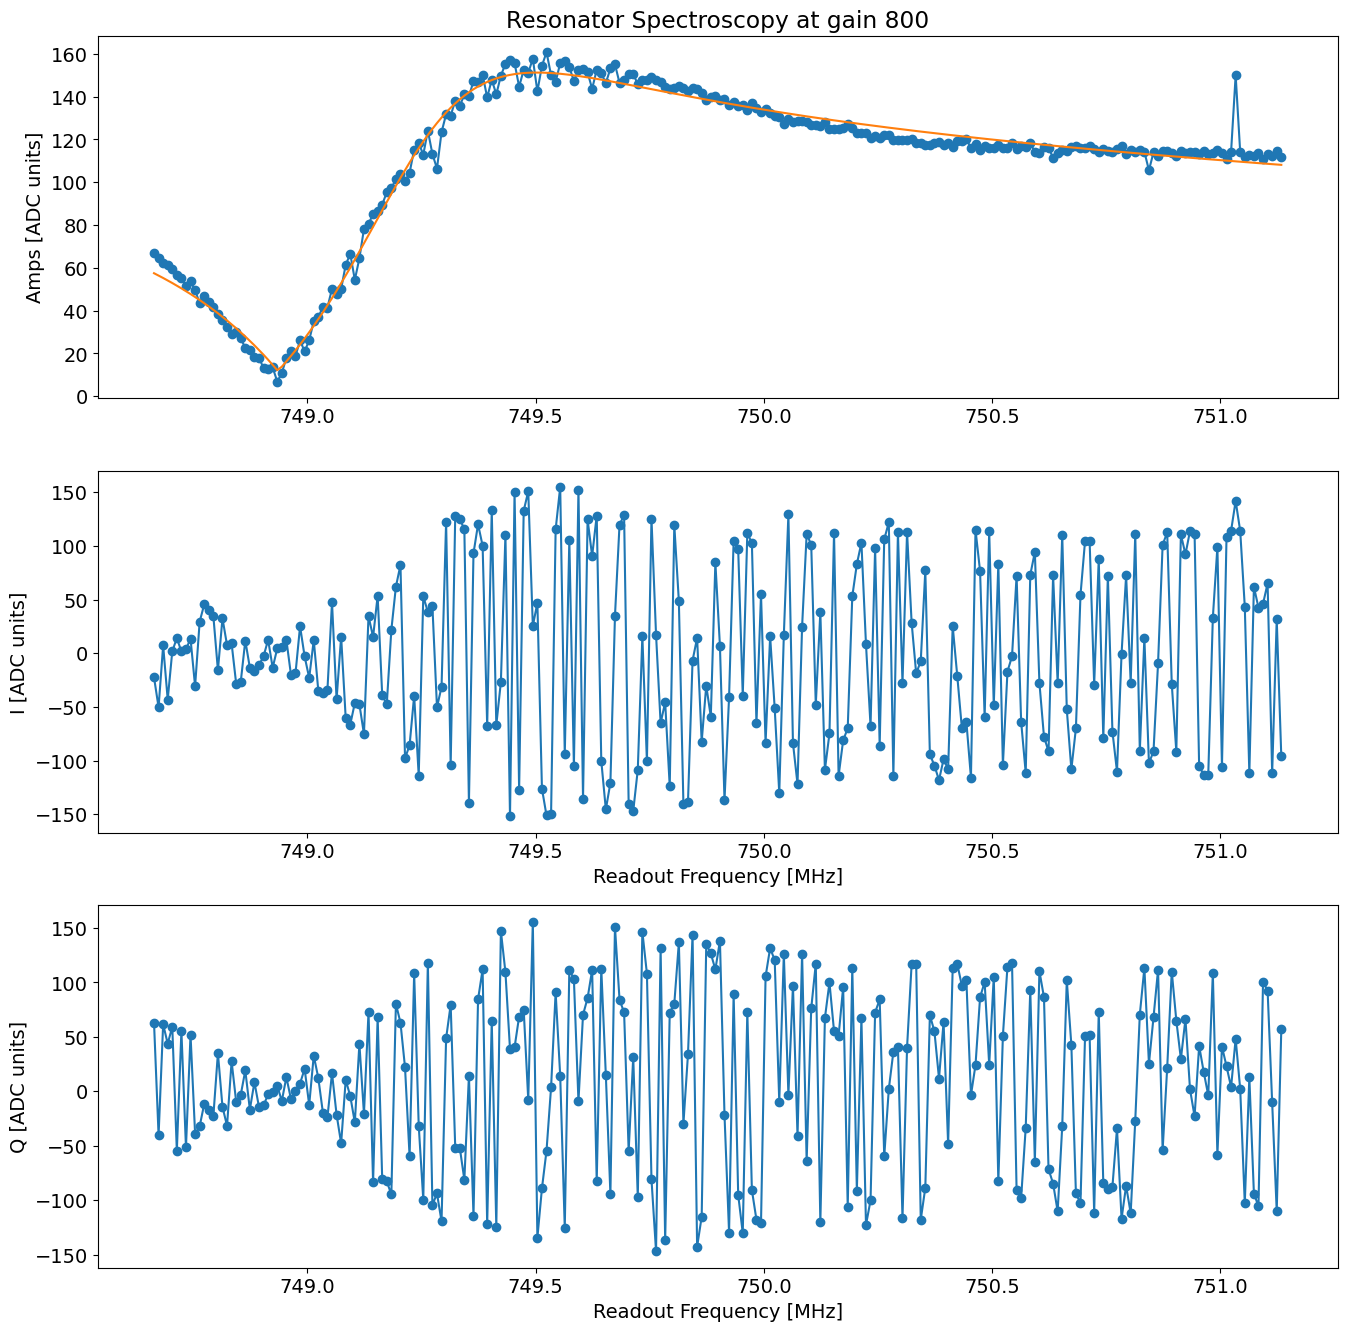

In [29]:
if expts_to_run['res_spec']: 
    rspec = do_res_spec(config_thisrun=config_thisrun)

In [30]:
rspec.data['fit'][0]

749.2317271627182

In [31]:
if expts_to_run['res_spec']: 
    update_res_spec(rspec, config_thisrun)
    print('Resonator spectroscopy done!')

Updated readout frequency!
Resonator spectroscopy done!


## Single Shot

In [24]:
def do_single_shot(
    config_thisrun,
    expt_path,
    config_path,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=True,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=400,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=500
):
    """Run the single shot experiment with configurable parameters."""

    # if pre_sweep_pulse is None:
    #     pre_sweep_pulse = [
    #         ['qubit', 'ge', 'pi', 0],
    #     ]

    hstgrm = meas.single_qubit.single_shot.HistogramExperiment(
        soccfg=soc, path=expt_path, prefix='HistogramExperiment', config_file=config_path
    )

    hstgrm.cfg = AttrDict(deepcopy(config_thisrun))

    hstgrm.cfg.expt = {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
    }

    hstgrm.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    hstgrm.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import Histogram
    
    hist_analysis = Histogram(
            hstgrm.data, verbose=True,
             span=None, threshold=None, config=hstgrm.cfg,
        )
    return hstgrm, hist_analysis


def update_single_shot(hist_analysis, config_thisrun):
    """Update the configuration based on single shot experiment results."""
    
    hist_analysis.analyze(plot = True)
    fids = hist_analysis.results['fids']
    confusion_matrix = hist_analysis.results['confusion_matrix']
    thresholds_new = hist_analysis.results['thresholds']
    angle = hist_analysis.results['angle']
    print(fids)

    config_thisrun.device.readout.phase = [config_thisrun.device.readout.phase[0] + angle]
    config_thisrun.device.readout.threshold = thresholds_new
    config_thisrun.device.readout.threshold_list = [thresholds_new]
    config_thisrun.device.readout.Ie = [np.median(hist_analysis.data['Ie_rot'])]
    config_thisrun.device.readout.Ig = [np.median(hist_analysis.data['Ig_rot'])]
    if hist_analysis.cfg.expt.active_reset:
        config_thisrun.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        config_thisrun.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

In [28]:
hstgrm = None
if expts_to_run['single_shot']: 
    hstgrm = do_single_shot(config_thisrun,  expt_path, config_path, 
                            reps = 5000, active_reset=False, relax_delay = 2500)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00006_HistogramExperiment.h5
{'device': {'qubit': {'T1': [462.4591733641585], 'f_ge': [3569.7141623787825], 'f_ef': [3426.6982208338936], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [3514], 'sigma': [0.035], 'length': [0.0], 'type': ['gauss']}, 'hpi_ge': {'gain': [1740], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'pi_ef': {'gain': [2917], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'hpi_ef': {'gain': [1449], 'sigma': [0.035], 'type': ['gauss']}, 'slow_pi_ge': {'gain': [15], 'sigma': [0.1], 'length': [10], 'type': ['flat_top']}}, 'T1_ef': [265.5293373883321]}, 'readout': {'trig_offset': [450], 'frequency': [749.2317271627182], 'gain': [800], 'phase': [-229.16977323679478], 'threshold': [-40.10202109442042], 'threshold_list': [[-40.10202109442042]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': [1.5], 'relax_delay': [2500], 'confusion_matrix_with_reset': [0.99645300228021

Unrotated:
Ig -98.98160173160173 +/- 26.83871335115073 	 Qg 8.428571428571427 +/- 23.509550891193264 	 Amp g 99.33981224906735
Ie 26.291125541125542 +/- 31.384581515042242 	 Qe 6.016233766233766 +/- 23.84067143780256 	 Amp e 26.970694298612248
updating temp data
Rotated:
Ig -99.02336249845283 +/- 26.825165265124987 	 Qg 6.585023549477624 +/- 23.525008521774744 	 Amp g 99.24207200400025
Ie 26.139770573019092 +/- 31.38412870714957 	 Qe 6.493304094870265 +/- 23.84126751606668 	 Amp e 26.93419023617628


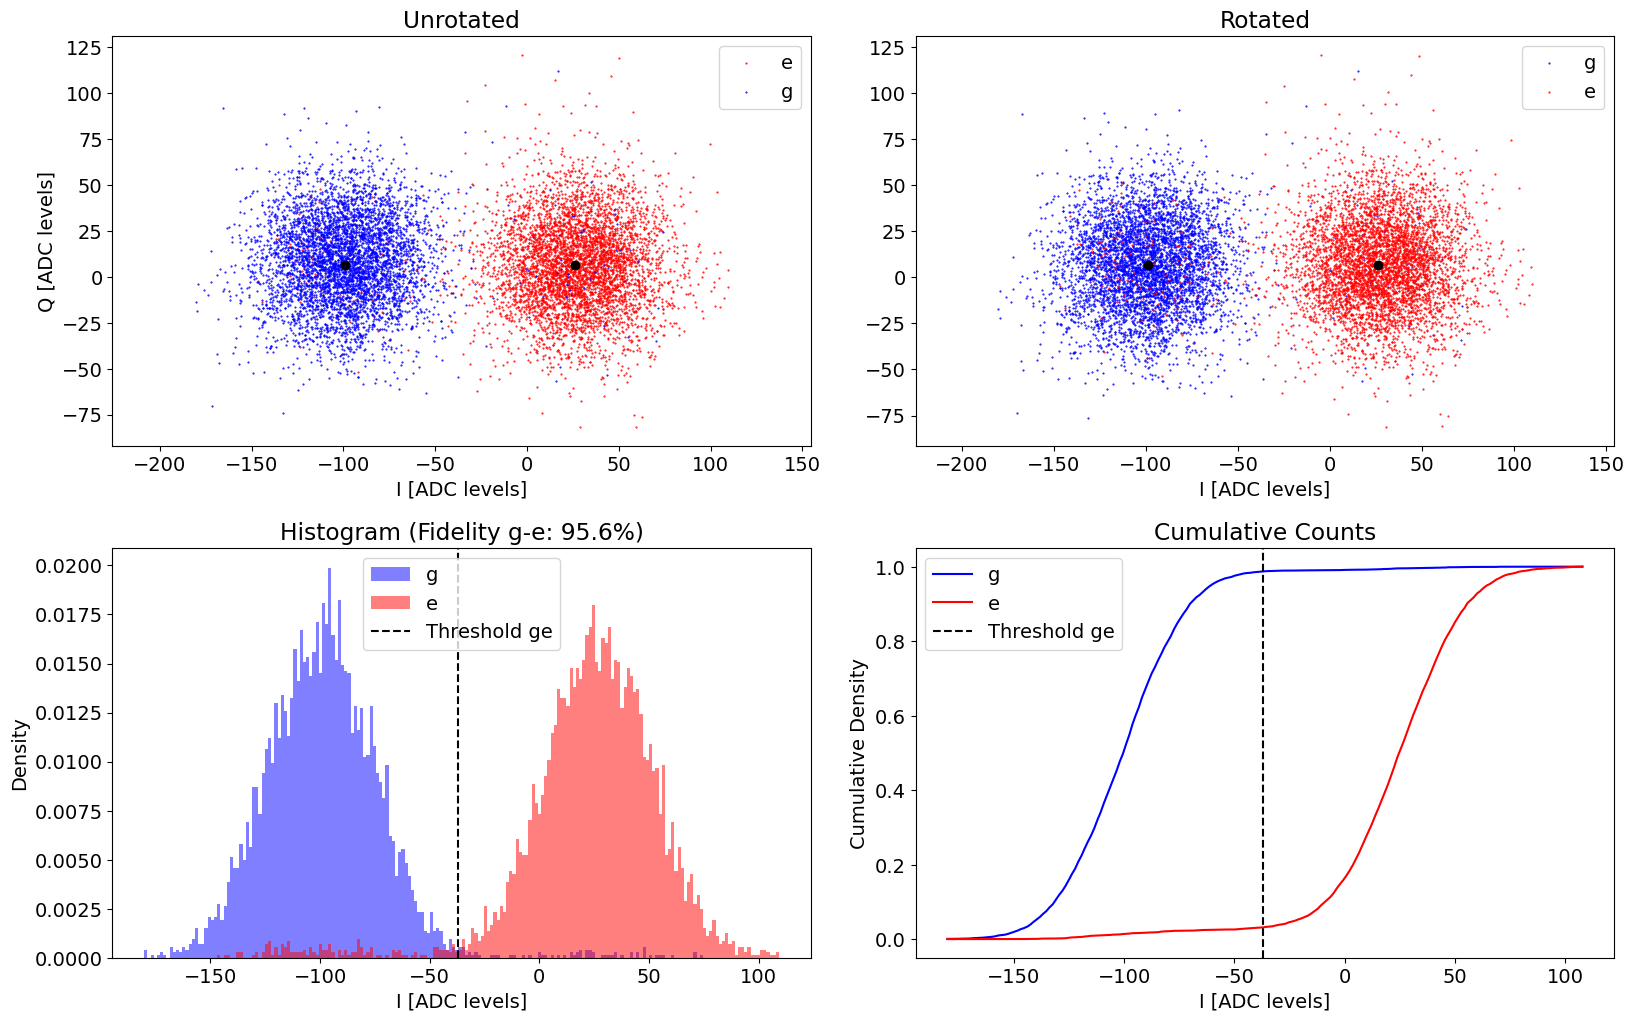

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-24_11-49-15_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-24.md


In [29]:
hstgrm[1].analyze(plot = True)

Unrotated:
Ig -98.98160173160173 +/- 26.83871335115073 	 Qg 8.428571428571427 +/- 23.509550891193264 	 Amp g 99.33981224906735
Ie 26.291125541125542 +/- 31.384581515042242 	 Qe 6.016233766233766 +/- 23.84067143780256 	 Amp e 26.970694298612248
updating temp data
Rotated:
Ig -99.02336249845283 +/- 26.825165265124987 	 Qg 6.585023549477624 +/- 23.525008521774744 	 Amp g 99.24207200400025
Ie 26.139770573019092 +/- 31.38412870714957 	 Qe 6.493304094870265 +/- 23.84126751606668 	 Amp e 26.93419023617628


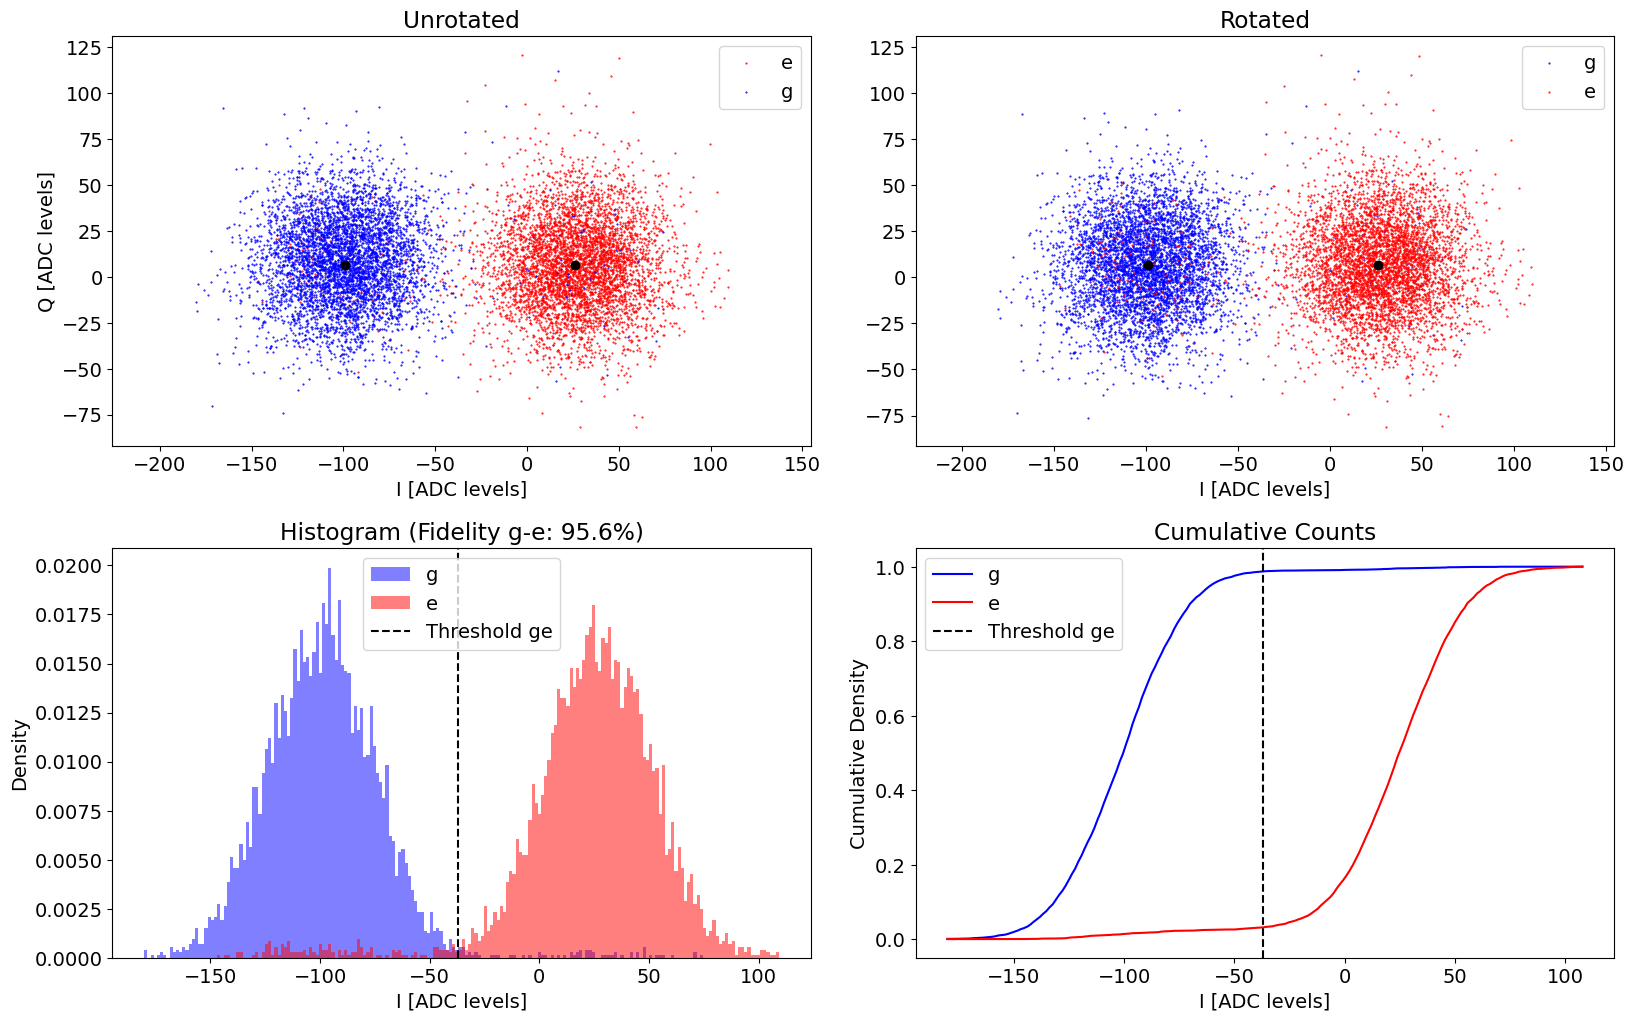

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-24_11-49-18_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-24.md
[0.9556000000000002]
Updated readout!
Single shot done!


In [30]:
if expts_to_run['single_shot']:
    update_single_shot(hstgrm[1], config_thisrun)
    print('Single shot done!')

In [36]:
# hstgrm.cfg

### JPA Calibration

In [147]:
def do_jpa_current_sweep( config_thisrun,
    expt_path,
    config_path,
    jpa_current_start=-8,
    jpa_current_step=0.1,
    jpa_current_stop = -2,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=2500
):
    """Run the single shot experiment with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import histogram_sweep_class
    experiment_class = histogram_sweep_class
    sweep_experiment_name = 'histogram_jpa_current_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] =  {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'jpa_current_start': jpa_current_start,
        'jpa_current_step': jpa_current_step,
        'jpa_current_stop': jpa_current_stop,
        'relax_delay': relax_delay
    }

   
    class_for_exp.yaml_cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

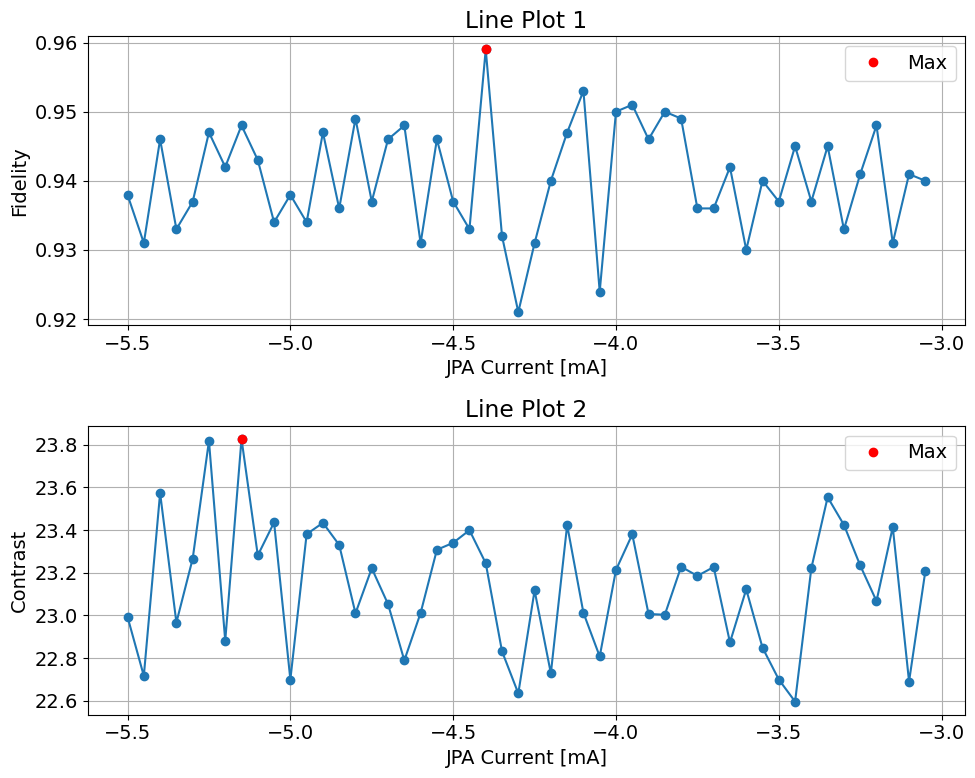

In [157]:
do_jpa_current_sweep(config_thisrun, expt_path,
                                   config_path, reps=1000,
                                   jpa_current_start=-5.0,
                                   jpa_current_stop=-4.0,
                                   jpa_current_step=0.05,
                                    #  jpa_current_start=0., jpa_current_step=0.2,
                                    #    jpa_current_stop=10., 
                                      #  active_reset=True,
                                         relax_delay=5)

In [ ]:
from slab.instruments import YokogawaGS200
dcflux = YokogawaGS200(address="192.168.137.149")
dcflux.set_output(True)
dcflux.set_mode('current')

jpa_current = -1.875 # mA
jpa_current = 0 # mA
current = jpa_current * 1e-3  # Convert from mA to A
dcflux.set_current(current)

print(1e3 * dcflux.get_current(), 'mA')

#### Sweep both gain and current

In [150]:
def do_jpa_current_gain_sweep( config_thisrun,
    expt_path,
    config_path,
    jpa_current_start=3.7,
    jpa_current_step=0.005,
    jpa_current_stop = 3.8,
    jpa_gain_start=-15,
    jpa_gain_step=0.5,
    jpa_gain_stop = -11,
    qubits=[0],
    reps=1000,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=2500
):
    """Run the single shot experiment with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import histogram_sweep_class
    experiment_class = histogram_sweep_class
    sweep_experiment_name = 'histogram_jpa_gain_current_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] =  {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'jpa_current_start': jpa_current_start,
        'jpa_current_step': jpa_current_step,
        'jpa_current_stop': jpa_current_stop,
        'jpa_gain_start': jpa_gain_start,
        'jpa_gain_step': jpa_gain_step,
        'jpa_gain_stop': jpa_gain_stop,
    }

    print('relax delay set to:', relax_delay)
    class_for_exp.yaml_cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

In [151]:
sweep_func = do_jpa_current_gain_sweep(config_thisrun, expt_path,
                                        config_path, reps=1000, 
                                        jpa_current_start=-5.5,
                                        jpa_current_step=-0.1,
                                        jpa_current_stop=-4.5,
                                        jpa_gain_start=-15,
                                        jpa_gain_step=0.5,
                                        jpa_gain_stop=-5,
                                        # active_reset=True, relax_delay=5
                                        )

relax delay set to: 2500
HistogramExperiment
Index: 0 Gain. = -15.0


OSError: exception: access violation reading 0x0000000000000040

## Qubit ge

### Pulse-probe

In [37]:
def do_pulse_probe(
    config_thisrun, 
    start=3560,  # [MHz]
    step=0.1,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=2000,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=100,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,  # Wait time between experiments [us]
    ): 
    qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeSpectroscopyExperiment', 
        config_file=config_file
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = dict(
        qubits = [0],
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        sigma=sigma,
        qubit=qubit,
        prepulse = prepulse, 
        pre_sweep_pulse = pre_sweep_pulse,
        gate_based = gate_based,
    )

    qspec.cfg.device.readout.relax_delay = [relax_delay] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

def update_pulse_probe_ge(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ge = [qspec.data['fit_avgi'][2]]
    print('Updated qubit frequency!')

pulssing on channel:  2
qubit register page: 1, frequency register: 22


  0%|          | 0/50000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00000_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3569.700577691843, HWHM 0.36880393634554925
Found peak in I at [MHz] 3569.700555276555, HWHM 0.36891102096874556
Found peak in Q at [MHz] 3569.7545657554056, HWHM 0.3670914071011698


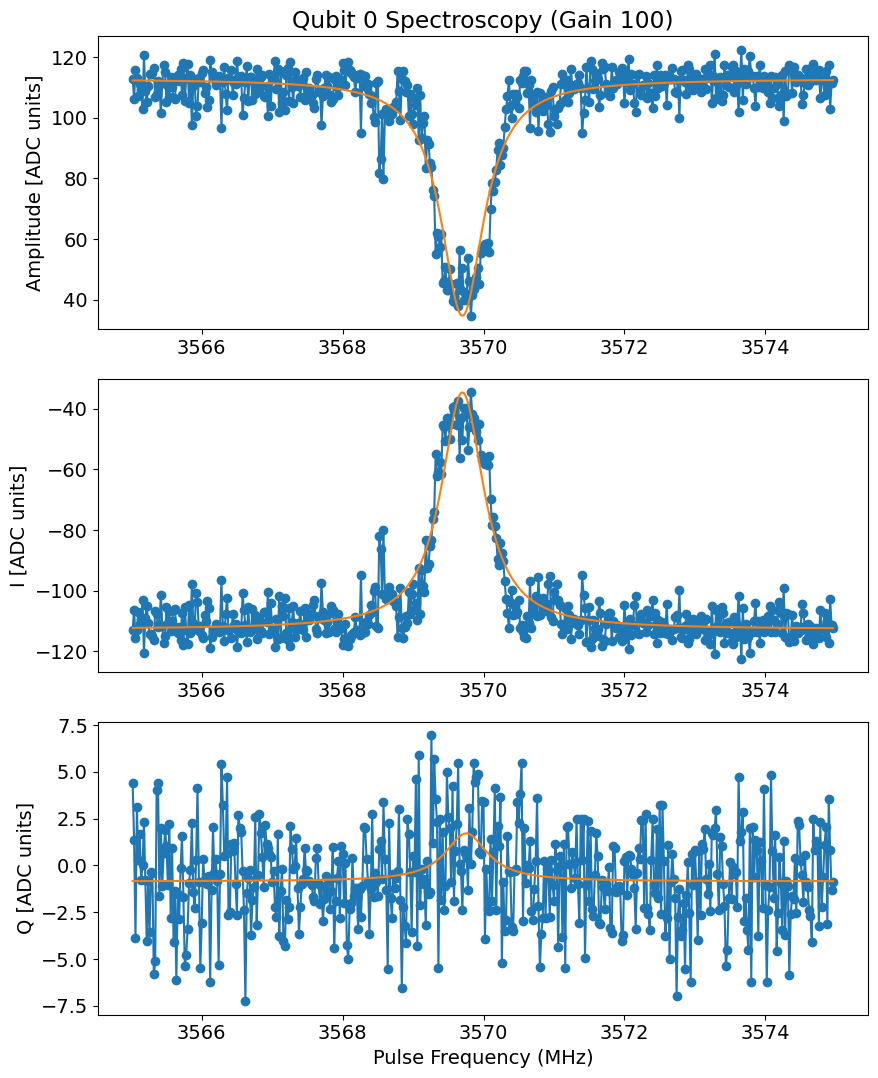

In [38]:
qspec =  do_pulse_probe(
    config_thisrun=config_thisrun,
    start=3565,  # [MHz]
    step=0.02,  # min step ~1 MHz
    expts=500,  # Number of experiments stepping from start
    reps=100,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    # rounds=1000000,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=100,  # Qubit pulse gain
    # gain=30000,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=300  # Wait time between experiments [us]
    # relax_delay=3  # Wait time between experiments [us]
)

In [39]:
# if expts_to_run['pulse_probe_ge']: 
#     qspec = do_pulse_probe_ge(config_thisrun)

In [40]:
if expts_to_run['pulse_probe_ge']:
    update_pulse_probe_ge(qspec, config_thisrun)
    print('Pulse probe spectroscopy done!')

Updated qubit frequency!
Pulse probe spectroscopy done!


### T2 Ramsey

In [27]:
def do_t2_ramsey_ge(
    config_thisrun,
    expt_path,
    config_path,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    step_size=soc.cycles2us(8),
    if_ef=False,
    ef_init=True, # redundant
    start=0.01,
    expts=201,
    ramsey_freq=3,  # [MHz]
    reps=200,
    rounds=1,
    qubits=[0],
    user_defined_freq=[False, 3568.2038290468167, 5304, 0.035],
    f0g1_cavity=0,
    normalize=False,
    active_reset=True,
    man_reset=False,
    storage_reset=False,
    prepulse=None,
    postpulse=None,
    pre_active_reset_pulse=False,
    gate_based=False,
    advance_phase=0,
    echoes=[False, 0],
    relax_delay=200
):
    """Run the T2 Ramsey experiment with all config params as function arguments."""
    t2ramsey = meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))
    checkEF = False
    qubit_ge_init = False
    qubit_ge_after = False
    if if_ef:
        checkEF = True
        qubit_ge_init = True if ef_init else False
        qubit_ge_after = True if ef_init else False

    t2ramsey.cfg.expt = {
        'start': start,
        'step': step_size,
        'expts': expts,
        'ramsey_freq': ramsey_freq,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'checkEF': checkEF,
        'user_defined_freq': user_defined_freq,
        'qubit_ge_init': qubit_ge_init,
        'qubit_ge_after': qubit_ge_after,
        'f0g1_cavity': f0g1_cavity,
        'normalize': normalize,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': False if pre_sweep_pulse is None else True if prepulse is None else prepulse,
        'postpulse': False if post_sweep_pulse is None else True if postpulse is None else postpulse,
        'pre_active_reset_pulse': pre_active_reset_pulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'post_sweep_pulse': post_sweep_pulse,
        'gate_based': gate_based,
        'advance_phase': advance_phase,
        'echoes': echoes
    }

    t2ramsey.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    # t2ramsey.cfg.device.qubit.f_ge = [3567.346809921427]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import RamseyFitting
    t2ramsey_analysis = RamseyFitting(
        t2ramsey.data, config=t2ramsey.cfg,
    )
    return t2ramsey_analysis



def update_t2_ramsey_ge(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ge = [config_thisrun.device.qubit.f_ge[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ge frequency to:', config_thisrun.device.qubit.f_ge[0])



fge is  3569.7141623787825
fef is  3426.6982208338936


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00007_RamseyExperiment.h5
No echoes in the data
Attempted to init fitparam 4 to -23.16379707792208, which is out of bounds -0.5344805194805196 to 12.30147186147186. Instead init to 5.8834956709956705
Current pi pulse frequency: 3569.7141623787825
Fit frequency from I [MHz]: 0.20865774398290046 +/- 0.0003327521156164929
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.7055046347996
 	3570.1228201227655
T2 Ramsey from fit I [us]: 148.4826646198308
Fit frequency from Q [MHz]: 0.20568881914202886 +/- 0.0045289803450254
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.7084735596404
 	3570.1198511979246
T2 Ramsey from fit Q [us]: 17.504000361934352


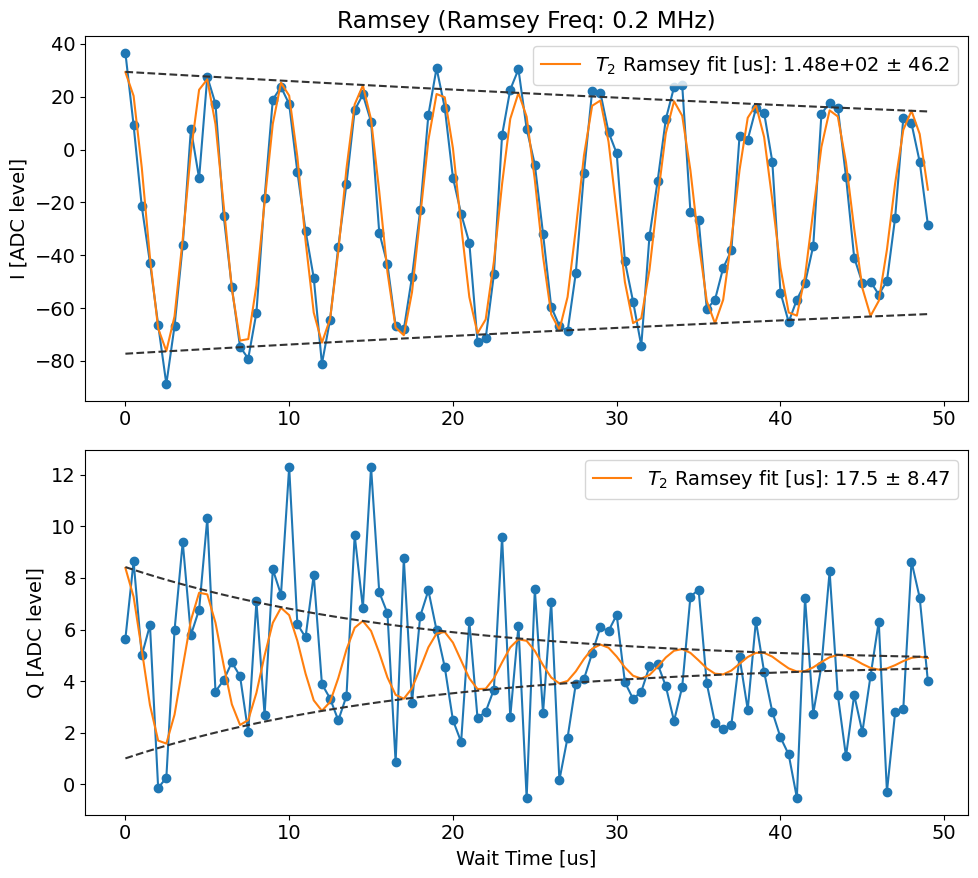

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-23_22-54-28_T2_ge.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-23.md
T2 Ramsey done!


In [28]:
t2ramsey_ge = None
if expts_to_run['t2_ge']:
    # pre_sweep_pulse = [
    #     ['qubit', 'ge', 'pi', 0],
    #     ['qubit', 'ef', 'pi', 0],
    #     ['man', 'M1', 'pi', 0],
    # ]
    pre_sweep_pulse = None
    t2ramsey_ge = do_t2_ramsey_ge(config_thisrun, expt_path, config_path,
                                  ramsey_freq=0.2,
                                  step_size=0.5,
                                  expts=100,
                                  pre_sweep_pulse=pre_sweep_pulse,
                                  reps=200, active_reset=True, relax_delay=50)
    t2ramsey_ge.analyze()
    t2ramsey_ge.display(title_str='T2_ge')
    print('T2 Ramsey done!')

In [43]:
# config_thisrun.device.qubit.f_ge[0]= 3571.672429380876

In [44]:
if expts_to_run['t2_ge']:
    update_t2_ramsey_ge(t2ramsey_ge, config_thisrun)
    print('T2 Ramsey updated!')

Updated qubit ge frequency to: 3569.713251330121
T2 Ramsey updated!


No echoes in the data
Attempted to init fitparam 4 to -50.23821277056277, which is out of bounds -2.5688636363636363 to 14.523603896103895. Instead init to 5.977370129870129
Current pi pulse frequency: 3569.700555276555
Fit frequency from I [MHz]: 0.18730394643424472 +/- 0.00043125151337395506
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.713251330121
 	3570.087859222989
T2 Ramsey from fit I [us]: 198.16854933969557
Fit frequency from Q [MHz]: 0.21515158255888972 +/- 0.01133237941288539
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.6854036939962
 	3570.1157068591137
T2 Ramsey from fit Q [us]: 15.049974465695724


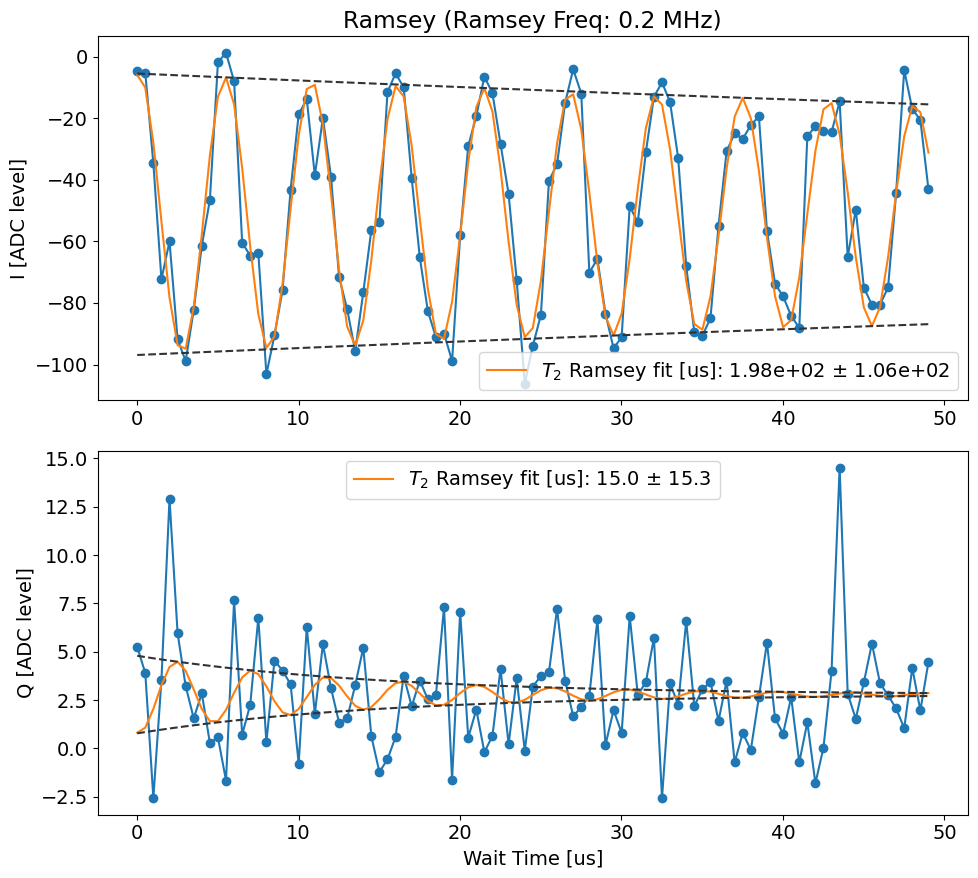

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_10-33-50_T2_ge.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md


In [45]:
t2ramsey_ge.analyze()
t2ramsey_ge.display(title_str='T2_ge')

In [46]:
# config_thisrun.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [47]:
def do_amplitude_rabi(
    config_thisrun,
    expt_path,
    config_path,
    start=None,
    step=None,
    expts=151,
    reps=200,
    rounds=1,
    sigma_test=None,
    qubit=0,
    pulse_type='gauss',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    postpulse=False, 
    if_ef=False,  # If true, will check ef frequency and update it
):
    """
    Run the amplitude Rabi experiment.
    All experiment parameters are function arguments.
    """
    amprabi = meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))

    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge
    if sigma_test is None:
        sigma_test = pulse_ge.sigma[0]
    if start is None:
        start = 0
    if step is None:
        step = int(pulse_ge.gain[0] / (expts - 1))
    
    checkEF = False
    pulse_ge_init = False
    pulse_ge_after = False
    if if_ef:
        checkEF = True
        pulse_ge_init = True
        pulse_ge_after = True

    amprabi.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        sigma_test=sigma_test,
        qubit=qubit,
        pulse_type=pulse_type,
        drag_beta=drag_beta,
        pulse_ge_init=pulse_ge_init,
        pulse_ge_after=pulse_ge_after,
        checkZZ=checkZZ,
        checkEF=checkEF,
        qubits=qubits,
        flat_length=flat_length,
        normalize=normalize,
        single_shot=single_shot,
        singleshot_reps=singleshot_reps,
        span=span,
        user_defined_freq=user_defined_freq,
        prepulse=prepulse,
        postpulse=postpulse
    )

    amprabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    amprabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import AmplitudeRabiFitting
    amprabi_analysis = AmplitudeRabiFitting(
        amprabi.data, 
        readout_per_round=4, config=amprabi.cfg,
    )
    return amprabi_analysis


def update_amplitude_rabi(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ge.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ge.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')



In [48]:
amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path, step = 60)

  0%|          | 0/30200 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00000_AmplitudeRabiExperiment.h5


Attempted to init fitparam 4 to -60.79357922077921, which is out of bounds -4.333095238095238 to 4.759740259740259. Instead init to 0.21332251082251075
Attempted to init fitparam 4 to 0.21332251082251075, which is out of bounds 1.1833333628789657 to 117.83570644856268. Instead init to 59.50951990572082
Pi gain from avgi data [dac units]: 3514
	Pi/2 gain from avgi data [dac units]: 1740
Pi gain from avgq data [dac units]: 2978
	Pi/2 gain from avgq data [dac units]: 869


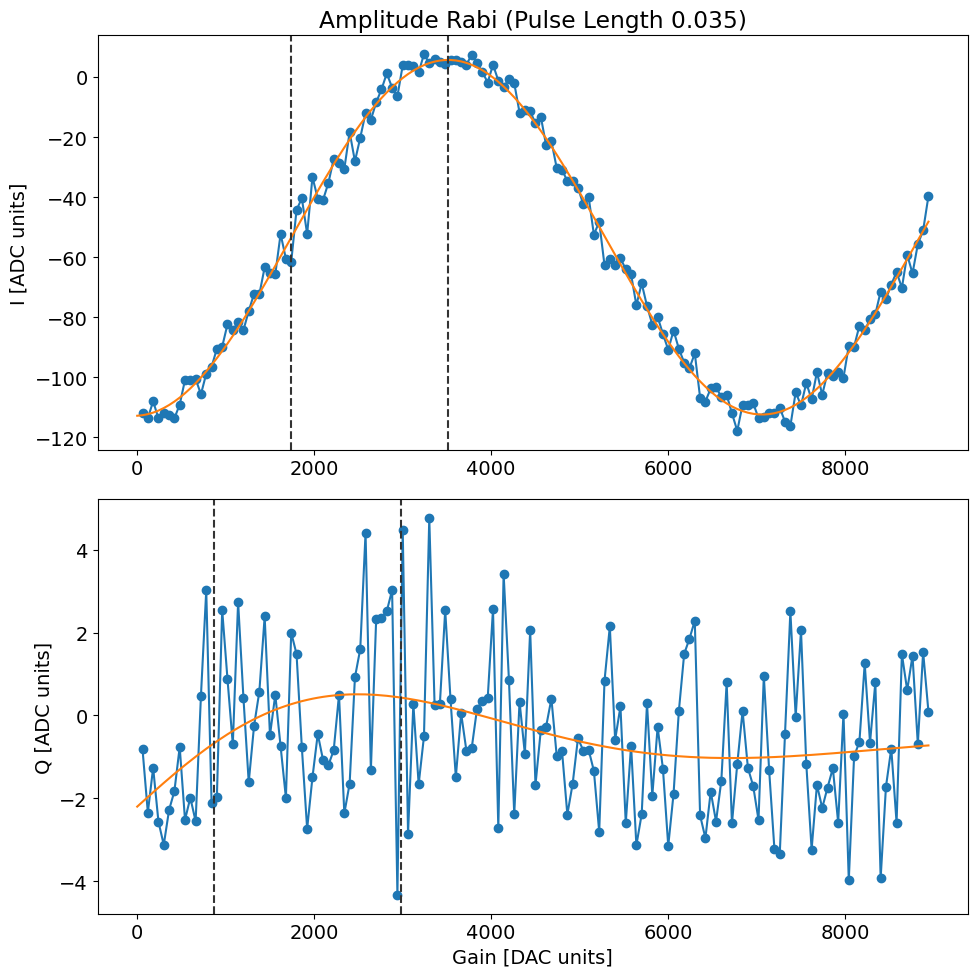

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_10-35-13_Amplitude_Rabi_ge.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md
Updated qubit ge pi and hpi gaussian gain!


In [49]:
# [amplitude, frequency, phase, decay_time, offset, decay_offset]
amprabi.analyze(fitparams=[np.ptp(amprabi.data['avgi'])/2, 0.0001, np.pi, 1000000,None, None])
amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)
update_amplitude_rabi(amprabi, config_thisrun)

fge is  3569.713251330121
fef is  3426.6956358736547


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00001_RamseyExperiment.h5
No echoes in the data
Attempted to init fitparam 4 to -55.02313939393939, which is out of bounds -6.465367965367966 to 7.118311688311688. Instead init to 0.32647186147186114
Current pi pulse frequency: 3569.713251330121
Fit frequency from I [MHz]: 1.9990889513381358 +/- 0.0038003327045991186
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.7141623787825
 	3573.712340281459
T2 Ramsey from fit I [us]: 47.7134336379534
Fit frequency from Q [MHz]: 2.1638722202397913 +/- 0.23421900020573624
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.549379109881
 	3573.8771235503605
T2 Ramsey from fit Q [us]: 0.552455357966831


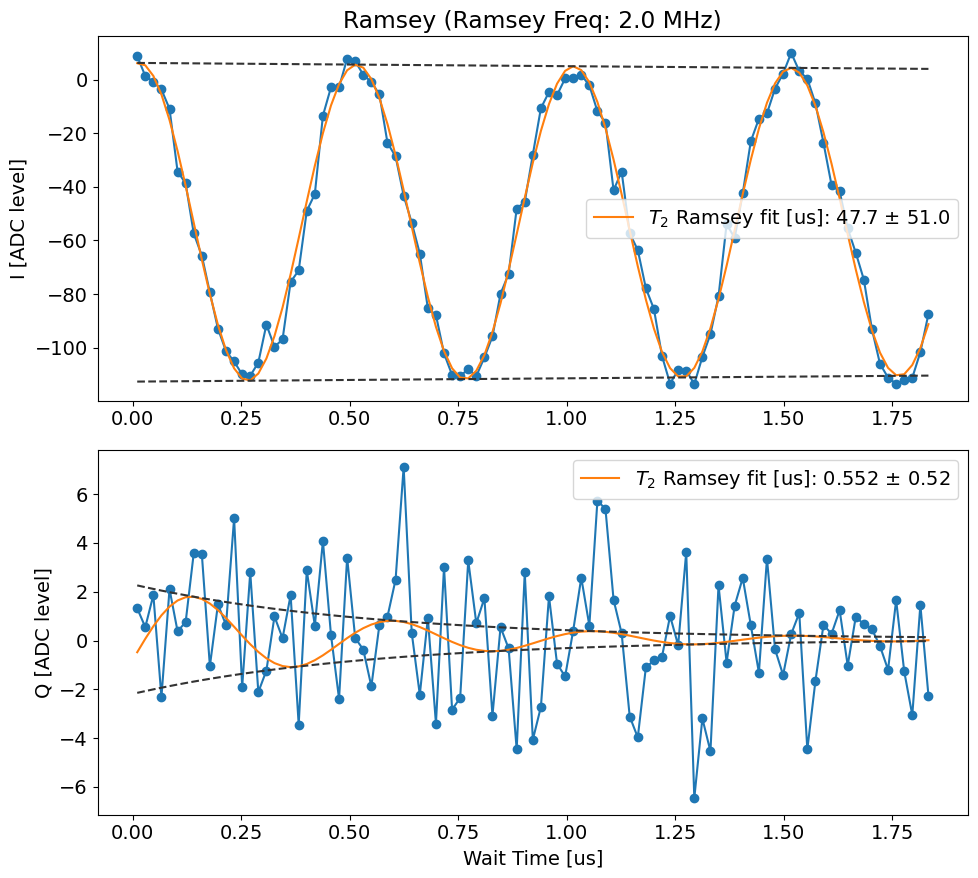

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_10-35-44_T2_ge_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md
Updated qubit ge frequency to: 3569.7141623787825
T2 Ramsey done!


In [50]:
t2_ramsey_ge_after_amp = None
if expts_to_run['amplitude_ge']:
    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ge_after_amp  = do_t2_ramsey_ge(config_thisrun, expt_path, config_path,
                                              ramsey_freq=2.0,
                                              step_size=soc.cycles2us(8),
                                              expts=100,
                                              reps=100, active_reset=False, relax_delay=2500)
    t2_ramsey_ge_after_amp.analyze()
    t2_ramsey_ge_after_amp.display(title_str='T2_ge_after_amp')
    update_t2_ramsey_ge(t2_ramsey_ge_after_amp , config_thisrun)
    print('T2 Ramsey done!')

In [51]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)
# print('Amplitude Rabi done!')

In [52]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.0001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)


# Magic Params: [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None]

### T1

In [53]:
def do_t1_ge(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 20,
        'expts': 100,
        'reps': 100,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': False,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ge(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1 = [t1.data['fit_avgi'][3]]
    print('Updated qubit T1!')


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00000_T1Experiment.h5
Fit T1 avgi [us]: 462.4591733641585
Fit T1 avgq [us]: -228406.94674961708


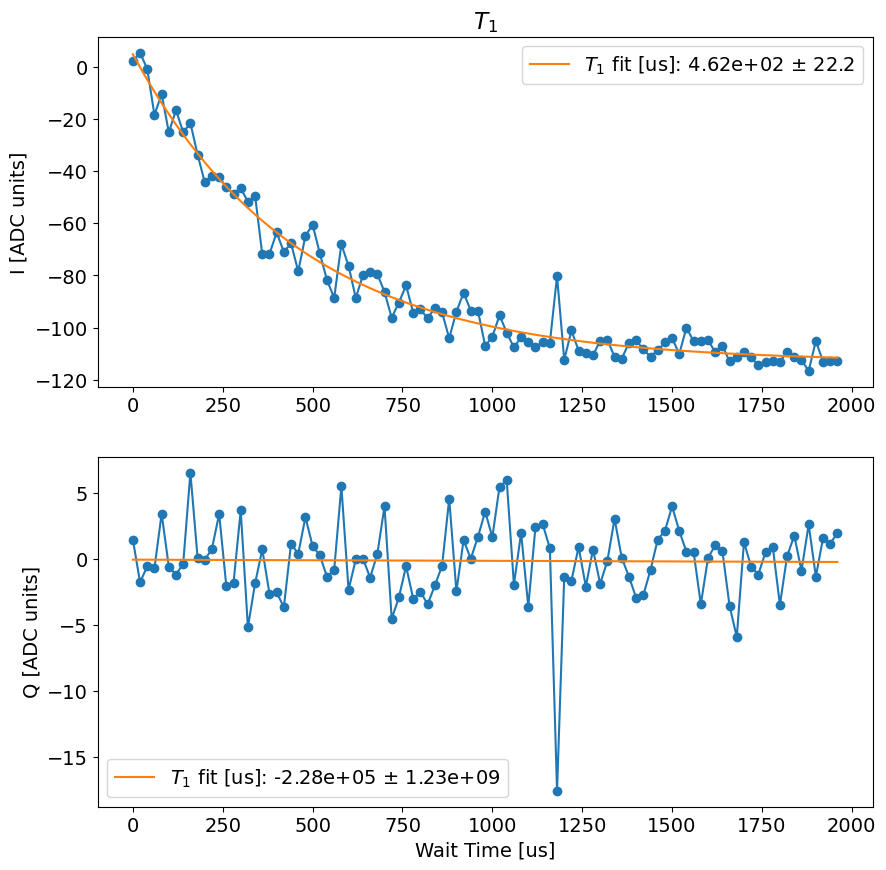

Fit T1 avgi [us]: 462.4591733641585
Fit T1 avgq [us]: -228406.94674961708


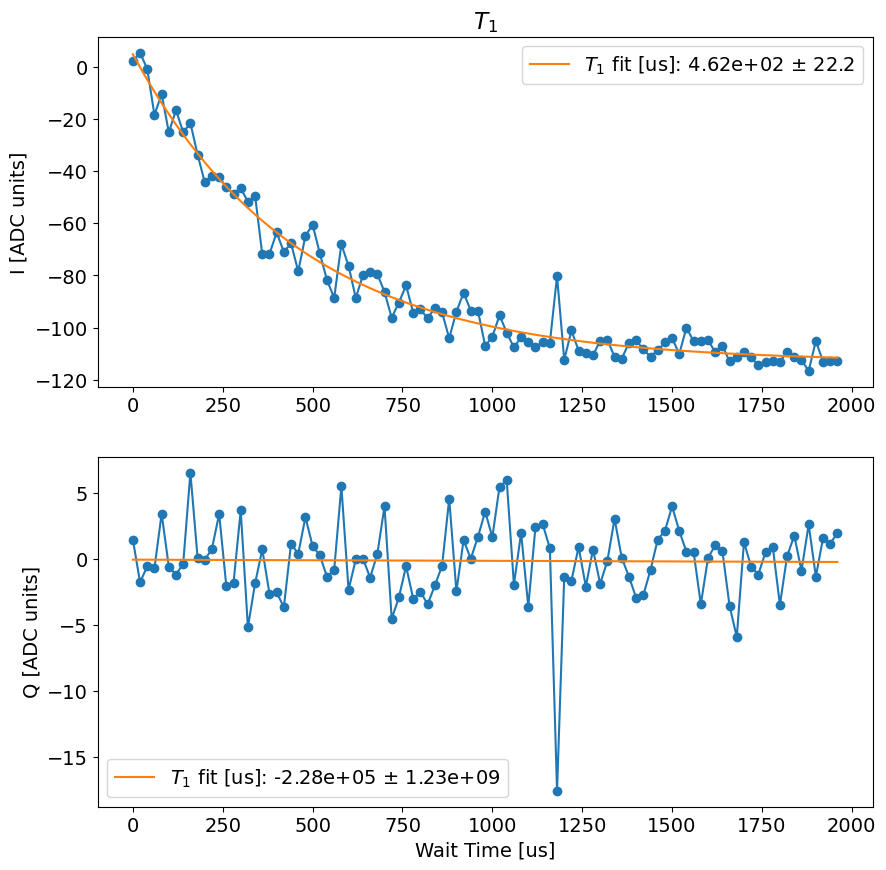

Updated qubit T1!
T1 done!


In [54]:
t1 = None
if expts_to_run['t1_ge']:
    t1 = do_t1_ge(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ge(t1, config_thisrun)
    print('T1 done!')

## Qubit ef

### Pulse-probe

In [55]:
def do_pulse_probe_ef(config_thisrun): 

    qspec = meas.single_qubit.pulse_probe_ef_spectroscopy.PulseProbeEFSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeEFSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {'start': 3415,
        'step': 0.05,
        'expts': 500,
        'reps': 200,
        'rounds': 1,
        'length': 1,
        'gain': 100,
        # 'pulse_type': 'gaussian',
        'qubit_f': False,
        'qubit': 0,
        'cavity_drive': False,
        'wait_qubit': False,}



    qspec.cfg.device.readout.relax_delay = [500] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

def update_pulse_probe_ef(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ef = [qspec.data['fit_avgi'][2]]
    print('Updated qubit frequency!')

In [56]:
# expts_to_run['pulse_probe_ef'] = True

  0%|          | 0/100000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00000_PulseProbeEFSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3426.689972230902, HWHM 0.43498515076110916
Found peak in I at [MHz] 3426.7041436075306, HWHM -0.44198549407703497
Found peak in Q at [MHz] 3426.686608260481, HWHM -0.3989216352325755


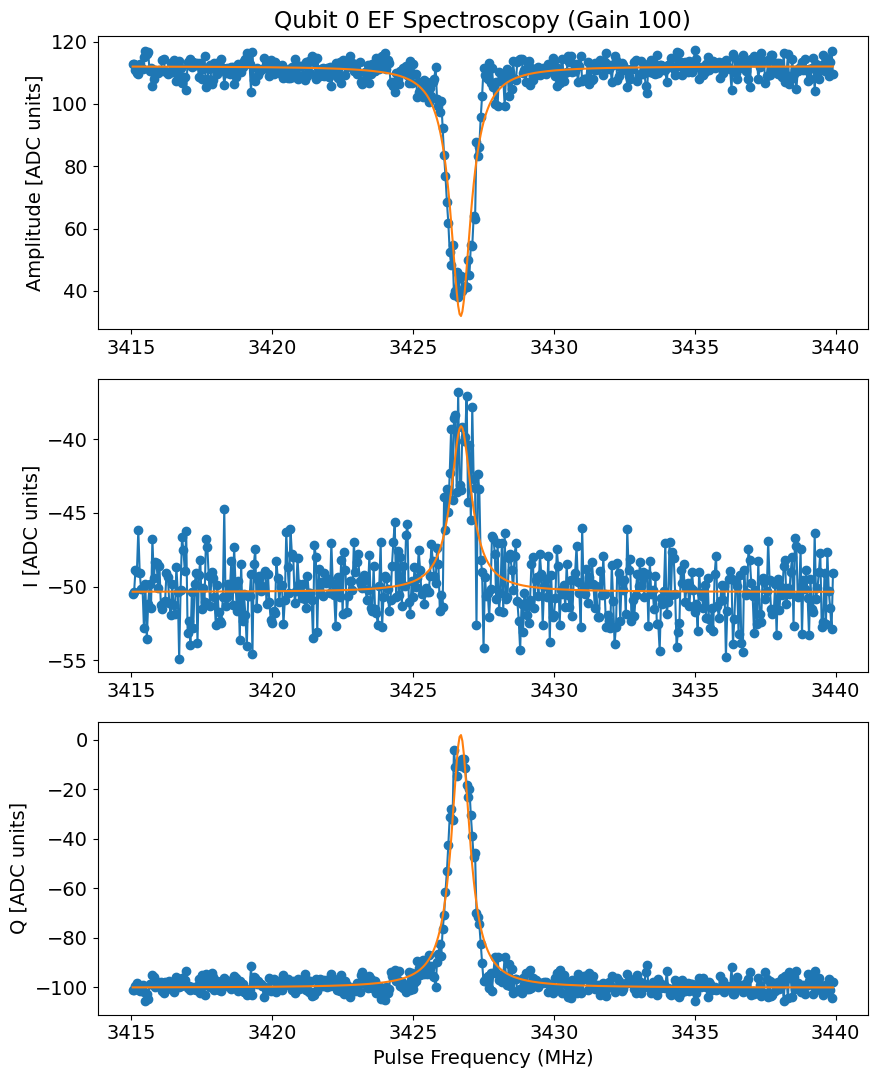

In [57]:
qspec_ef = None
if expts_to_run['pulse_probe_ef']: 
    qspec_ef = do_pulse_probe_ef(config_thisrun)


In [58]:
if expts_to_run['pulse_probe_ef']:
    update_pulse_probe_ef(qspec_ef, config_thisrun)
    print('Pulse probe spectroscopy done!')

Updated qubit frequency!
Pulse probe spectroscopy done!


### T2 Ramsey

In [59]:
def do_t2_ramsey_ef(config_thisrun, expt_path, config_path, ef_init = True, pre_sweep_pulse = None, post_sweep_pulse = None, ramsey_freq = 3, step_size = soc.cycles2us(8), 
                    active_reset = False, relax_delay = 2500, reps = 100):
    """Run the T2 Ramsey experiment."""
    return do_t2_ramsey_ge(config_thisrun, expt_path, config_path, pre_sweep_pulse=pre_sweep_pulse, 
                            post_sweep_pulse=post_sweep_pulse, ramsey_freq=ramsey_freq, step_size=step_size, if_ef=True, ef_init=ef_init,
                            active_reset=active_reset, relax_delay=relax_delay, reps = reps)
    


def update_t2_ramsey_ef(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ef = [config_thisrun.device.qubit.f_ef[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ef frequency to:', config_thisrun.device.qubit.f_ef[0])

fge is  3569.7141623787825
fef is  3426.7041436075306


  0%|          | 0/20100 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00002_RamseyExperiment.h5
No echoes in the data
Attempted to init fitparam 4 to -51.69537065753483, which is out of bounds -3.7853896103896103 to 75.0577922077922. Instead init to 35.636201298701295
Current pi pulse frequency: 3426.7041436075306
Fit frequency from I [MHz]: 3.0067513317770995 +/- 0.0016366603197033155
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.6973922757534
 	3432.7108949393078
T2 Ramsey from fit I [us]: 57.30945737355014
Fit frequency from Q [MHz]: 3.00291370266098 +/- 0.002353712821279337
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.7012299048697
 	3432.7070573101914
T2 Ramsey from fit Q [us]: 8.851947070967778


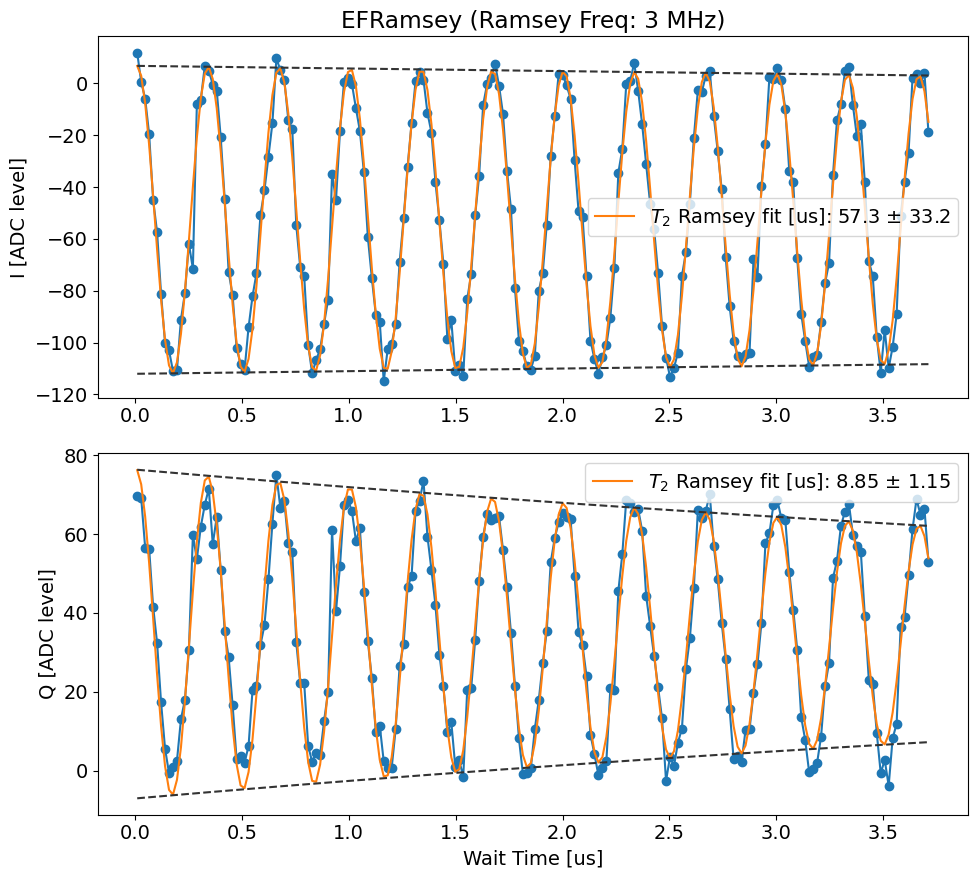

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_10-38-16_T2_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md
T2 Ramsey done!


In [60]:
t2ramsey_ef = None
if expts_to_run['t2_ef']:
    t2ramsey_ef = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2ramsey_ef.analyze()
    t2ramsey_ef.display(title_str='T2_ef')
    # update_t2_ramsey_ef(t2ramsey_ef, config_thisrun)
    print('T2 Ramsey done!')

In [61]:
# t2ramsey_ef.analyze(fitparams=[100, 10, None, 20, None, None])
# t2ramsey_ef.display(title_str='T2_ef')
update_t2_ramsey_ef(t2ramsey_ef, config_thisrun)

Updated qubit ef frequency to: 3426.6973922757534


### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [62]:
def do_amplitude_rabi_ef(config_thisrun, expt_path, config_path):
    """Run the amplitude Rabi experiment."""
    return do_amplitude_rabi(config_thisrun, expt_path, config_path, step=40, expts=150, if_ef=True)


def update_amplitude_rabi_ef(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ef.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ef.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ef pi and hpi gaussian gain!')



  0%|          | 0/30000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00001_AmplitudeRabiExperiment.h5
Attempted to init fitparam 4 to -52.82625671867283, which is out of bounds -6.105378787878788 to 73.1575. Instead init to 33.526060606060604
Attempted to init fitparam 4 to 33.526060606060604, which is out of bounds 53.6732879742214 to 113.61220147224225. Instead init to 83.64274472323183
Pi gain from avgi data [dac units]: 2920
	Pi/2 gain from avgi data [dac units]: 1467
Pi gain from avgq data [dac units]: 2888
	Pi/2 gain from avgq data [dac units]: 1353


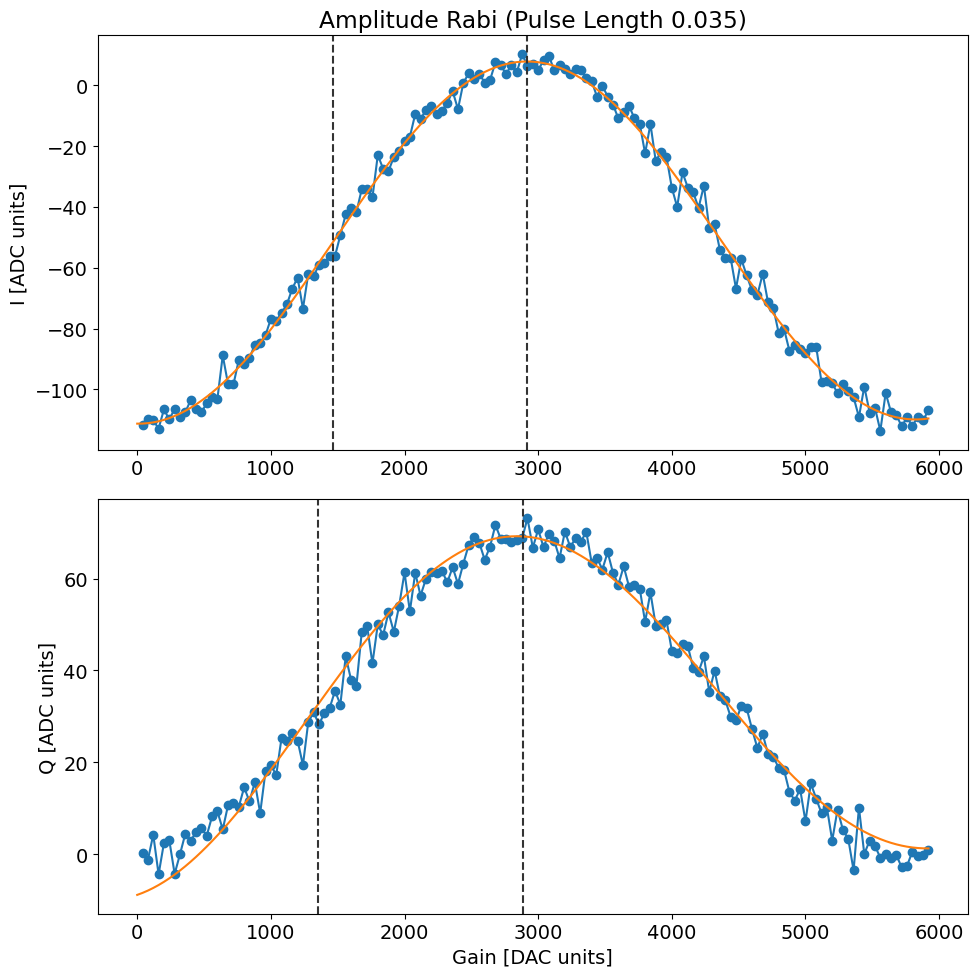

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_10-39-37_Amplitude_Rabi_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md


In [63]:
amprabi_ef = do_amplitude_rabi_ef(config_thisrun, expt_path, config_path)
amprabi_ef.analyze(fitparams=[np.max(amprabi_ef.data['amps']), 0.0001, np.pi, 10000,None, None])
amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=True)


In [64]:
update_amplitude_rabi_ef(amprabi_ef, config_thisrun)

Updated qubit ef pi and hpi gaussian gain!


  0%|          | 0/30000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00002_AmplitudeRabiExperiment.h5
Attempted to init fitparam 4 to -52.70017483076207, which is out of bounds -3.5944913419913416 to 71.05817099567099. Instead init to 33.731839826839824
Attempted to init fitparam 4 to 33.731839826839824, which is out of bounds 53.15395920796907 to 114.85864076953239. Instead init to 84.00629998875073
Pi gain from avgi data [dac units]: 2917
	Pi/2 gain from avgi data [dac units]: 1449
Pi gain from avgq data [dac units]: 2880
	Pi/2 gain from avgq data [dac units]: 1369


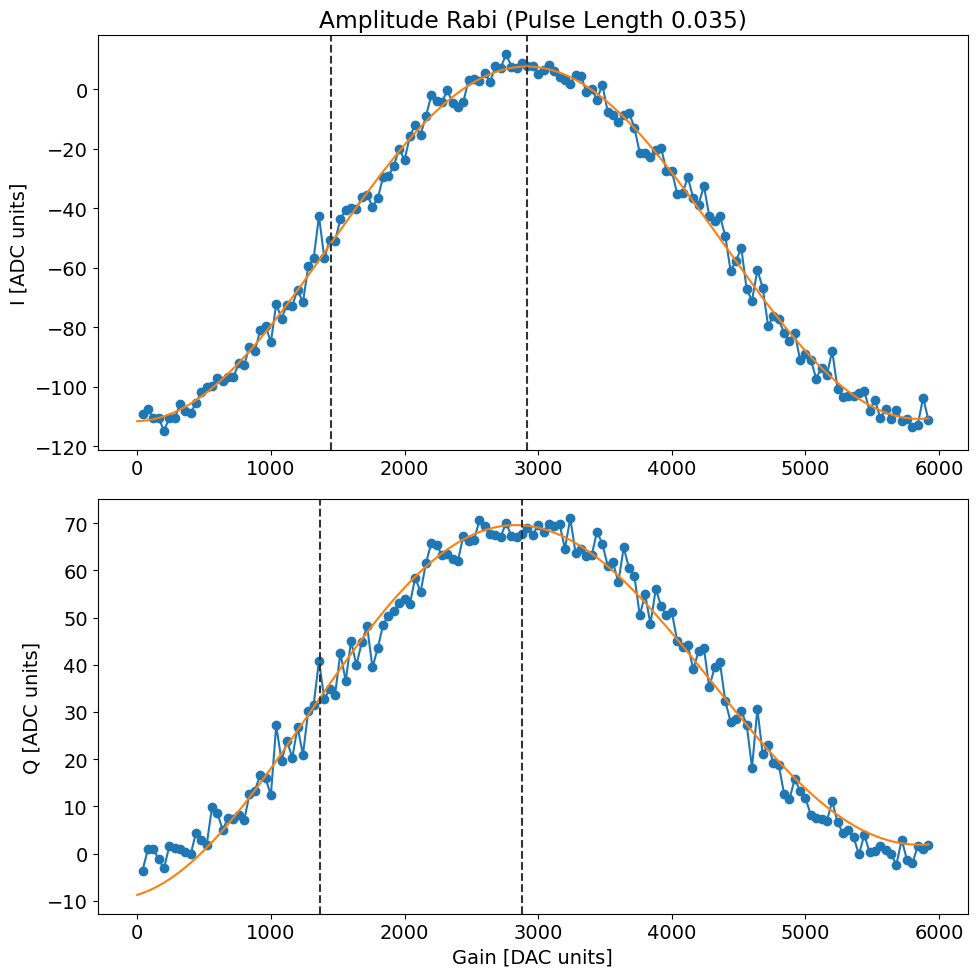

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_10-40-57_Amplitude_Rabi_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md
Updated qubit ef pi and hpi gaussian gain!
Amplitude Rabi done!
fge is  3569.7141623787825
fef is  3426.6973922757534


  0%|          | 0/20100 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00003_RamseyExperiment.h5
No echoes in the data
Attempted to init fitparam 4 to -51.378480433331184, which is out of bounds -5.013982683982684 to 74.03560606060606. Instead init to 34.510811688311684
Current pi pulse frequency: 3426.6973922757534
Fit frequency from I [MHz]: 2.999171441859933 +/- 0.0015944516107649167
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.6982208338936
 	3432.696563717613
T2 Ramsey from fit I [us]: 30.241780496116306
Fit frequency from Q [MHz]: 3 +/- inf
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.6973922757534
 	3432.6973922757534
T2 Ramsey from fit Q [us]: 3.7202380952380953


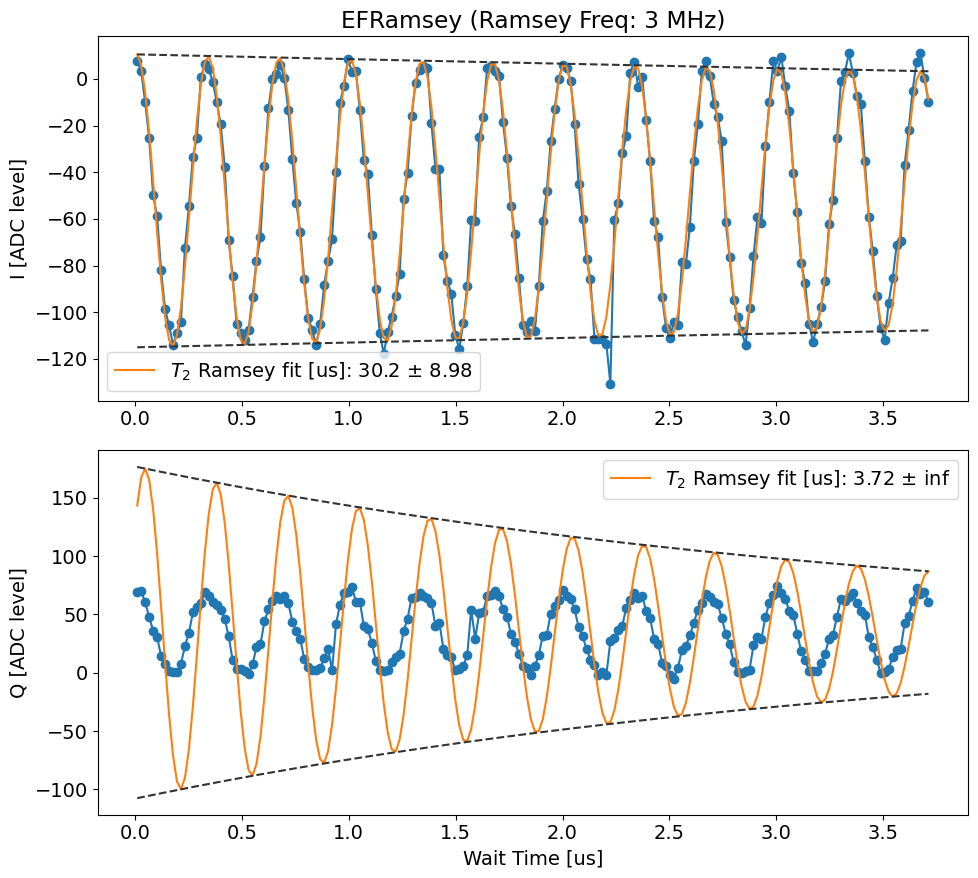

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_10-41-53_T2_ef_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md
Updated qubit ef frequency to: 3426.6982208338936
T2 Ramsey done!


In [65]:
amprabi_ef = None
t2_ramsey_ef_after_amp = None
if expts_to_run['amplitude_ef']:
    amprabi_ef = do_amplitude_rabi_ef(config_thisrun, expt_path, config_path)
    amprabi_ef.analyze(fitparams=[np.max(amprabi_ef.data['amps']), 0.0001, np.pi, 10000,None, None])
    amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=True)
    update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2_ramsey_ef_after_amp.analyze()
    t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
    update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
    print('T2 Ramsey done!')

In [66]:
# amprabi_ef.analyze(title_str = 'Amplitude Rabi_ef', save_fig=False, fitparams=[np.max(amprabi_ef.data['amps']), 0.0001, 90, None, None, None])
# amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=False)
# Magic Params: [np.max(amprabi_ef.data['amps']), 0.00001, 90, None, None, None]

In [67]:
# update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
# print('Amplitude Rabi done!')

# # After this do another round of T2 to fine tune the qubit frequency
# t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
# t2_ramsey_ef_after_amp.analyze()
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
# print('T2 Ramsey done!')

In [68]:
# t2_ramsey_ef_after_amp.analyze(fitparams=[300, None, None, None, None, None])
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)

### T1

In [69]:
def do_t1_ef(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 5,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': True,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ef(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1_ef = [t1.data['fit_avgq'][3]]
    print('Updated qubit T1!')


  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\26049\.conda\envs\slab\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving D:\experiments\251111_qec\data\00001_T1Experiment.h5
Fit T1 avgi [us]: 77.17025548374696
Fit T1 avgq [us]: 265.5293373883321


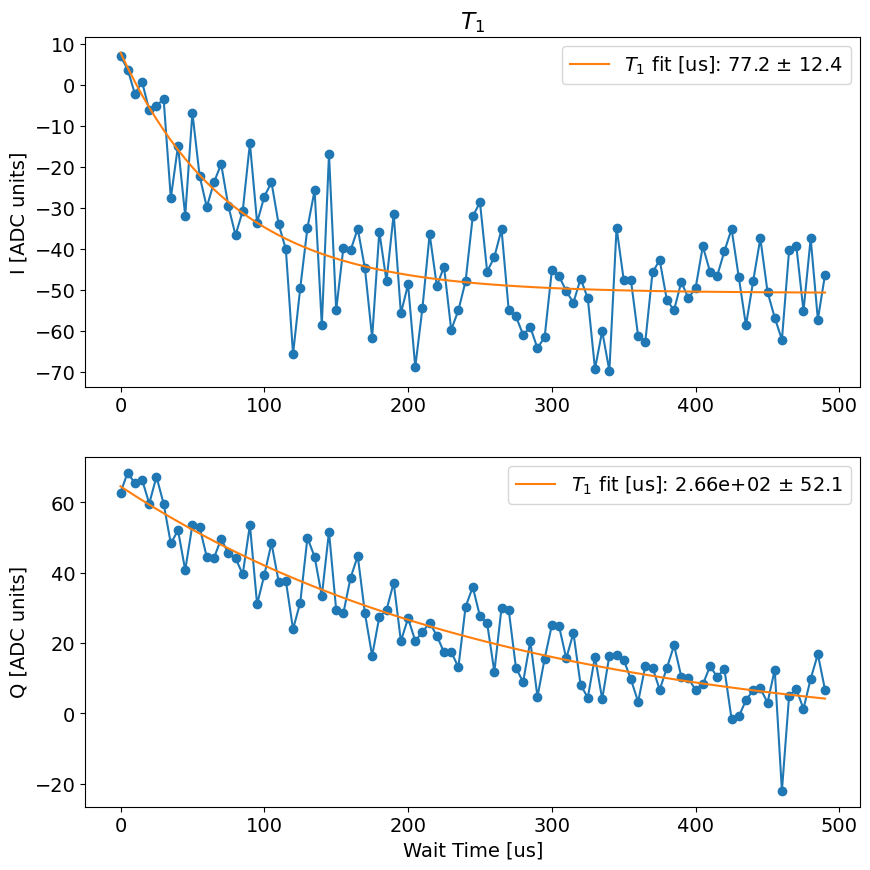

Fit T1 avgi [us]: 77.17025548374696
Fit T1 avgq [us]: 265.5293373883321


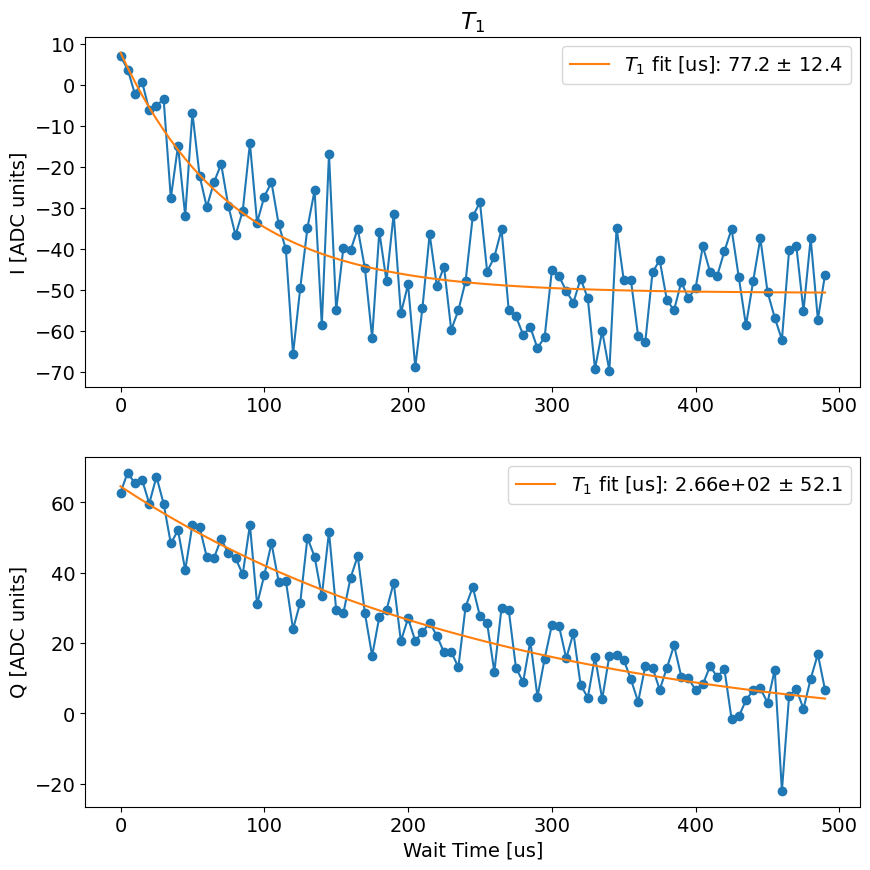

Updated qubit T1!
T1 done!


In [70]:
t1_ef = None
if expts_to_run['t1_ef']:
    t1 = do_t1_ef(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ef(t1, config_thisrun)
    print('T1 done!')

# Manipulate

## Spectroscopy

In [93]:
def do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = 1): 

    qspec = meas.single_qubit.pulse_probe_f0g1_spectroscopy.PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {
        'start': ds_thisrun.get_freq('M' + str(man_mode_no)) - 10,  # resonator frequency to be mixed up [MHz]
        'step': 0.1,  # min step ~1 MHz
        'expts': 200,  # Number of experiments stepping from start
        'reps': 100,  # Number of averages per point
        'rounds': 1,  # Number of start to finish sweeps to average over
        'length': 1,  # ef probe constant pulse length [us]
        'gain': 3000,  # f0g1 pulse gain
        'pulse_type': 'gaussian',
        'qubit_f': True,
        'qubits': [0],
        'prepulse': False,
        # 'pre_sweep_pulse': [[3569.4827896982997], [11161], [0], [0], [2], ['g'], [0.035]]
    }

    qspec.cfg.device.readout.relax_delay = [200] # Wait time between experiments [us]
    qspec.go(analyze=False, display=False, progress=True, save=True)
    return qspec

def analyze_and_display_pulse_probe_f0g1(qspec):
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(
        qspec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()

def update_pulse_probe_f0g1(qspec, config_thisrun, man_mode_no = 1):
    ''' 
    Update the configuration based on f0g1 spectroscopy experiment results.
    man_mode_no: 1 for man1, 2 for man2
    '''
    ds_thisrun.update_freq('M' + str(man_mode_no),  qspec.data['fit_avgi'][2])
    config_thisrun.device.multiphoton['pi']['fn-gn+1']['frequency'][0] = qspec.data['fit_avgi'][2]


    print('Updated man f0g1 freq to :', ds_thisrun.get_freq('M1'))


Running pulse probe f0g1 for mode 1


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00001_PulseProbeF0g1SpectroscopyExperiment.h5
Found peak in amps at [MHz] 2014.954954737453, HWHM -0.3946979935027934
Found peak in I at [MHz] 2014.962941867235, HWHM 0.43915752817843945
Found peak in Q at [MHz] 2015.0133024455104, HWHM -0.4574429852324826


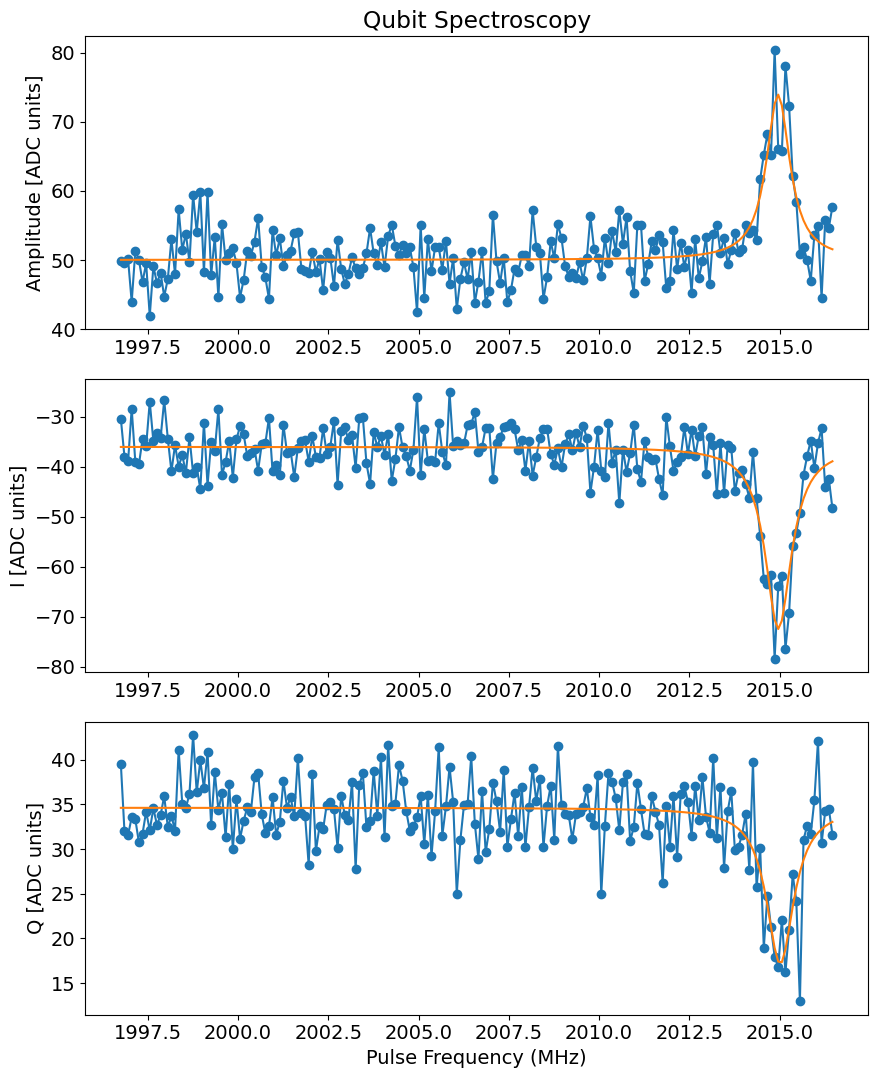

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated man f0g1 freq to : 2014.962941867235


In [94]:
# expts_to_run['pulse_probe_f0g1'] = True

man_specs =[None]* len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):

    if expts_to_run['pulse_probe_f0g1']:

        print('Running pulse probe f0g1 for mode', i+1)
        man_specs[i] = do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = i+1)
        analyze_and_display_pulse_probe_f0g1(man_specs[i])
        update_pulse_probe_f0g1(man_specs[i], config_thisrun, man_mode_no=i+1)
        
        

## Find Frequency (Chevron)


In [95]:
def do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step):
    """Run the Length Rabi General F0g1 Experiment Sweep."""
    # length_rabi = meas.single_qubit.length_rabi.LengthRabiGeneralF0g1ExperimentSweep(
    #     soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1ExperimentSweep', config_file=config_path
    # )
    from multimode_expts.sequential_experiment_classes import man_f0g1_class
    experiment_class = man_f0g1_class
    sweep_experiment_name = 'length_rabi_f0g1_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path,
                                      exp_param_file=exp_param_file, config_thisrun=config_thisrun)

    # class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] = {
        'freq_start': freq_start,
        'freq_stop':  freq_stop,
        'freq_step': freq_step,
        'start': 2,
        'step': 0.1,
        'qubits': [0],
        'expts': 25,
        'reps': 100,
        'rounds': 1,
        'gain': 8000,
        'ramp_sigma': 0.005,
        'use_arb_waveform': False,
        'pi_ge_before': True,
        'pi_ef_before': True,
        'pi_ge_after': False,
        'normalize': False,
        'active_reset': False,
        'check_man_reset': [False, 0],
        'check_man_reset_pi': [],
        'prepulse': False,
        'pre_sweep_pulse': [],
        'err_amp_reps' : 0, # Number of error amp rounds
    } # actually this doesn't do anything, edit experiment.yml
    
 
    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

def update_length_rabi_f0g1_sweep(expt_path, prefix, config_thisrun, man_mode_no = 1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix=prefix)
    print('File saved at :', filename)
    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi'],
        config = config_thisrun
    )
    chevron_analysis.analyze()
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True,  title=f'M{man_mode_no}_{current_time}')

    #config_thisrun.device.manipulate.f0g1_freq[0] = chevron_analysis.results['frequency']
    ds_thisrun.update_freq('M' + str(man_mode_no), chevron_analysis.results['best_frequency_contrast'])
    config_thisrun.device.multiphoton['pi']['fn-gn+1']['frequency'][0] = chevron_analysis.results['best_frequency_contrast']
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis


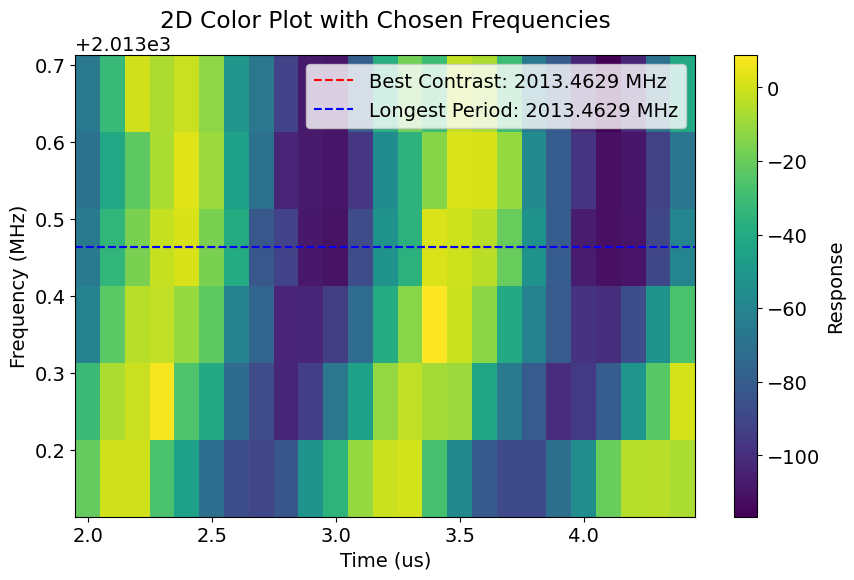

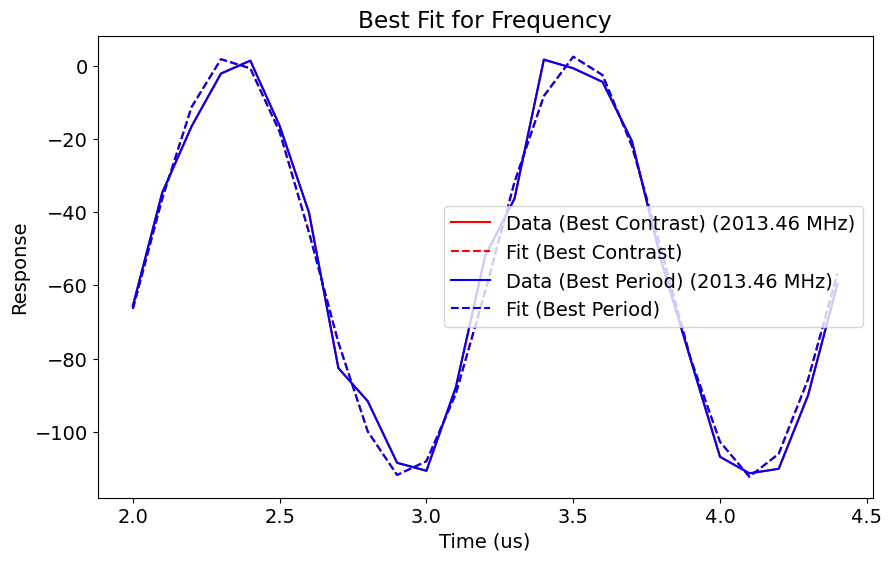

File saved at : D:\experiments\251111_qec\data\00003_length_rabi_f0g1_sweep.h5
supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_11-15-32_M1_2025-11-11_11-15-32.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md


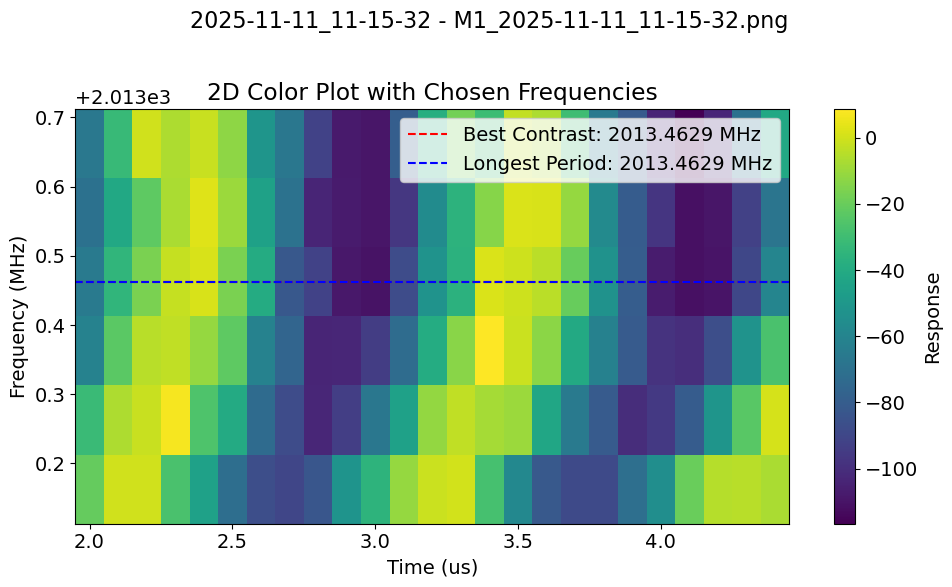

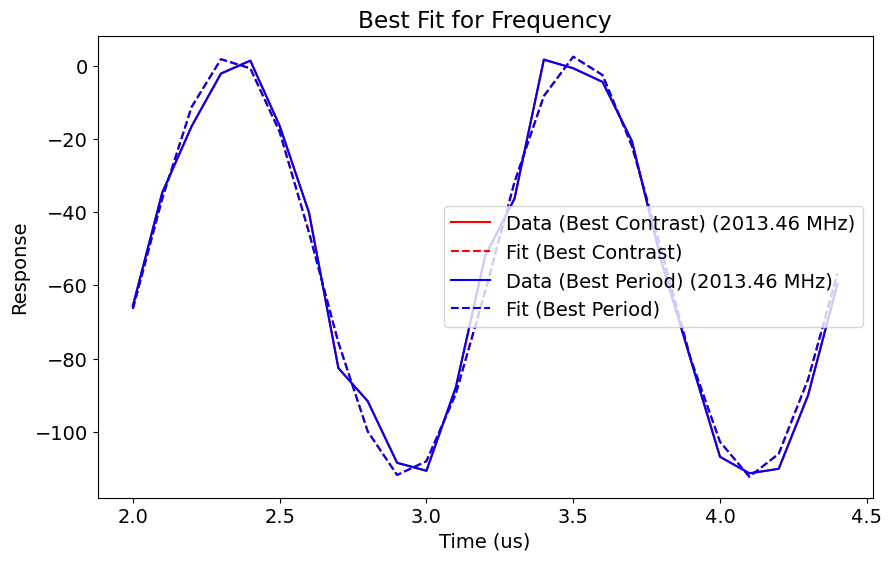

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the frequency to: 2013.4629418672346


In [96]:
man_chevrons_coarse = [None] * len(expts_to_run['man_modes'])
man_chevrons_fine = [None] * len(expts_to_run['man_modes'])
# man_sweeps = [None] * len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi_sweep']:
        print(f'Running coarse length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 3
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 3
        freq_step = 0.3
        man_chevrons_coarse[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

        print(f'Running fine length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 0.3
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 0.3
        # freq_start = 2017
        # freq_stop = 2021
        freq_step = 0.1
        # freq_step = 1.
        man_chevrons_fine[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

## Error amplification

In [103]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_calib = MM_dual_rail_base(config_thisrun, ds_thisrun)

sideband = 'f0-g1'
_sideband = sideband[0] + 'n' + '-' + sideband[3] + 'n+1'
i = int(sideband[1])
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=i)
print(f"pre_sweep_pulse: {pre_sweep_pulse}")
pre_sweep_pulse.append(['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0])
pre_sweep_pulse.append(['multiphoton', 'e'+str(i)+'-f'+str(i), 'pi', 0])
# pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, multiphoton_cfg_thisrun).pulse.tolist()
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, config_thisrun).pulse.tolist()
# print(f"pre_sweep_pulse: {pre_sweep_pulse}")

pre_sweep_pulse: []


In [104]:
def do_error_amplification(
    config_thisrun,
    expt_path,
    config_path,
    reps=100,
    rounds=1,
    qubit=0,
    n_pulses=10,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500, 
    start = 0,
    expts = 10,
    step = 100,
    parameter_to_test = 'gain',
    pulse_type=['qubit', 'ge', 'pi', 0],
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    expt_cfg = {
        'reps': reps,
        'qubit': qubit,
        'qubits': [qubit],
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'start': start,
        'expts': expts,
        'step': step,
        'n_pulses': n_pulses,
        'pulse_type': pulse_type,
        'parameter_to_test': parameter_to_test,
        'rounds': rounds,

    }
    error_amp_exp = meas.single_qubit.error_amplification.ErrorAmplificationExperiment(
    soccfg=soc, path=expt_path,
      prefix='ErrorAmplificationExperiment', config_file=config_path)
    error_amp_exp.cfg = AttrDict(deepcopy(config_thisrun))
    error_amp_exp.cfg.expt = expt_cfg
    error_amp_exp.go(analyze=False, display=False, progress=True, save=True)
    return error_amp_exp

In [105]:
config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i]

2013.5177189015562

In [100]:
expts = 20
# band = 0.75
band = 0.3
# config_thisrun.device.multiphoton['pi'][_sideband]['length'][0] = 0.5491206701698654
freq_start = config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i] - band
# freq_start = 2011 - band
step = 2 * band / expts
print(f'Frequency start: {freq_start}, Step: {step}')

err_amp_man_freq = do_error_amplification(
    config_thisrun=config_thisrun,
    expt_path=expt_path,
    config_path=config_file,
    reps=250,
    rounds=1,
    n_pulses = 7,
    expts=expts,
    start=freq_start,
    step=step,
    pulse_type=['multiphoton', sideband, 'pi', 0],
    parameter_to_test='frequency',
)

Frequency start: 2013.1629418672346, Step: 0.03
cfg at start of acquire {'reps': 250, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 2013.1629418672346, 'expts': 20, 'step': 0.03, 'n_pulses': 7, 'pulse_type': ['multiphoton', 'f0-g1', 'pi', 0], 'parameter_to_test': 'frequency', 'rounds': 1}
n_pts [1 2 3 4 5 6 7]


  0%|          | 0/7 [00:00<?, ?it/s]

post_pulse: [[3570.1569917242878, 3426.533540542471], [3523, 2909], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3570.1569917242878, 3426.533540542471], [3523, 2909], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3570.1569917242878, 3426.533540542471], [3523, 2909], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3570.1569917242878, 3426.533540542471], [3523, 2909], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3570.1569917242878, 3426.533540542471], [3523, 2909], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3570.1569917242878, 3426.533540542471], [3523, 2909], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3570.1569917242878, 3426.533540542471], [3523, 2909], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
Saving D:\experiments\251111_qec\data\00001_ErrorAmplificationExperiment.h5


fitparams [0.00010211183746758355, 0.9998978881625324, 2013.5229418672345, 0.05699999999999363]


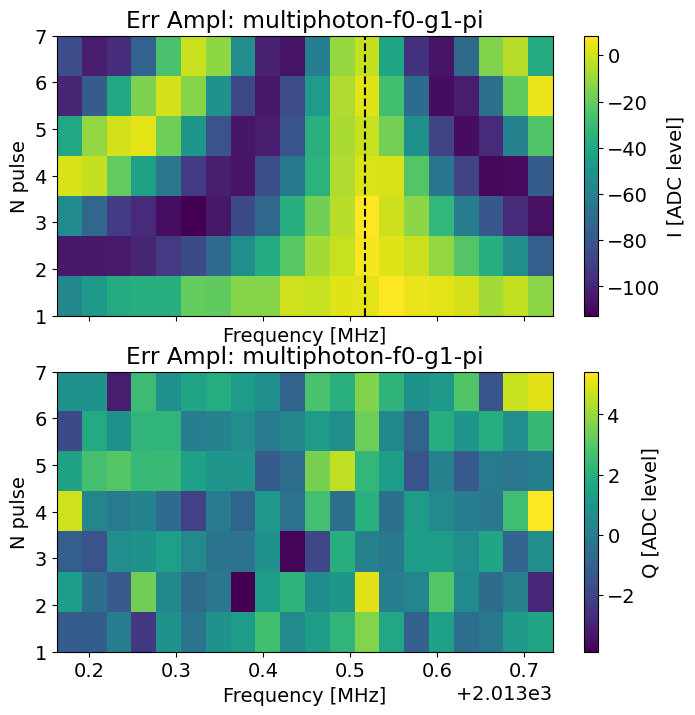

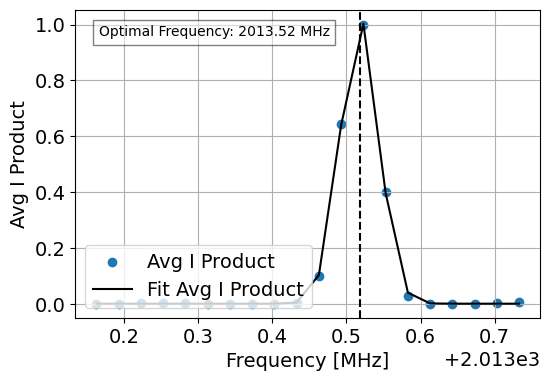

In [101]:
err_amp_man_freq.analyze(state_fin='e')
err_amp_man_freq.display()

In [102]:
print(f"Man {sideband} pi frequency before update:", config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i])
config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i] = err_amp_man_freq.data['fit_avgi'][2]
print(f"Man {sideband} pi frequency after update:", config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i])

Man f0-g1 pi frequency before update: 2013.4629418672346
Man f0-g1 pi frequency after update: 2013.5177189015562


In [106]:
if i > 0:
    print("WARNING! No update will occur! The update in this cell was meant for the csv which does not have multiphoton params. To update the multiphoton params, please run the multiphoton calibration notebook instead.")
else:
    ds_thisrun.update_freq('M1', err_amp_man_freq.data['fit_avgi'][2])
    print("Updated the ds_thisrun frequency to:", ds_thisrun.get_freq('M1'))

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the ds_thisrun frequency to: 2013.5177189015562


## Length Rabi f0g1 (Update time)

In [107]:
def do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 Experiment."""
    length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
    )

    length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

    length_rabi.cfg.expt = dict(
        start=soc.cycles2us(3),  # Pulse start length [us]
        step=0.01,  # Pulse step length [us]
        qubits=[0],
        expts=150,
        reps=100,
        rounds=1,
        # rep_start=0, # 0 means just 1 pi pulse, no error amp
        # rep_end=19, # will do 1+2*rep_end rounds of pi pulses max
        gain=8000,  # Qubit gain [DAC units]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ge_after=True,
        # pi_ef_after=True,
        normalize=False,
        active_reset=False,
        man_reset=True,
        stor_reset=True,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[],
        err_amp_reps = 0, # Number of error amp rounds
    )

    length_rabi.cfg.device.readout.relax_delay = [5000]  # Wait time between experiments [us]
    length_rabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import LengthRabiFitting
    # Analyze the data
    length_rabi_analysis = LengthRabiFitting(length_rabi.data, config = length_rabi.cfg)
    length_rabi_analysis.analyze()
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')


    return length_rabi_analysis


def update_length_rabi_f0g1_combined(length_rabi, config_thisrun, ds, man_mode_no = 1):
    """Update the configuration and dataset based on Length Rabi General F0g1 experiment results."""

    # Update dataset
    pi_length = length_rabi.results['pi_length']
    pi2_length = length_rabi.results['pi2_length']
    gain = length_rabi.cfg.expt['gain']
    freq = length_rabi.cfg.expt['freq']
    ds.update_all('M' + str(man_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



Running length rabi for mode 1


  0%|          | 0/150 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00001_LengthRabiGeneralF0g1Experiment.h5
p1: 0.8410843305550407
p2: 93.29596789713493
Pi length: 0.5835853977866358
Pi/2 length: 0.28635004228426625
p1: 0.7341700489586847
p2: 116.31614857024528
Pi length: 0.5814723549542375
Pi/2 length: 0.24095178978736742


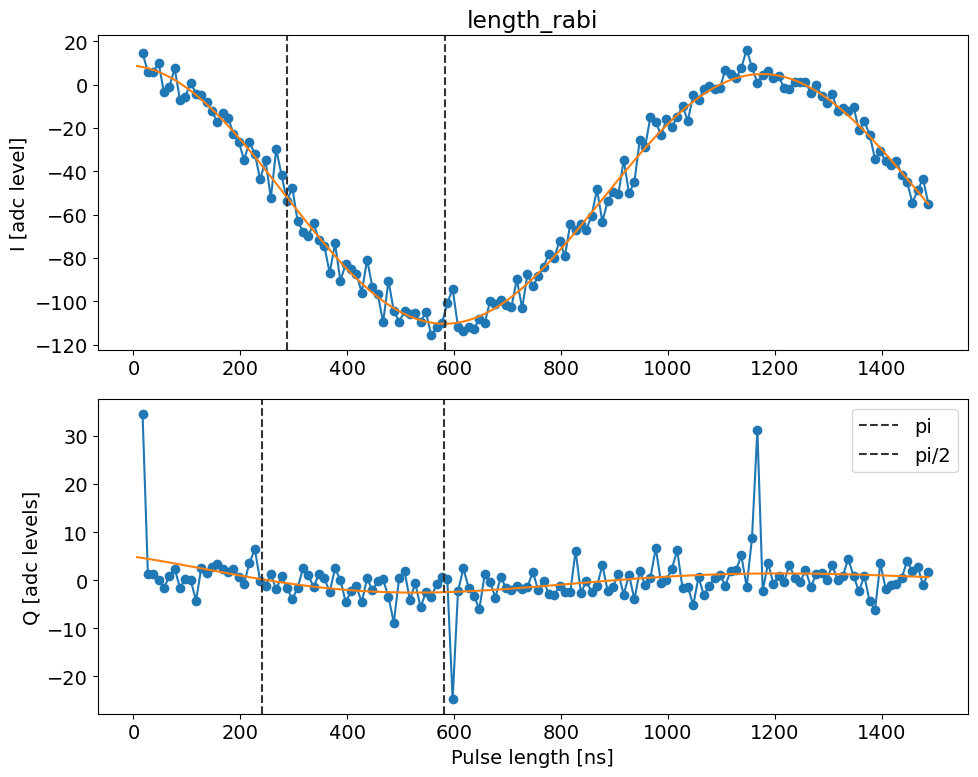

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_11-20-08_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md
Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated dataset: pi_length=0.5835853977866358, pi2_length=0.28635004228426625, gain=8000


In [108]:
len_rabis_mans = [None]* len(expts_to_run['man_modes'])
for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi'] or expts_to_run['length_rabi_sweep']:
        print('Running length rabi for mode', i+1)
        len_rabis_mans[i] = do_length_rabi_f0g1_general(config_thisrun, 
                                                        ds_thisrun, 
                                                        expt_path, 
                                                        config_path, 
                                                        man_mode_no= i+1)
        update_length_rabi_f0g1_combined(len_rabis_mans[i], config_thisrun, ds_thisrun, man_mode_no= i+1)

In [109]:
# len_rabis_mans[0].active_reset = True
# len_rabis_mans[0].analyze()
# len_rabis_mans[0].display(title_str='Length Rabi General F0g1')

### Quick and dirty error amplification

Very slightly modified length rabi f0g1 general (see git)

In [ ]:
def length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_pi('M1')-soc.cycles2us(1)*50,  # Pulse start length [us]
        step=soc.cycles2us(1),  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        rep_start=0, # 0 means just 1 pi pulse, no error amp
        rep_end=19, # will do 1+2*rep_end rounds of pi pulses max
        gain=15000,  # Qubit gain [DAC units]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
        )

        length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        length_rabi.cfg.expt = expt_cfg

        length_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        length_rabi.go(analyze=False, display=False, progress=False, save=True)
    return length_rabi

In [ ]:
# length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)

In [ ]:
# lines = []
# ypts = []
# for prefix_num in range(43,63):
#     fname = f'{prefix_num:05d}_LengthRabiGeneralF0g1Experiment.h5'
#     temp_data, attrs, filename = prev_data(expt_path, fname)
#     ypts.append(attrs['config']['expt']['err_amp_reps'])
#     lines.append(temp_data['avgi'])
    
# xpts = temp_data['xpts']
# ypts = np.array(ypts)
# lines = np.array(lines)

# import matplotlib.pyplot as plt


# plt.figure(figsize=(8, 6))
# plt.pcolormesh(xpts, ypts, lines, shading='auto', cmap='viridis')
# # add vertical line at dsthisrun.get_pi('M1')
# plt.axvline(x=ds_thisrun.get_pi('M1'), color='r', linestyle='--', label='Old calib Pi Pulse Length')

# # add vertical line where the new calib pi pulse length is
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.axvline(x=xpts[xmax], color='g', linestyle='--', label='New calib Pi Pulse Length')
# # in legend mention the difference between the two
# diff = xpts[xmax] - ds_thisrun.get_pi('M1')
# plt.legend(title=f'ΔPi = {diff:.5f} us')
# plt.xlabel('Pulse Length [us]')
# plt.ylabel('Error Amplification Reps')
# plt.title('Length Rabi Error Amplification')
# plt.colorbar(label='Signal (avgi)')
# plt.show()


In [ ]:
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.plot(lines_processed, marker='o')
# plt.axvline(x=xmax, color='r', linestyle='--')


### and amplitude

In [ ]:
def amp_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_gain(f'M{man_mode_no}')-50*50,  # Pulse start length [dac unit]
        step=50,  # Pulse step length [dac unit]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        rep_start=0,
        rep_end=19,
        # gain=15000,  # Qubit gain [DAC units]
        ramp_sigma=0.005,  # Ramp sigma [us]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        length= ds_thisrun.get_pi(f'M{man_mode_no}'),
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        amp_rabi = meas.single_qubit.amplitude_rabi_f0g1_general.AmplitudeRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='AmplitudeRabiGeneralF0g1Experiment', config_file=config_path
        )

        amp_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        amp_rabi.cfg.expt = expt_cfg

        amp_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        amp_rabi.go(analyze=False, display=False, progress=False, save=True)
    return amp_rabi

In [ ]:
# amp_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)
    # 

In [ ]:
# lines = []
# ypts = []
# for prefix_num in range(15,35):
#     fname = f'{prefix_num:05d}_AmplitudeRabiGeneralF0g1Experiment.h5'
#     temp_data, attrs, filename = prev_data(expt_path, fname)
#     lines.append(temp_data['avgi'])
#     ypts.append(attrs['config']['expt']['err_amp_reps'])
# xpts = temp_data['xpts']

# lines = np.array(lines)
# ypts = np.array(ypts)

# plt.figure(figsize=(8, 6))
# plt.pcolormesh(xpts, ypts, lines, shading='auto', cmap='viridis')
# plt.axvline(x=ds_thisrun.get_gain('M1'), color='r', linestyle='--', label='Old calib Gain')
# plt.xlabel('Pulse Length [us]')
# plt.ylabel('Error Amplification Reps')
# plt.title('Amplitude Rabi Error Amplification')
# plt.colorbar(label='Signal (avgi)')
# plt.legend()
# plt.show()

In [ ]:
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.plot(lines_processed, marker='o')
# plt.axvline(x=xmax, color='r', linestyle='--')

## Chi between qubit and Manipulate 

### ge

In [85]:
mm_base_dummy = MM_dual_rail_base(config_thisrun, soc)
prep_man_pi = mm_base_dummy.prep_man_photon(1)
mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse

array([[3570.1569917242878, 3426.533540542471, 2006.6594442381024],
       [3523, 2909, 8000],
       [0, 0, 0.5884878240625507],
       [0, 0, 0],
       [2, 2, 0],
       ['gauss', 'gauss', 'flat_top'],
       [0.035, 0.035, 0.005]], dtype=object)

In [86]:
from MM_dual_rail_base import MM_dual_rail_base
import numpy as np

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
# do_t2_ramsey_ge is already defined in previous cells and can be used directly

# Add active_reset, relax_delay, expts as arguments and pass them to do_t2_ramsey_ge
def do_chi(config_thisrun, expt_path, config_path, prepulse=None, standard_ramsey=True,
           man_mode_no=1, active_reset=False, relax_delay=2500, expts=100):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """
    # Standard Ramsey (no prepulse)
    if standard_ramsey:
        t2ramsey_no_prepulse = do_t2_ramsey_ge(
            config_thisrun, expt_path, config_path,
            pre_sweep_pulse=None, post_sweep_pulse=None,
            step_size=0.1,
            active_reset=active_reset,
            relax_delay=relax_delay,
            expts=expts
        )
    else: 
        t2ramsey_no_prepulse = None

    # Ramsey with prepulse (initialize manipulation mode 1)
    if prepulse is None:
        mm_base_dummy = MM_dual_rail_base(config_thisrun, soc)
        prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
        prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

    t2ramsey_with_prepulse = do_t2_ramsey_ge(
        config_thisrun, expt_path, config_path,
        pre_sweep_pulse=prepulse, post_sweep_pulse=None,
        step_size=0.1,
        active_reset=active_reset,
        relax_delay=relax_delay,
        expts=expts
    )

    return t2ramsey_no_prepulse, t2ramsey_with_prepulse


def update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_without_prepulse = t2_ramsey_original.data['f_adjust_ramsey_avgi'][0]
    f_with_prepulse = t2_ramsey_prepulse.data['f_adjust_ramsey_avgi'][0]
    chi = f_with_prepulse - f_without_prepulse
    print('Chi:', chi)
    config_thisrun.device.manipulate.chi_ge[man_mode_no - 1] = chi
    config_thisrun.device.manipulate.revival_time[man_mode_no-1] = np.abs(np.pi/(2 * np.pi * chi))
    print('Delay time (mus):', config_thisrun.device.manipulate.revival_time[man_mode_no-1] )


fge is  3569.7141623787825
fef is  3426.6982208338936


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00004_RamseyExperiment.h5
fge is  3569.7141623787825
fef is  3426.6982208338936


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00005_RamseyExperiment.h5
No echoes in the data
Attempted to init fitparam 4 to -52.724925000000006, which is out of bounds -27.571309523809525 to 4.514718614718615. Instead init to -11.528295454545455
Current pi pulse frequency: 3569.7141623787825
Fit frequency from I [MHz]: 2.0 +/- inf
Suggested new pi pulse frequency from fit I [MHz]:
 	3570.7141623787825
 	3574.7141623787825
T2 Ramsey from fit I [us]: 9.9
Fit frequency from Q [MHz]: 2.076533826954893 +/- 0.024749944810192936
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3570.6376285518277
 	3574.7906962057373
T2 Ramsey from fit Q [us]: 2.9700000000000006


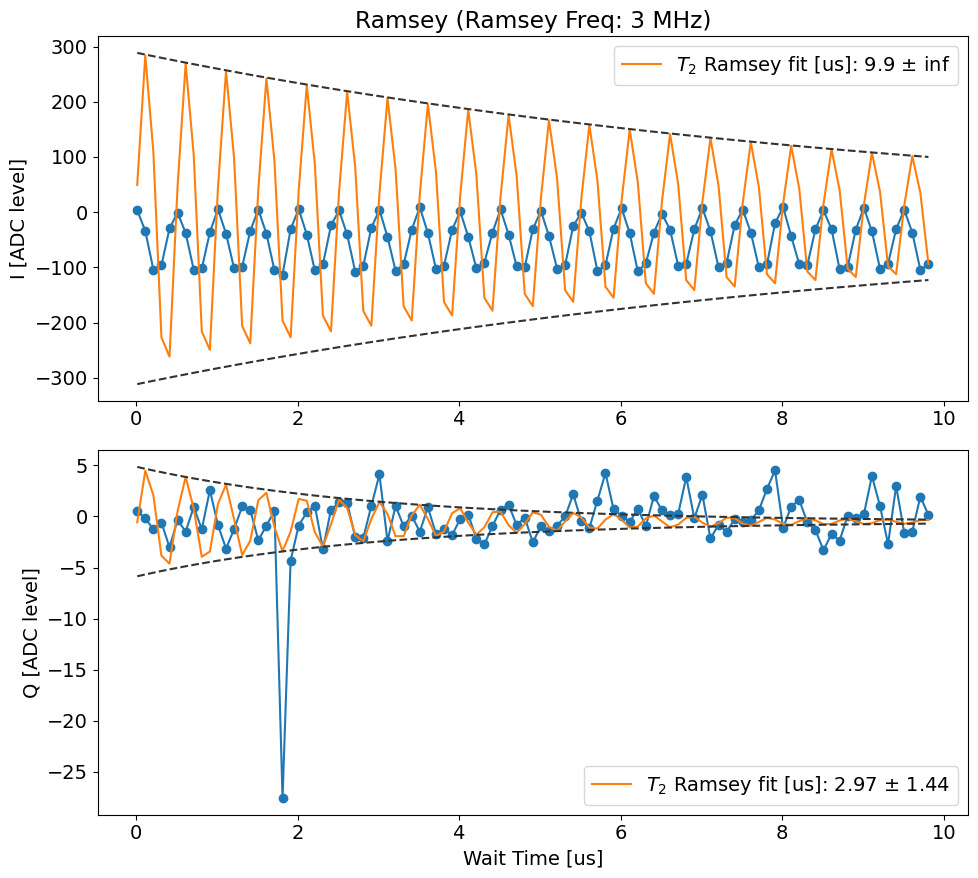

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_10-59-59_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md
No echoes in the data
Attempted to init fitparam 4 to -51.17035303030303, which is out of bounds -3.31245670995671 to 8.356028138528139. Instead init to 2.5217857142857145
Current pi pulse frequency: 3569.7141623787825
Fit frequency from I [MHz]: 1.71978267183764 +/- 0.0012380111575450356
Suggested new pi pulse frequency from fit I [MHz]:
 	3570.994379706945
 	3574.43394505062
T2 Ramsey from fit I [us]: 14.777506484792996
Fit frequency from Q [MHz]: 1.7361956078739427 +/- 0.01620406466299428
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3570.9779667709086
 	3574.4503579866564
T2 Ramsey from fit Q [us]: 2.9700000000000006


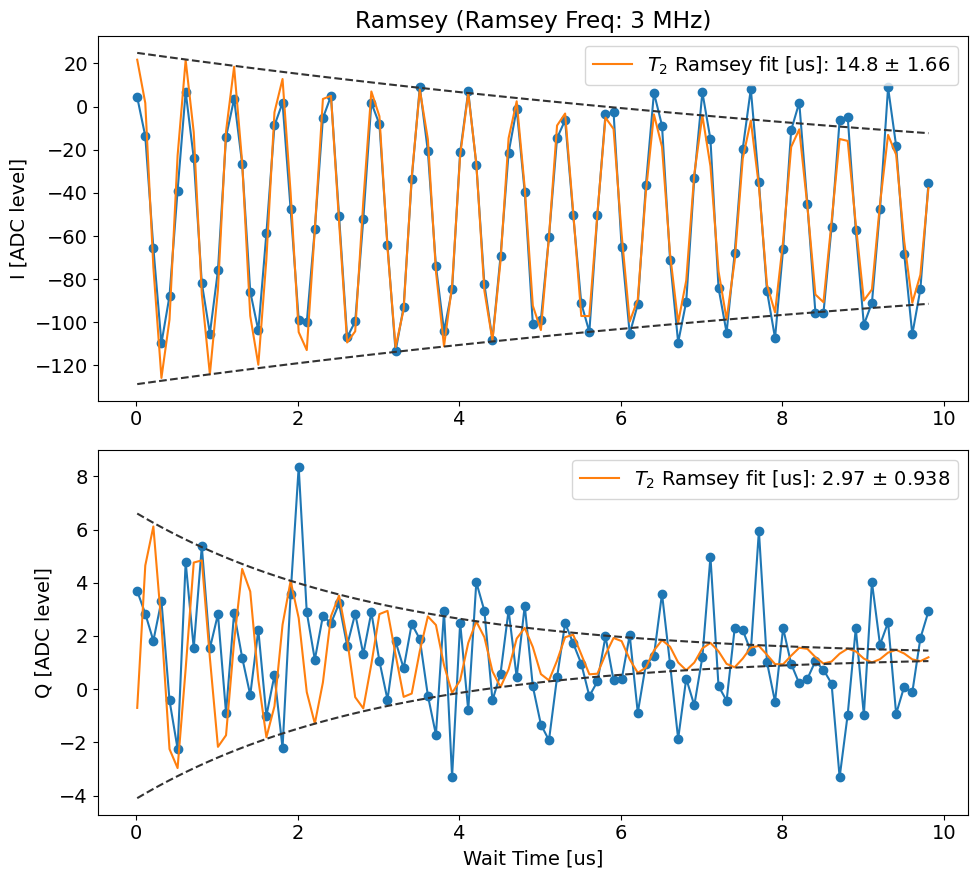

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_11-00-00_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md
Chi: 0.2802173281623599
Delay time (mus): 1.7843293392273603
Only doing it for mode 1


In [87]:
t2_ramsey_original, t2_ramsey_prepulse = None, None
# Run the chi experiments/__pycache__/
if expts_to_run['chi_ge']:
    t2_ramsey_original, t2_ramsey_prepulse = do_chi(config_thisrun, expt_path, config_path, standard_ramsey=True)
    # analyze and display the results
    t2_ramsey_original.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_original.display()
    t2_ramsey_prepulse.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_prepulse.display() 
    # update the config_thisrun with the chi value
    update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1)
    print('Only doing it for mode 1')

In [ ]:
# config_thisrun.device.manipulate.revival_time[0] = np.pi/(2 * np.pi * config_thisrun.device.manipulate.chi[0])

### ef

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
def do_chi_f(config_thisrun, expt_path, config_path, 
           man_mode_no=1):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """

    
    mm_base_dummy = MM_dual_rail_base(config_thisrun, soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    # Add qubit ge prepulse and postpulse for ef (ge init)
    qubit_ge_prepulse = [['qubit', 'ge', 'pi', 0]]
    prep_man_pi_prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    prepulse =  mm_base_dummy.get_prepulse_creator(prep_man_pi + qubit_ge_prepulse ).pulse.tolist() 
    postpulse  = mm_base_dummy.get_prepulse_creator(qubit_ge_prepulse).pulse.tolist()

    # Add chi to frequency of qubit ge 
    # prepulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]
    # postpulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]

    # Do an ef and ge ramsey with this prepulse 
    # Run ge Ramsey 
    
    
    t2ramsey_no_prepulse_ge = do_t2_ramsey_ge(config_thisrun,
        expt_path,
        config_path,
        step_size=0.1,
        pre_sweep_pulse=prep_man_pi_prepulse,
        post_sweep_pulse=None)
    # Run ef Ramsey with prepulse and postpulse
    t2ramsey_with_prepulse_ef = do_t2_ramsey_ef(
        config_thisrun,
        expt_path,
        config_path,
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
        step_size=0.1,
        ef_init=False  # Do not initialize ef, we are already in ef state
    )
    

    return t2ramsey_no_prepulse_ge, t2ramsey_with_prepulse_ef

def update_chi_ef(t2_standard_ramsey, t2_prepulsed_ramsey, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_with_prepulse = t2_prepulsed_ramsey.data['f_adjust_ramsey_avgi'][0]
    f_without_prepulse = t2_standard_ramsey.data['f_adjust_ramsey_avgi'][0]
    chi_ef = f_with_prepulse - f_without_prepulse
    print('Chi:', chi_ef)
    config_thisrun.device.manipulate.chi_ef[man_mode_no - 1] = chi_ef


In [ ]:
man_mode_no = 1
t2ge_ramsey_forchief, t2ef_ramsey_forchief = None, None
t2ef_standard_ramsey_forchief = None
if expts_to_run['chi_ef']:
    
    #get standard ef ramsey 
    t2ef_standard_ramsey_forchief = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    # analyze and display the results
    t2ef_standard_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_standard_ramsey_forchief.display(title_str='T2_ef_standard_for_chief')

    # Now ramseys with man photon prepulse
    config_thisrun_chief = deepcopy(config_thisrun)
    config_thisrun_chief.device.qubit.f_ge[0] += config_thisrun.device.manipulate.chi_ge[man_mode_no - 1]
    t2ge_ramsey_forchief, t2ef_ramsey_forchief = do_chi_f(config_thisrun_chief, expt_path, config_path)
    # analyze and display the results
    t2ge_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ge_ramsey_forchief.display(title_str='T2_ge_for_chief_tocheck_this_is_correctly_at_ramsey_freq')
    t2ef_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_ramsey_forchief.display(title_str='T2_ef_for_chief')
    # update the config_thisrun with the chi value
    update_chi_ef(t2ef_standard_ramsey_forchief, t2ef_ramsey_forchief, config_thisrun)


## Parity Delay
NOT Implemented yet: We can use chi to estimate parity waiting time pi/chi but can also fine tune it using this experiment

Basically Length rabi analysis 

## T1

In [ ]:
def do_t1_manipulate(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run T1 experiment for the specified manipulate mode (man_mode_no).
    """
    t1_man = meas.single_qubit.t1_cavity.T1CavityExperiment(
        soccfg=soc, path=expt_path, prefix='T1CavityExperiment', config_file=config_path
    )

    t1_man.cfg = AttrDict(deepcopy(config_thisrun))

    # Set experiment parameters for the specified manipulate mode
    t1_man.cfg.expt = dict(
        start=0,
        step=15,
        expts=60,
        reps=300,
        rounds=1,
        cavity_prepulse=[False, 300, 1.5],
        f0g1_prep=True,
        f0g1_param=[ds_thisrun.get_freq(f'M{man_mode_no}'), ds_thisrun.get_gain(f'M{man_mode_no}'), ds_thisrun.get_pi(f'M{man_mode_no}')],
        resolved_pi=False,
        cavity=man_mode_no,
        qubit=0,
        normalize=False
    )

    t1_man.cfg.device.readout.relax_delay = [2500]
    t1_man.go(analyze=True, display=True, progress=True, save=True)
    return t1_man



In [ ]:
t1_man = do_t1_manipulate(config_thisrun, expt_path, config_path, 1)

## T2
06/19/2025: The code below should use man ramsey directly instead of user defined; user defined is for ramsey where you directly displace manipulate mode  - Eesh

In [ ]:
def do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    cavity_ramsey = meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    # Prepulse and postpulse

    # Set experiment parameters as in the YAML block above
    cavity_ramsey.cfg.expt = dict(
        start=0.01,
        step=0.02*7.5,
        expts=600,
        # ramsey_freq=-3.5,
        ramsey_freq=1.5,
        reps=100,
        rounds=1,
        qubits=[0],
        checkEF=False,
        f0g1_cavity=0,
        init_gf=False,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        user_defined_pulse=[False, ds_thisrun.get_freq(stor_name='M'+ str(man_mode_no)), 
                            ds_thisrun.get_gain(stor_name='M'+ str(man_mode_no)), 0.005, 
                            ds_thisrun.get_pi(stor_name='M'+ str(man_mode_no)), 0],
        parity_meas=False,
        man_mode_no=man_mode_no ,
        storage_ramsey=[False, 2, True],
        man_ramsey=[True, man_mode_no],
        coupler_ramsey=False,
        custom_coupler_pulse=[[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]],
        echoes=[True, 1],
        prepulse=True,
        postpulse=True,
        gate_based = True,
        pre_sweep_pulse= [['qubit', 'ge', 'hpi', 0], ['qubit', 'ef', 'pi', 0]],
        post_sweep_pulse=[['qubit', 'ef', 'pi', 0], ['qubit', 'ge', 'hpi', 0]]
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [2500]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey

cavity_ramsey = do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1)

In [ ]:
cavity_ramsey.analyze(fitparams=[300, None, None, None, None, None])
cavity_ramsey.display()

# Storage

## Stor Spectroscopy

In [25]:
def get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        stor_mode_no: Storage mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    freq = ds_thisrun.get_freq(stor_name)
    gain = ds_thisrun.get_gain(stor_name)
    pi_len = ds_thisrun.get_pi(stor_name)
    h_pi_len = ds_thisrun.get_h_pi(stor_name)
    flux_low_ch = config_thisrun.hw.soc.dacs.flux_low.ch
    flux_high_ch = config_thisrun.hw.soc.dacs.flux_high.ch
    ch = flux_low_ch if freq<1000 else flux_high_ch

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    print("post pulse", prep_man_pi[-1:-3:-1])
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


def do_stor_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, stor_no = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        stor_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, stor_no)
    

    # freq_vec = [350, 520.0579911285631, 695.7378041488772, 
    #         873.2311541399545, 1052.5588166734365, 1244.4712892139971,
    #         1422.105731264597]
    
    # freq = freq_vec[stor_no-1]
    print('freq', freq)

    bw = 20
    expts = 250
    step = bw/expts 

    
    flux_spec.cfg.expt = dict(        # start=freq - 30,  # Start RF frequency [MHz]
        # start=200,  # Start RF frequency [MHz]
        start=freq - bw/2,  # Start RF frequency [MHz]
        step=step,  # Step size [MHz]
        expts=expts,  # Number of experiments
        reps=200,  # Number of averages per point
        qubit=[0],
        # flux_drive=[ch, 1, 1000, 5],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        flux_drive=[ch, 1, 1000, 5],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=True,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec



def analyze_and_display_stor_spectroscopy(flux_spec):
    """Analyze and display results of Flux Spectroscopy F0g1 Experiment."""
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(flux_spec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()


def update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, stor_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-S{stor_no}: {flux_spec.data['fit_avgi'][2]}")


Running flux spectroscopy f0g1 for mode 1
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
freq 352.9288626781636


  0%|          | 0/250 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00022_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 350.38181678331557, HWHM 0.1545620191074692
Found peak in I at [MHz] 352.94974892655034, HWHM 0.29118906001308803
Found peak in Q at [MHz] 349.7371354760484, HWHM 1.1724510007421272


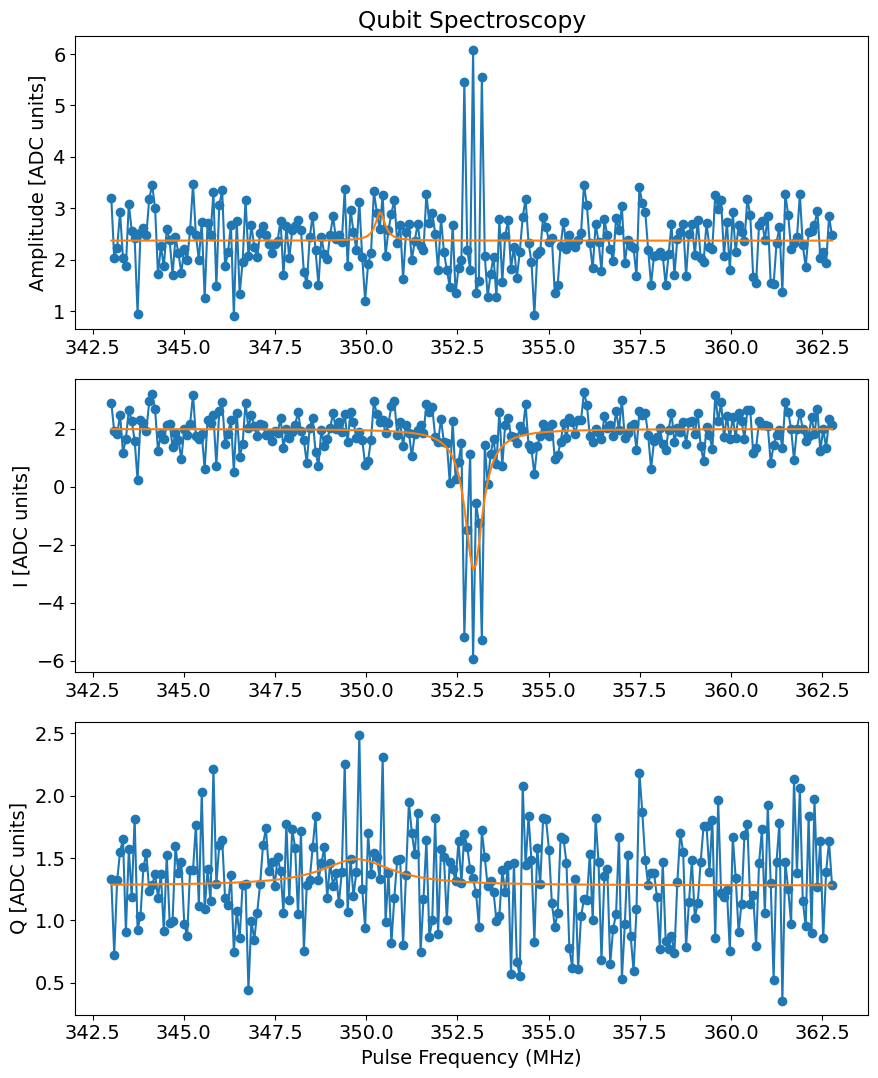

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated frequency for M1-S1: 352.94974892655034
Running flux spectroscopy f0g1 for mode 2
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
freq 524.7797819205764


  0%|          | 0/250 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00023_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 524.6197819205764, HWHM 1.975999999999999
Found peak in I at [MHz] 524.6604930800365, HWHM 0.05369330393844405
Found peak in Q at [MHz] 523.1481050551247, HWHM -0.8621270808323788


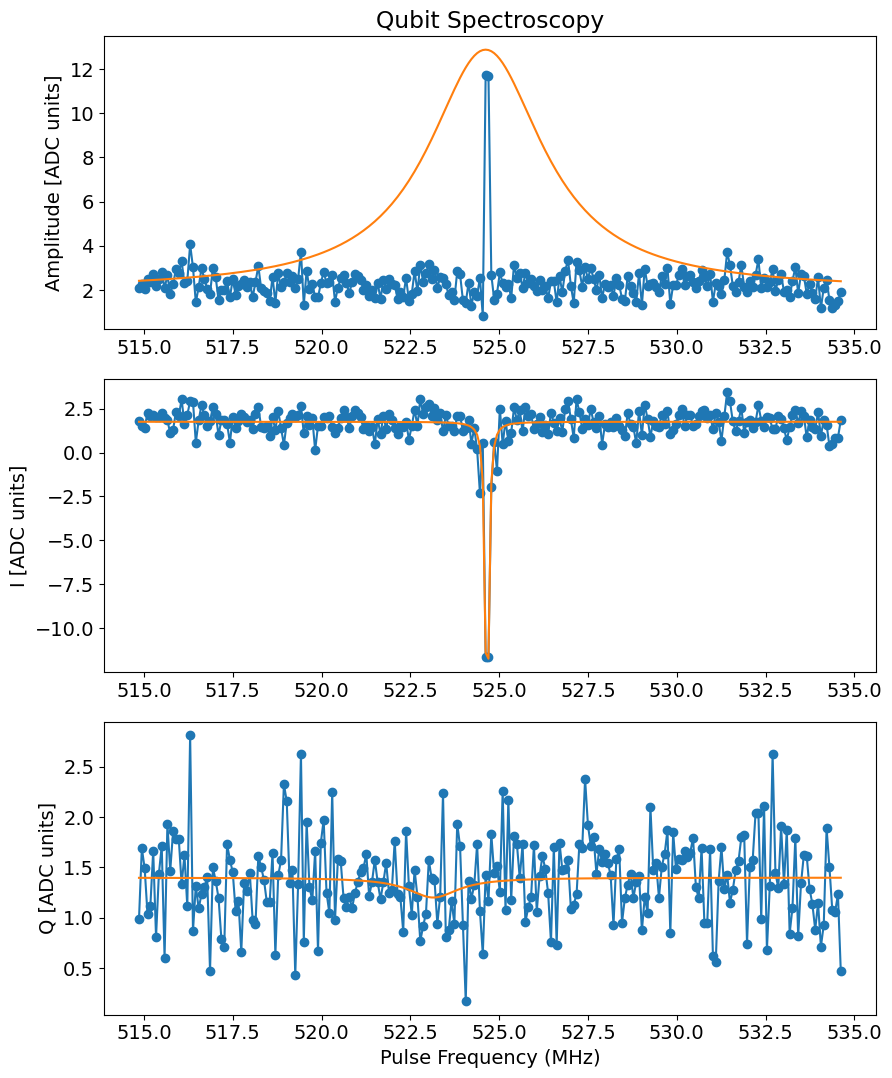

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated frequency for M1-S2: 524.6604930800365
Running flux spectroscopy f0g1 for mode 3
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
freq 700.9295967622894


  0%|          | 0/250 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00024_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 701.0095967622894, HWHM 1.975999999999999
Found peak in I at [MHz] 700.969789988974, HWHM -0.04896756877404441
Found peak in Q at [MHz] 695.9312820984201, HWHM 0.17555856690770197


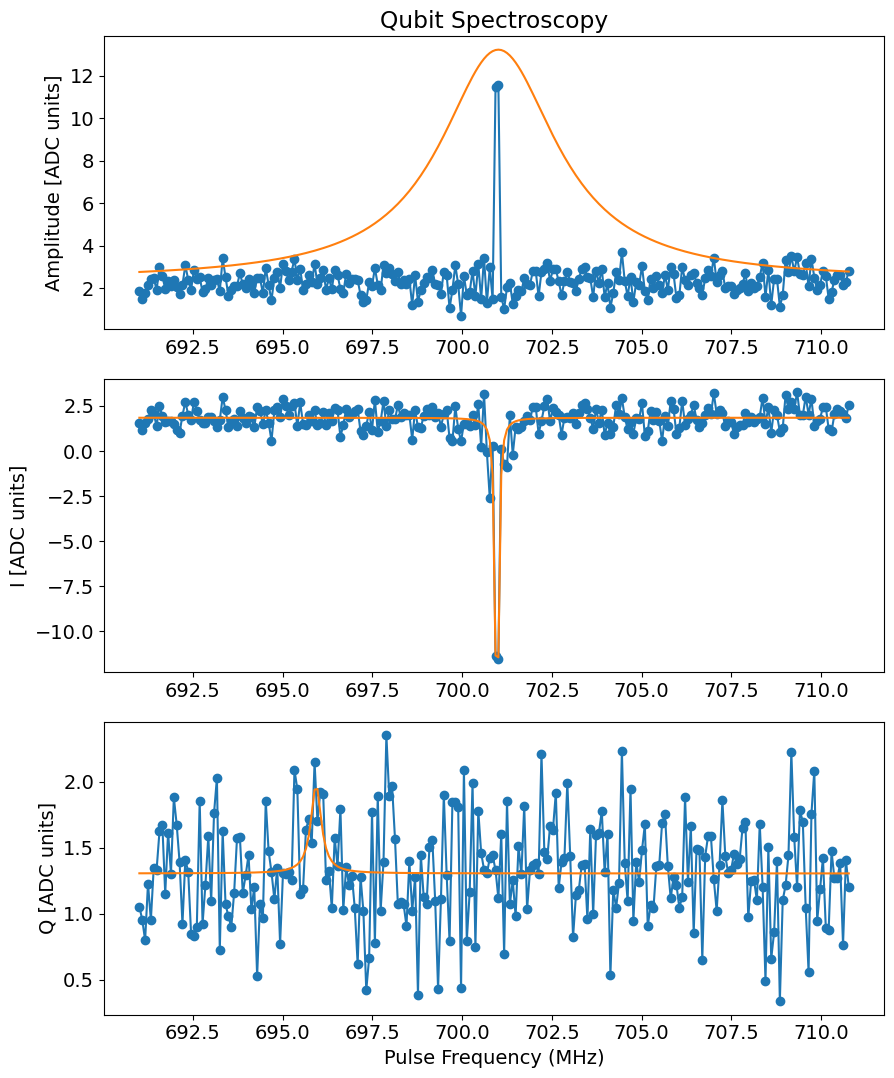

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated frequency for M1-S3: 700.969789988974
Running flux spectroscopy f0g1 for mode 4
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
freq 880.8921960302954


  0%|          | 0/250 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00025_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 880.8121960302954, HWHM 1.975999999999999
Found peak in I at [MHz] 880.8464247026541, HWHM -0.05303941488721549
Found peak in Q at [MHz] 890.5292694469405, HWHM 0.0029270604790887704


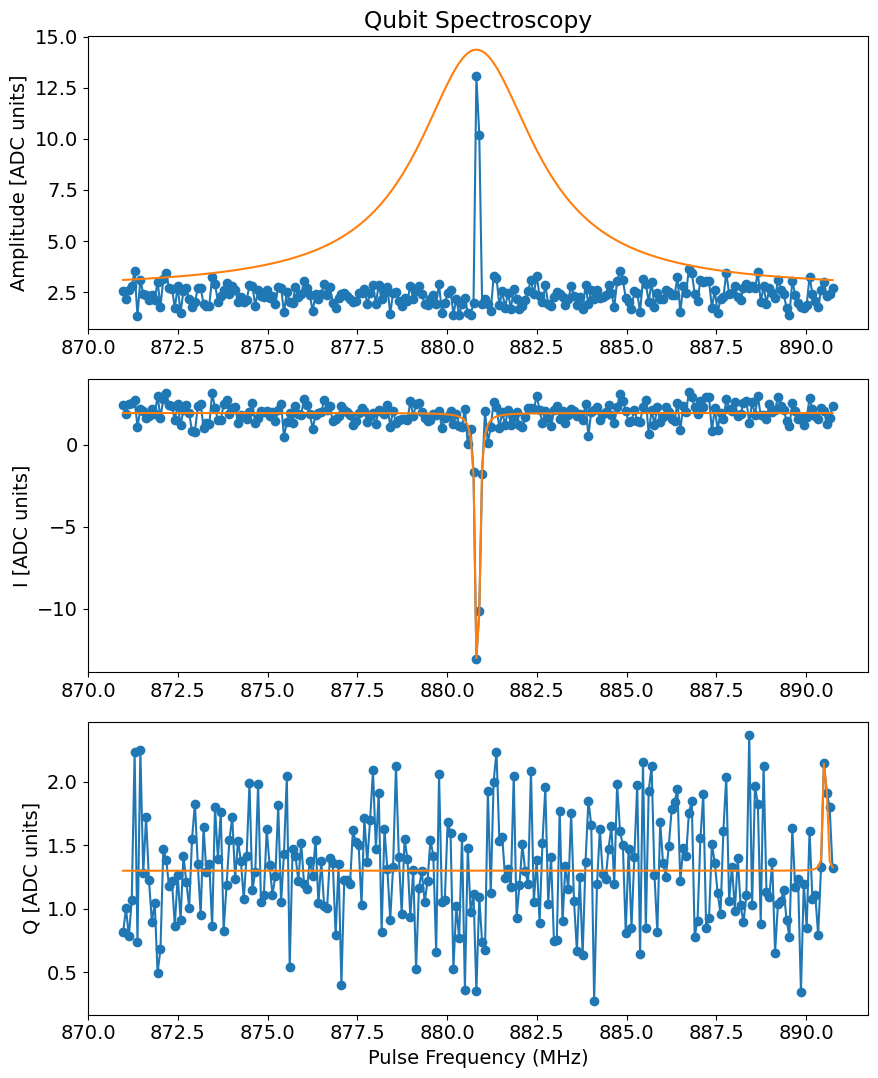

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated frequency for M1-S4: 880.8464247026541
Running flux spectroscopy f0g1 for mode 5
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
freq 1057.1973166067469


  0%|          | 0/250 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00026_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1057.117316606747, HWHM 1.975999999999999
Found peak in I at [MHz] 1057.153984102207, HWHM -0.054045584479589785
Found peak in Q at [MHz] 1064.2778752914799, HWHM 0.04749395600402128


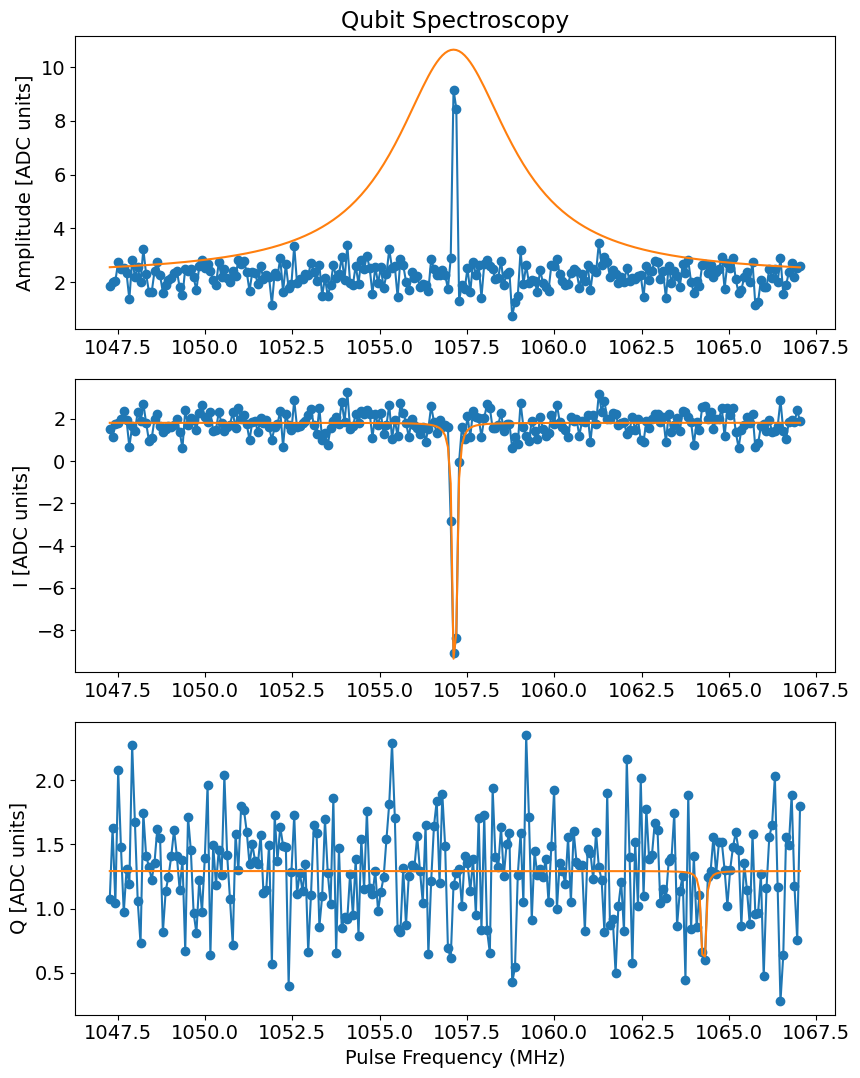

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated frequency for M1-S5: 1057.153984102207
Running flux spectroscopy f0g1 for mode 6
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
freq 1248.8560545996418


  0%|          | 0/250 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00027_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1248.9360545996417, HWHM 1.975999999999999
Found peak in I at [MHz] 1248.9726237277082, HWHM -0.04838780383039181
Found peak in Q at [MHz] 1258.6666281272924, HWHM 0.0859593449779291


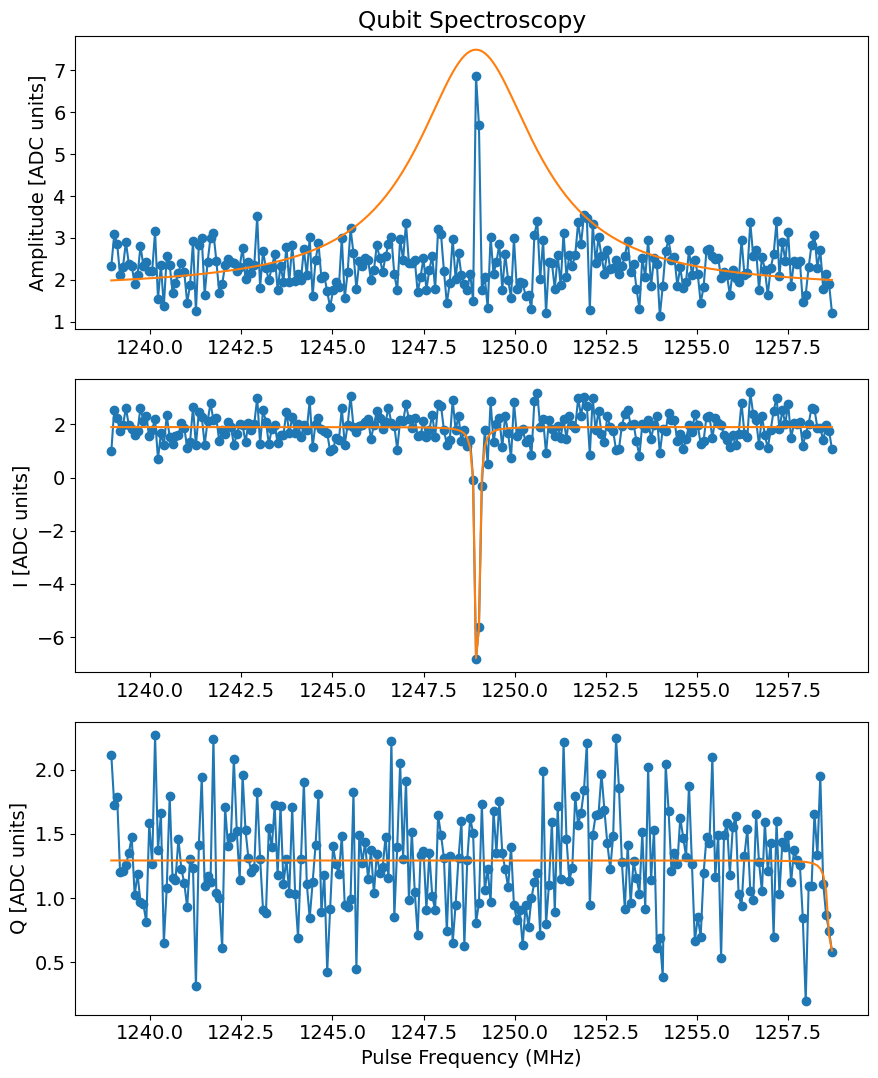

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated frequency for M1-S6: 1248.9726237277082
Running flux spectroscopy f0g1 for mode 7
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
freq 1427.0415105947316


  0%|          | 0/250 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00028_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1433.9351514645123, HWHM -0.09728887961446203
Found peak in I at [MHz] 1427.2156775903275, HWHM -0.04707587133308384
Found peak in Q at [MHz] 1434.2806196023394, HWHM -1023.9872928663897


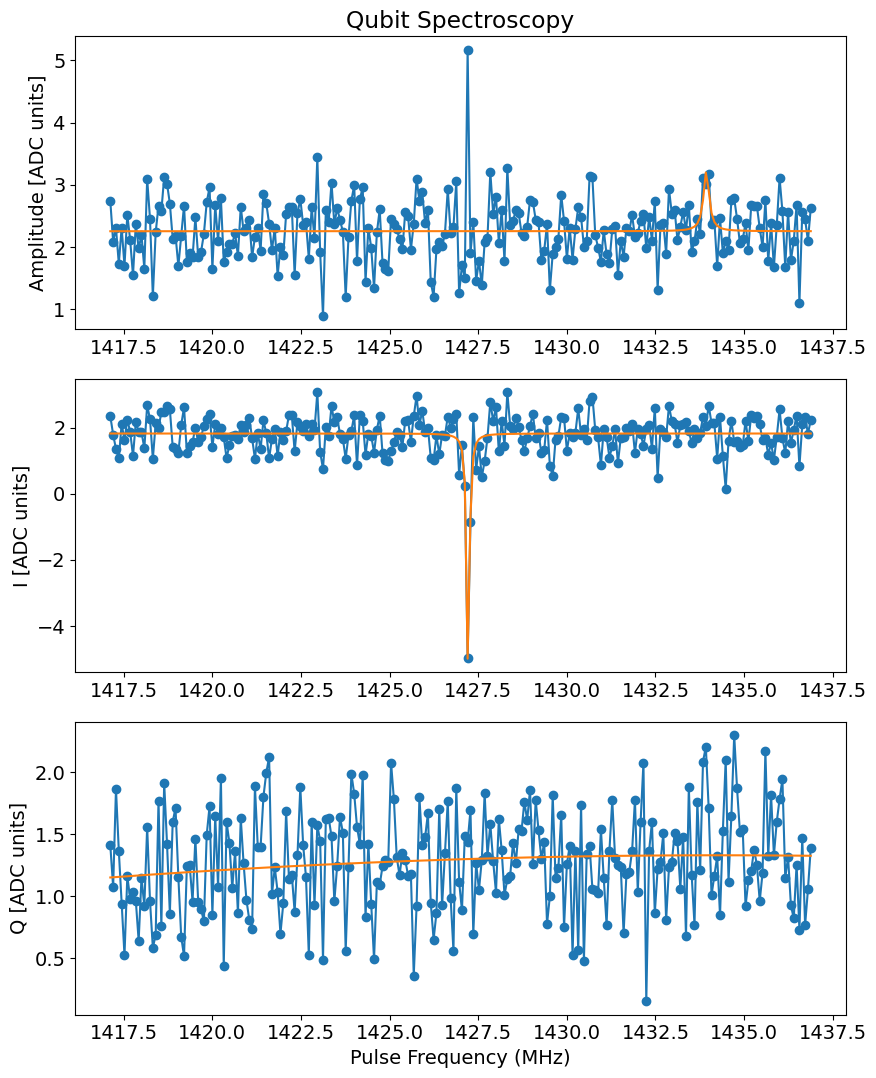

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated frequency for M1-S7: 1427.2156775903275


In [26]:
stor_specs = [None]* len(expts_to_run['stor_modes'])
# for i in range(len(expts_to_run['stor_modes'])):
for i in range(7):
    if expts_to_run['stor_spectroscopy']:
        print('Running flux spectroscopy f0g1 for mode', i+1)
        flux_spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
        stor_specs[i] = flux_spec
        analyze_and_display_stor_spectroscopy(flux_spec)
        update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no=1, stor_no=i+1)

In [27]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_thisrun.get_freq('M1-S' + str(i+1)))


Frequency for M1-S1: 352.94974892655034
Frequency for M1-S2: 524.6604930800365
Frequency for M1-S3: 700.969789988974
Frequency for M1-S4: 880.8464247026541
Frequency for M1-S5: 1057.153984102207
Frequency for M1-S6: 1248.9726237277082
Frequency for M1-S7: 1427.2156775903275


### Man-dump

In [19]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
prep_man_pi = mm_base_dummy.prep_man_photon(1)
prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

In [24]:
def get_dump_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, dump_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        dump_mode_no: Dump mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-D' + str(dump_mode_no)
    freq = ds_thisrun.get_freq(stor_name)
    gain = ds_thisrun.get_gain(stor_name)
    pi_len = ds_thisrun.get_pi(stor_name)
    h_pi_len = ds_thisrun.get_h_pi(stor_name)
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    prepulse_overwrite = [['multiphoton', 'g0-e0', 'pi', 0],
                            ['multiphoton', 'e0-f0', 'pi', 0],
                            ['multiphoton', 'f0-g1', 'pi', 0]
                        ]
    postpulse_overwrite = [ ['multiphoton', 'f0-g1', 'pi', 0],
                            ['multiphoton', 'e0-f0', 'pi', 0]]
    prepulse = mm_base_dummy.get_prepulse_creator(prepulse_overwrite).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(postpulse_overwrite).pulse.tolist()

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


def do_dump_spectroscopy(config_thisrun, 
                         ds_thisrun, 
                         expt_path, 
                         config_path, 
                         man_mode_no = 1, 
                         dump_no = 1,
                         flux_gain = 5000,
                         flux_length = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        dump_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_dump_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, dump_no)

    freq_start = 2300 #2350 
    freq_stop = 2400 #2400
    bw = freq_stop - freq_start
    expts = 200
    step = bw/expts



    flux_spec.cfg.expt = dict(
        # start=freq - 100,  # Start RF frequency [MHz]
        start=freq_start,  # Start RF frequency [MHz]
        step=step,  # Step size [MHz]
        expts=expts,  # Number of experiments
        reps=200,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1, flux_gain, flux_length],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=False,
        storage_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec


def update_dump_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, dump_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-D' + str(dump_no), flux_spec.data['fit'][2])
    print(f"Updated frequency for M{man_mode_no}-D{dump_no}: {flux_spec.data['fit'][2]}")


  0%|          | 0/200 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00033_FluxSpectroscopyF0g1Experiment.h5
[2349.75, 5000, 1000, 0, 3.5881104183888715, 9.671782214422022, -0.00598958122663275]
[2.33256124e+03 1.11199473e+06 1.08697236e+02 3.83200387e+00
 7.14096458e-01 8.68266509e+00 2.56964842e-03]

Freq with minimum transmission: 2309.0
Freq with maximum transmission: 2336.5
From fit:
	f0: 2332.5612406406085
	Qi: 1111994.7272621507
	Qe: 108.69723601533164
	Q0: 108.68661192331186
	kappa [MHz]: 21.46134836079387
	phi [radians]: 3.832003872144184


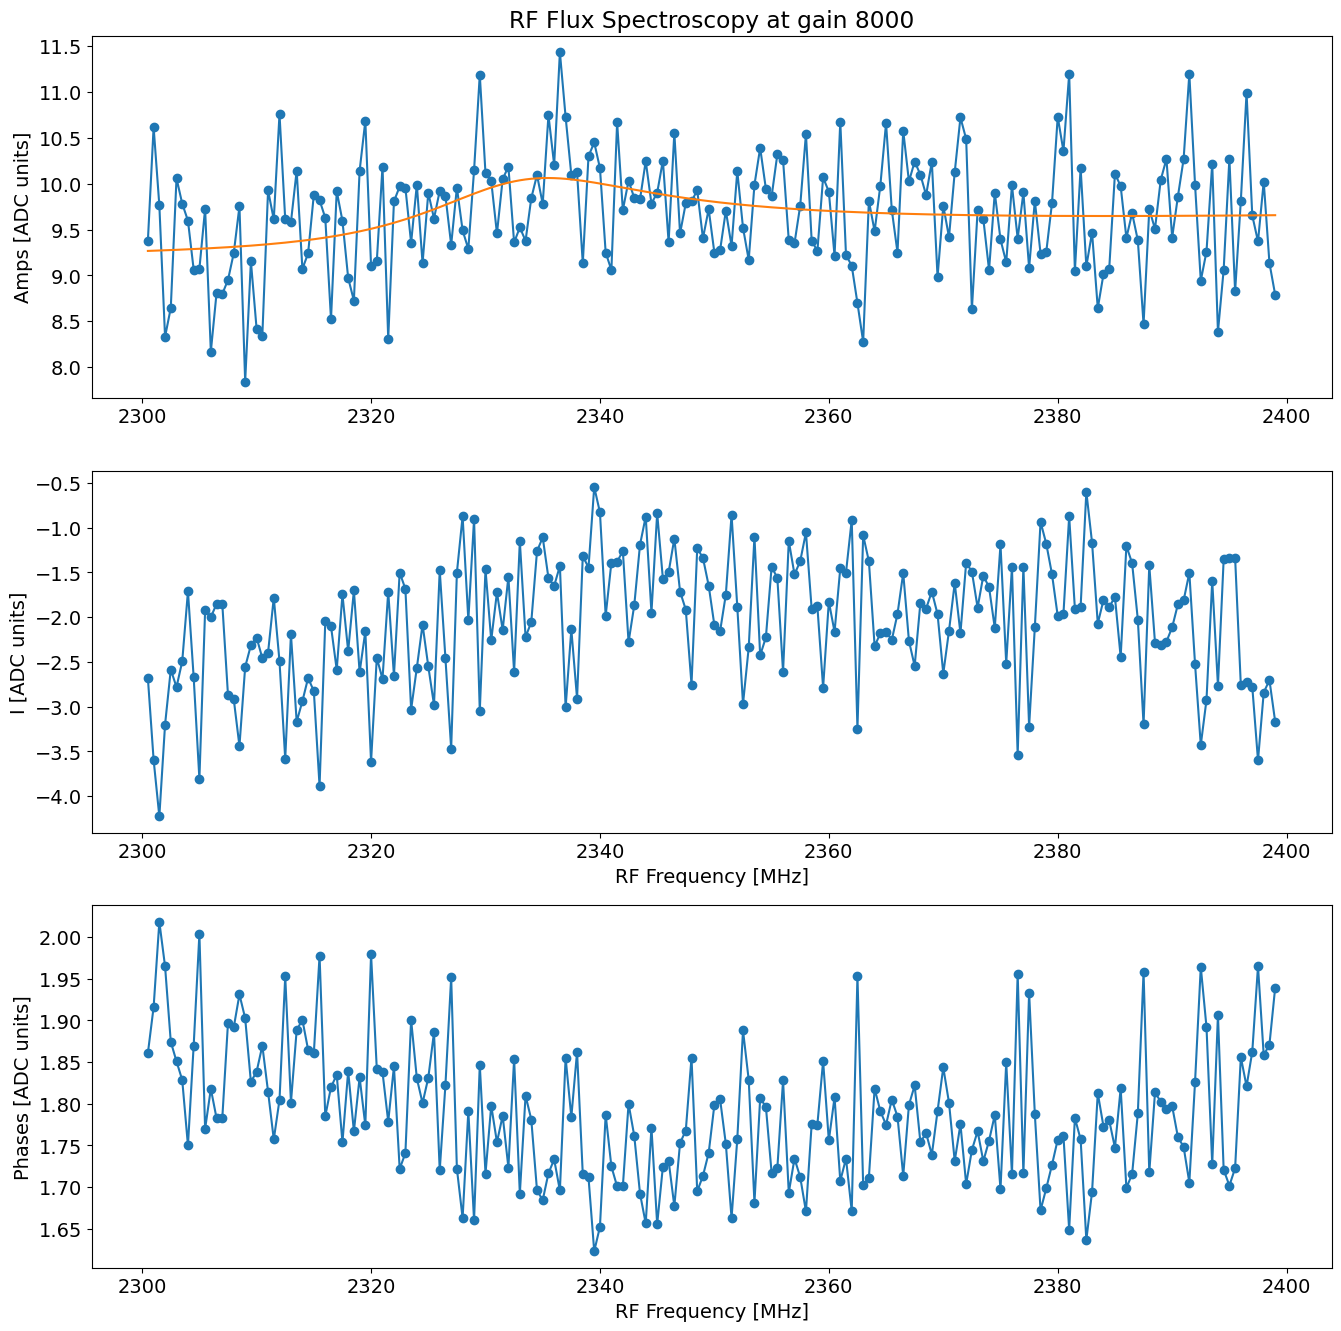

In [27]:
spec = do_dump_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, 
                            man_mode_no=1, dump_no=1,
                            flux_gain=8000, flux_length=5)
# analyze_and_display_stor_spectroscopy(spec)
# update_dump_spectroscopy(spec, ds_thisrun, 1, 1)
spec.analyze(fit=True)
spec.display()

[800, 100, 40, 0, 60, 0, 0]
Attempted to init fitparam 0 to 800, which is out of bounds 2200.3333333333335 to 2399.3333333333335. Instead init to 2299.8333333333335
Attempted to init fitparam 5 to 0, which is out of bounds 6.234721884063301 to 9.794095864752107. Instead init to 8.014408874407703
[ 2.31107102e+03  5.73401378e+05  3.37887312e+02 -2.13735880e+00
 -1.18398362e+00  6.54615330e+00  5.68505068e-04]

Freq with minimum transmission: 2379.0
Freq with maximum transmission: 2315.0
From fit:
	f0: 2311.0710196030054
	Qi: 573401.3778585839
	Qe: 337.8873124859044
	Q0: 337.6883234278609
	kappa [MHz]: 6.843799027882914
	phi [radians]: -2.1373587963062484


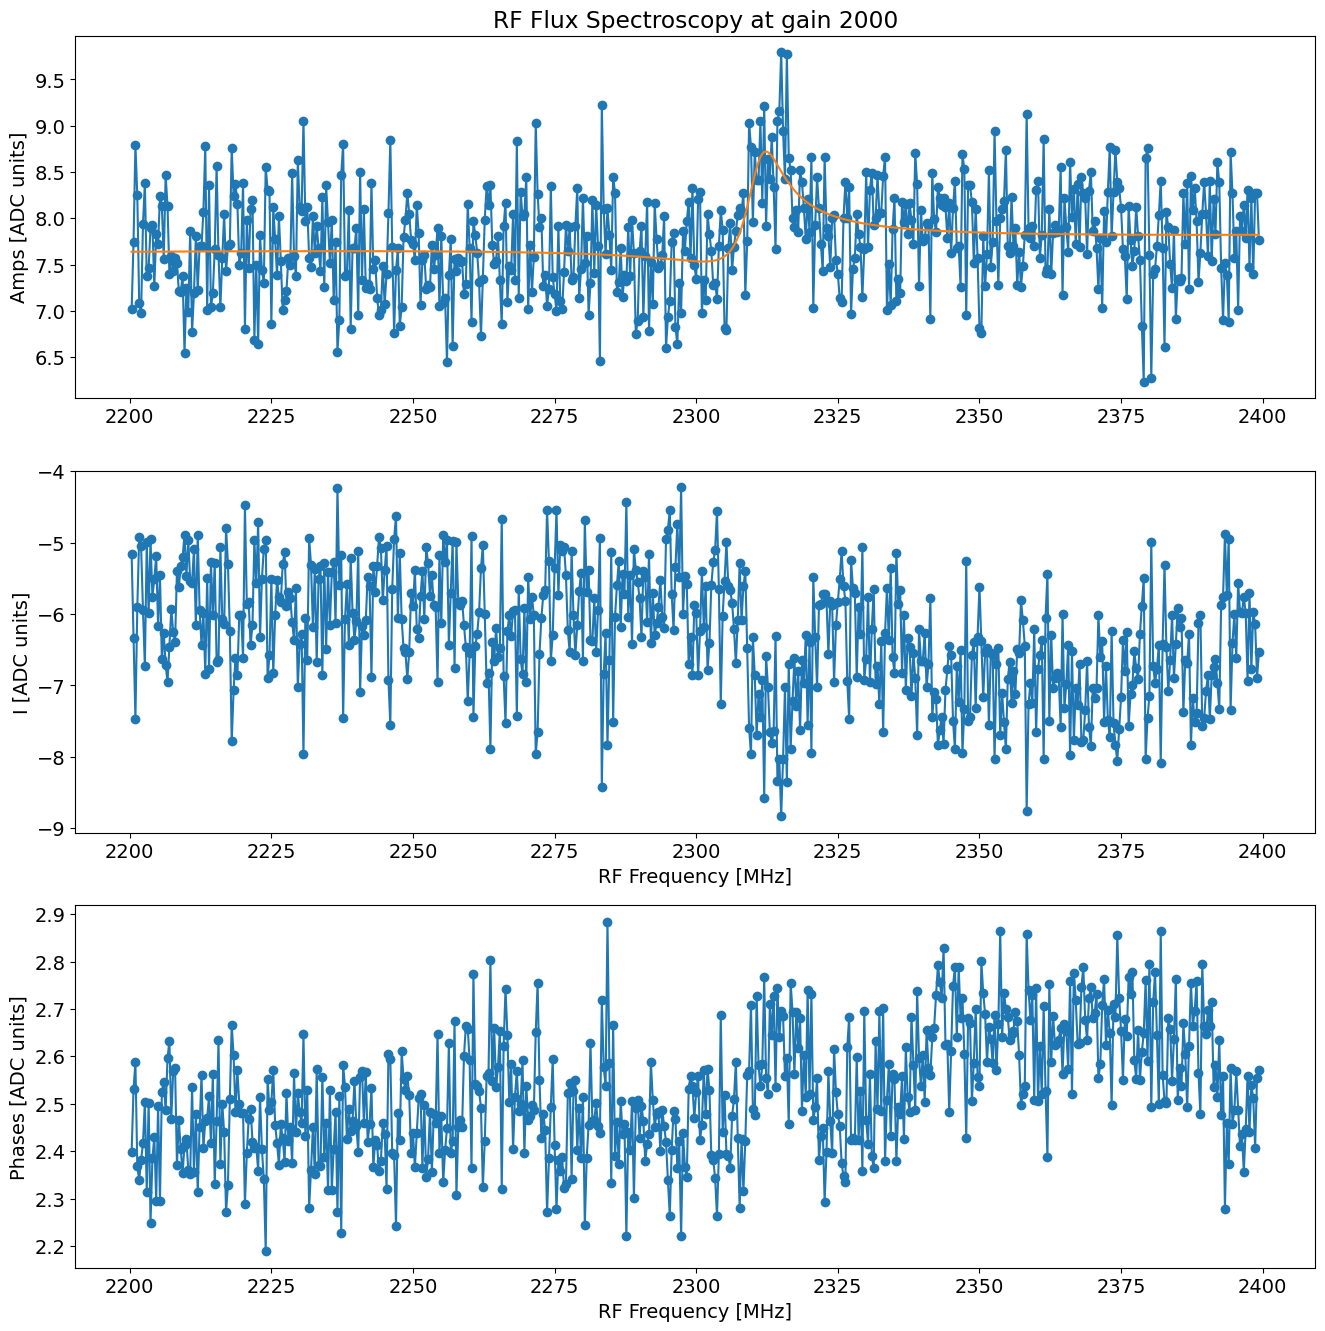

In [165]:
spec.analyze(fit=True, fitparams=[800, 100, 40, 0, 60, 0, 0])
spec.display()

In [ ]:
ds_thisrun.update_freq('M1-C', 781.5)


In [167]:
res = []

gains = np.arange(500, 2001, 50)
for flux_gain in tqdm(gains):
    spec = do_dump_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, 
                                man_mode_no=1, dump_no=1,
                                flux_gain=flux_gain, flux_length=1)
    res.append(spec.data['avgi'])
res = np.array(res)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  3%|▎         | 1/31 [02:03<1:01:33, 123.13s/it]

Saving D:\experiments\251111_qec\data\00021_FluxSpectroscopyF0g1Experiment.h5


  3%|▎         | 1/31 [02:07<1:03:51, 127.71s/it]


KeyboardInterrupt: 

In [ ]:
means = res.mean(axis=1)
stds = res.std(axis=1)
plt.errorbar(gains, means, yerr=stds, marker='o')

In [ ]:
# ds_thisrun.update_freq('M1-D1',  2373.6)

In [ ]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_thisrun.get_freq('M1-S' + str(i+1)))


### Man-coupler

In [ ]:
def get_coupler_parameters(ds_thisrun, config_thisrun, man_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        dump_mode_no: Dump mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-C'
    freq = ds_thisrun.get_freq(stor_name)
    gain = ds_thisrun.get_gain(stor_name)
    pi_len = ds_thisrun.get_pi(stor_name)
    h_pi_len = ds_thisrun.get_h_pi(stor_name)
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    prepulse_overwrite = [['multiphoton', 'g0-e0', 'pi', 0],
                            ['multiphoton', 'e0-f0', 'pi', 0],
                            ['multiphoton', 'f0-g1', 'pi', 0]
                        ]
    postpulse_overwrite = [ ['multiphoton', 'f0-g1', 'pi', 0],
                            ['multiphoton', 'e0-f0', 'pi', 0]]
    prepulse = mm_base_dummy.get_prepulse_creator(prepulse_overwrite).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(postpulse_overwrite).pulse.tolist()

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


def do_coupler_spectroscopy(config_thisrun, 
                         ds_thisrun, 
                         expt_path, 
                         config_path, 
                         man_mode_no = 1, 
                         dump_no = 1,
                         flux_gain = 5000,
                         flux_length = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        dump_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_coupler_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no)

    # freq = 420

    flux_spec.cfg.expt = dict(
        start=freq - 50,  # Start RF frequency [MHz]
        step=1,  # Step size [MHz]
        expts=100,  # Number of experiments
        reps=200,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1, flux_gain, flux_length],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=False,
        storage_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec


def update_dump_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-C', flux_spec.data['fit'][2])
    print(f"Updated frequency for M{man_mode_no}-C: {flux_spec.data['fit'][2]}")

ds_thisrun.update_freq('M' + str(1) + '-C', 919)

In [ ]:
spec = do_coupler_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1,
                            flux_gain=10000, flux_length=2)
# analyze_and_display_stor_spectroscopy(spec)
# update_dump_spectroscopy(spec, ds_thisrun, 1, 1)
spec.analyze(fit=True)
spec.display()

## Find Freq Chevron + Error Amp

In [28]:
def do_sideband_general_sweep(
    config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step,
    reps=50, man_mode_no = 1, stor_mode_no = 1, start_time = 0.007, liveplotting=True):
    """Run the Sideband General Sweep Experiment."""
    from multimode_expts.sequential_experiment_classes import sidebands_class
    experiment_class = sidebands_class
    sweep_experiment_name = 'sideband_general_sweep'
    class_for_exp = experiment_class(
        soccfg=soc, path=expt_path,
        prefix=sweep_experiment_name,
        config_file=config_path,
        exp_param_file=exp_param_file,
        config_thisrun=config_thisrun,
        liveplotting=liveplotting)

    # class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # get pulse parameters for the given storage mode
    print('Getting parameters for M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)
    pi_len = 2.
    # gain = 5000
    print('gain:', gain)
    print('prepulse:', prepulse)
    print('postpulse:', postpulse)
    print('start time ', start_time)
    print('pi_len ', pi_len)

    class_for_exp.loaded[sweep_experiment_name] =  dict(
        start=start_time,  # Pulse start length [us]
        # step=pi_len / 5,  # Pulse step length [us]
        step=pi_len / 10,  # Pulse step length [us]
        qubits=[0],
        # expts=15, #30,
        expts=30, #30,
        reps=reps, #90
        rounds=1,
        freq_start=freq_start,
        freq_stop=freq_stop,
        freq_step=freq_step,
        flux_drive=[ch, freq, gain, 0.05],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length placeholder(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )
    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)


def update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=1, update=True):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
    print('File saved at:', filename)

    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi'],config = config_thisrun,
    )
    print('Analyzing chevron data...')
    print('freq', temp_data['freq_sweep'])
    print('time', temp_data['xpts'][0])
    print('response_matrix', temp_data['avgi'])
    chevron_analysis.analyze()
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, title=f'M{man_mode_no}-S{stor_mode_no}_{current_time}')

    # Update dataset
    if not update: return chevron_analysis

    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    ds_thisrun.update_freq(stor_name, chevron_analysis.results['best_frequency_period'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_period'])

    pi_len = abs(np.pi / chevron_analysis.results['best_fit_params_period']['omega'])
    ds_thisrun.update_pi(stor_name, pi_len)
    print('Updated the pi length to:', pi_len)
    ds_thisrun.update_h_pi(stor_name, pi_len / 2)
    print('Updated the h_pi length to:', pi_len / 2)
    return chevron_analysis

In [29]:
def do_error_amp_storage(
    config_thisrun,
    ds_thisrun,
    expt_path,
    config_path,
    reps=100,
    rounds=1,
    qubit=0,
    n_start=1,
    n_step=1,
    n_pulses=10,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500, 
    span = 1.0, # in units of either freq or gain depending on parameter_to_test
    expts = 25,
    parameter_to_test = 'frequency',
    man_mode_no=1,
    stor_mode_no=1,
    stor_is_dump=False,
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    pulse_type = ['storage', f'M{man_mode_no}-{"D" if stor_is_dump else "S"}{stor_mode_no}', 'pi', 0]


    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    if parameter_to_test == 'frequency':
        start = freq - span / 2
        step = span / (expts - 1)
    elif parameter_to_test == 'gain':
        start = int(gain - span / 2)
        step = int(span / (expts - 1))
    else:
        raise ValueError("parameter_to_test must be either 'frequency' or 'gain'.")
    
    expt_cfg = {
        'reps': reps,
        'qubit': qubit,
        'qubits': [qubit],
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'start': start,
        'expts': expts,
        'step': step,
        'n_start': n_start,
        'n_step': n_step,
        'n_pulses': n_pulses,
        'pulse_type': pulse_type,
        'parameter_to_test': parameter_to_test,
        'rounds': rounds,
    }

    error_amp_exp = meas.single_qubit.error_amplification.ErrorAmplificationExperiment(
    soccfg=soc, path=expt_path,
      prefix='ErrorAmplificationExperiment', config_file=config_path)
    error_amp_exp.cfg = AttrDict(deepcopy(config_thisrun))
    error_amp_exp.cfg.expt = expt_cfg
    error_amp_exp.go(analyze=False, display=False, progress=True, save=True)
    return error_amp_exp

In [30]:
# expts_to_run['stor_modes'] = [1, 2, 3, 4, 5, 6, 7]
# expts_to_run['stor_modes'] = [2]
# expts_to_run['stor_modes'] = [5]

sideband_chevrons_coarse = [None] * len(expts_to_run['stor_modes'])
sideband_chevrons_fine = [None] * len(expts_to_run['stor_modes'])
error_amp_gain1 = [None] * len(expts_to_run['stor_modes'])
error_amp_freq1 = [None] * len(expts_to_run['stor_modes'])
error_amp_gain2 = [None] * len(expts_to_run['stor_modes'])
error_amp_freq2 = [None] * len(expts_to_run['stor_modes'])

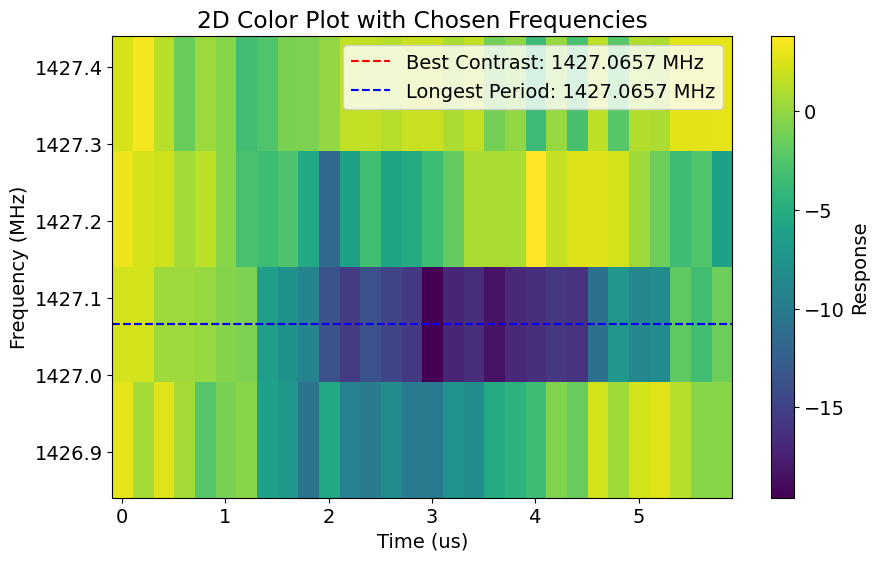

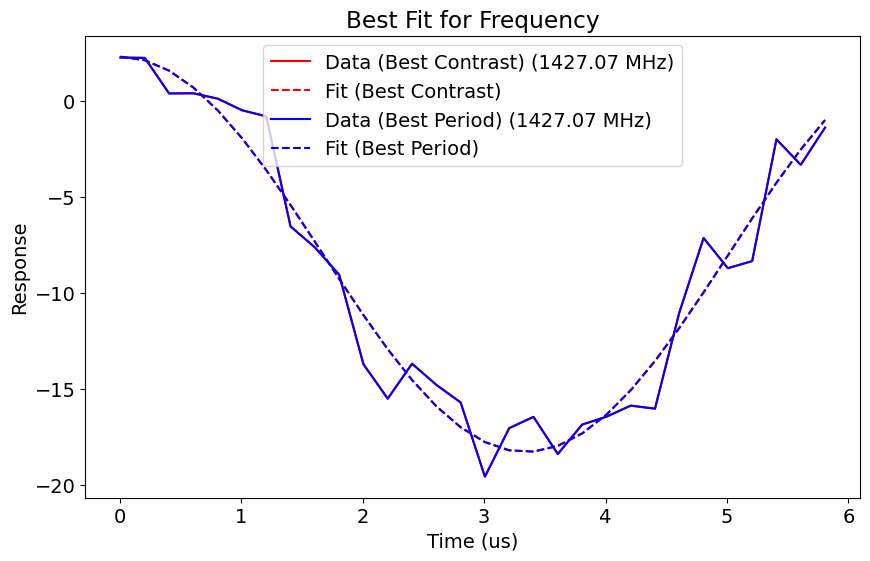

File saved at: D:\experiments\251111_qec\data\00015_sideband_general_sweep.h5
Analyzing chevron data...
freq [1426.91567759 1427.06567759 1427.21567759 1427.36567759]
time [0.007 0.207 0.407 0.607 0.807 1.007 1.207 1.407 1.607 1.807 2.007 2.207
 2.407 2.607 2.807 3.007 3.207 3.407 3.607 3.807 4.007 4.207 4.407 4.607
 4.807 5.007 5.207 5.407 5.607 5.807]
response_matrix [[  2.99796537   0.6752381    2.66294372   0.64108225  -2.4069697
   -1.03090909  -0.31965368  -6.37450216  -6.95168831 -10.68017316
   -5.58484848  -9.25952381  -9.80056277  -8.23398268 -10.06069264
  -10.03900433  -7.56004329  -8.12341991  -5.26354978  -4.54367965
   -3.49484848  -0.5734632   -1.63         2.23393939   0.51077922
    2.22333333   2.70683983   1.18411255  -0.38272727  -0.28744589]
 [  2.25770563   2.23753247   0.38675325   0.39350649   0.11489177
   -0.48891775  -0.80796537  -6.54454545  -7.63606061  -9.05627706
  -13.72493506 -15.51883117 -13.69831169 -14.79792208 -15.71515152
  -19.58619048 -17.053333

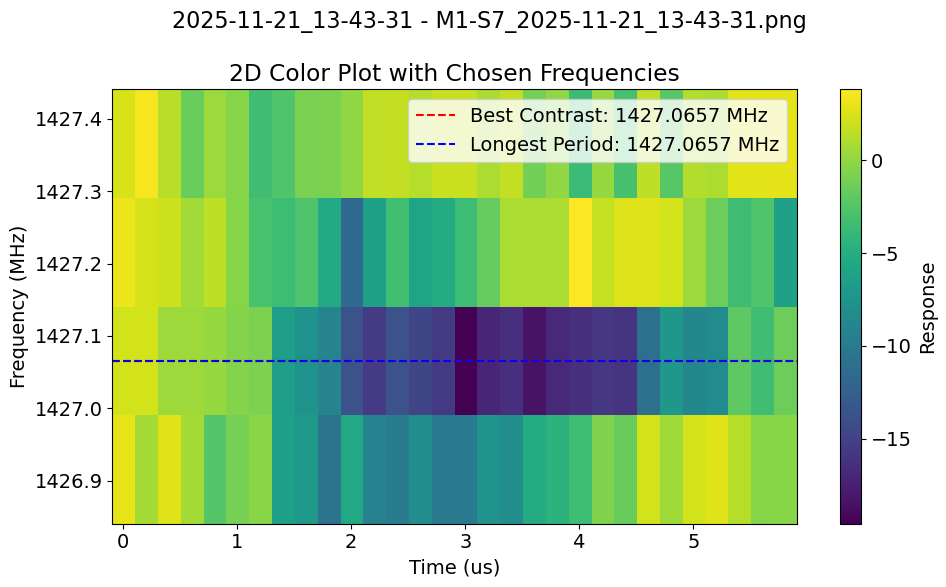

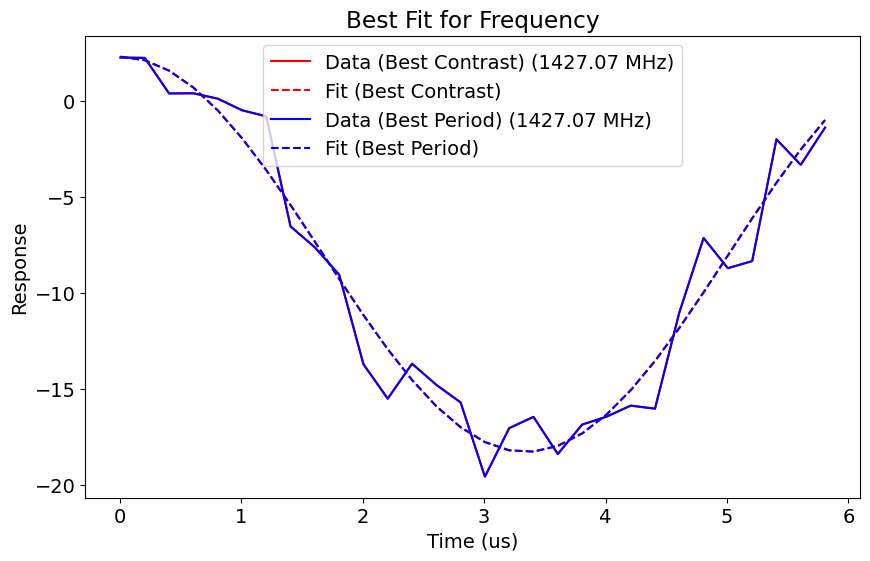

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the frequency to: 1427.0656775903276
Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the pi length to: 3.338040683350104
Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the h_pi length to: 1.669020341675052
Running error amplification (gain) for storage mode 7
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
cfg at start of acquire {'reps': 50, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 8900, 'expts': 50, 'step': 20, 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'pulse_type': ['storage', 'M1-S7', 'pi', 0], 'parameter_to_test': 'gain', 'rounds': 1}
n_pts [ 0  3  6  9 12 15]


  0%|          | 0/6 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00041_ErrorAmplificationExperiment.h5
fitparams [0.0004097642980193538, 0.9995902357019807, 9280, 98.0]


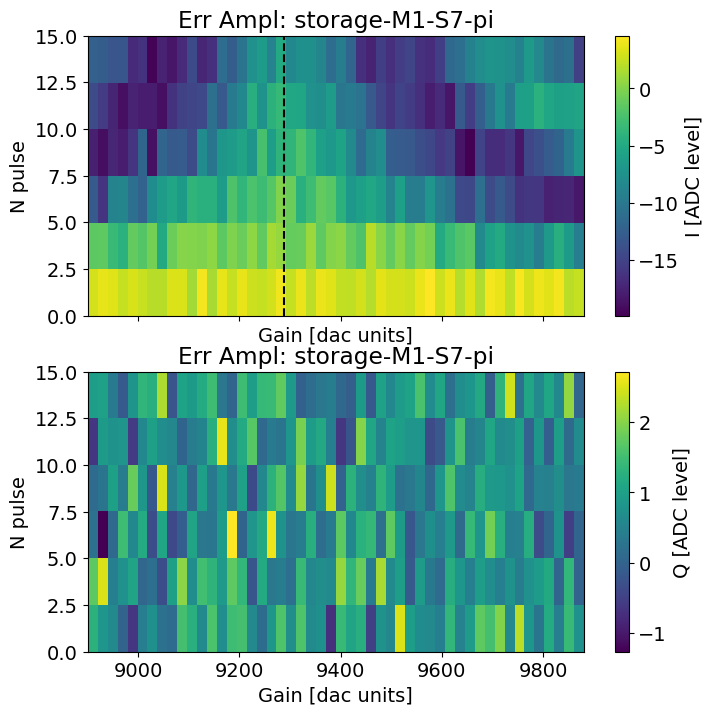

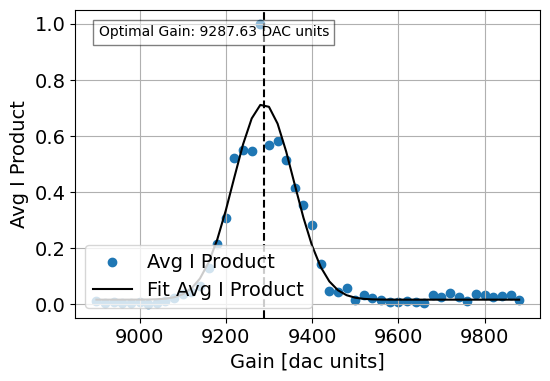

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the gain to: 9287
Running error amplification (frequency) for storage mode 7
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
cfg at start of acquire {'reps': 50, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 1426.9156775903275, 'expts': 50, 'step': 0.006122448979591836, 'n_start': 1, 'n_step': 1, 'n_pulses': 10, 'pulse_type': ['storage', 'M1-S7', 'pi', 0], 'parameter_to_test': 'frequency', 'rounds': 1}
n_pts [ 1  2  3  4  5  6  7  8  9 10]


  0%|          | 0/10 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00042_ErrorAmplificationExperiment.h5
fitparams [4.356311433909358e-05, 0.9999564368856609, 1427.0442490188989, 0.029999999999995454]


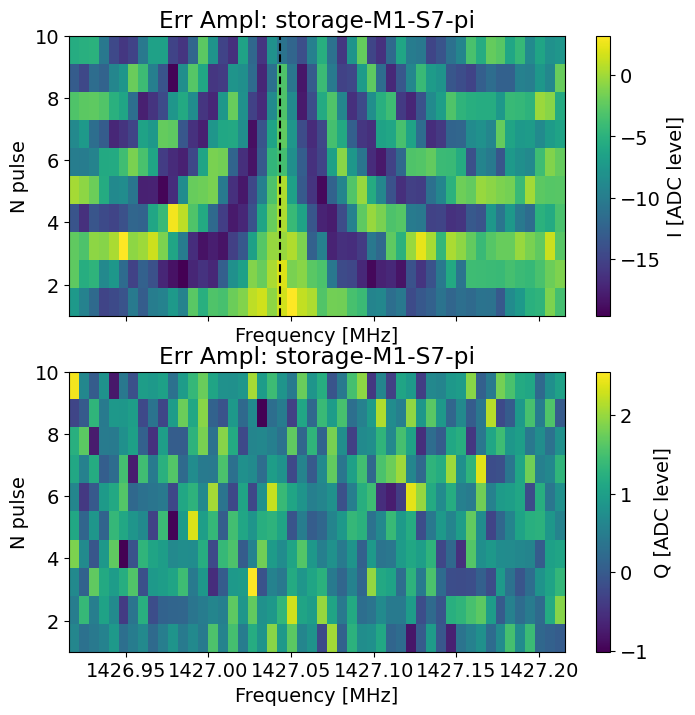

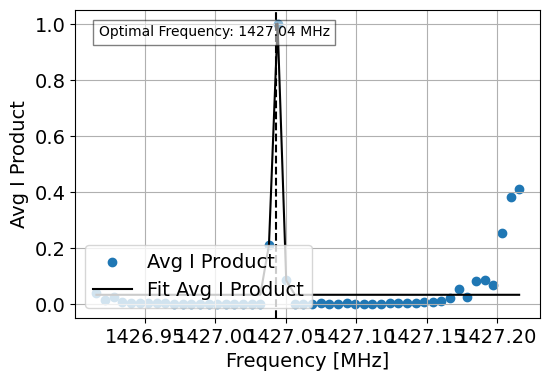

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the frequency to: 1427.0434305641174
Running error amplification (gain) ROUND 2 for storage mode 7
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
cfg at start of acquire {'reps': 50, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 8987, 'expts': 50, 'step': 12, 'n_start': 1, 'n_step': 1, 'n_pulses': 10, 'pulse_type': ['storage', 'M1-S7', 'pi', 0], 'parameter_to_test': 'gain', 'rounds': 1}
n_pts [ 1  2  3  4  5  6  7  8  9 10]


  0%|          | 0/10 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00043_ErrorAmplificationExperiment.h5
fitparams [0.001440626409919353, 0.9985593735900806, 9407, 58.8]


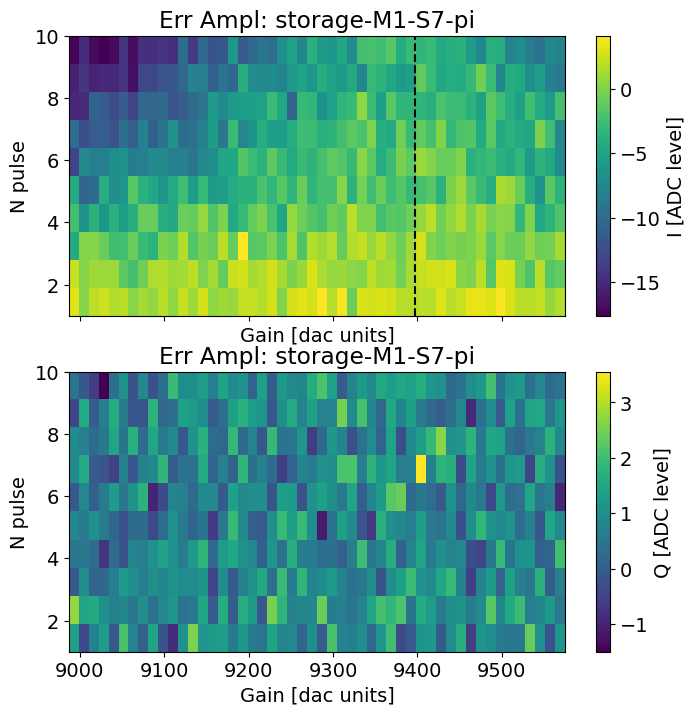

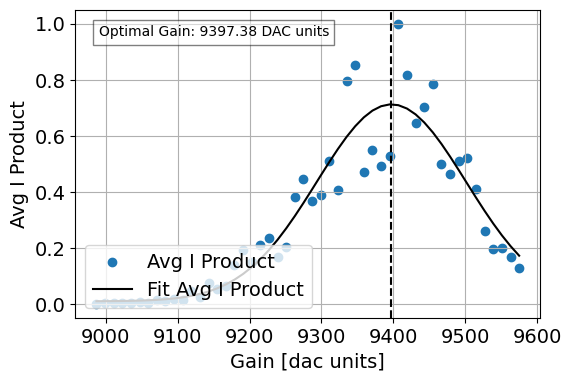

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the gain to: 9397


In [32]:
# for i, stor_i in enumerate(expts_to_run['stor_modes']):
# for i, stor_i in enumerate([1]):
for stor_i in [1,2,4,5,6,7]:
    stor_name = 'M1-S' + str(stor_i)
    if expts_to_run['sideband_freq_sweep']:

        print(f'Running coarse sideband sweep for storage mode {stor_i}')

        # freq_step = 1.0
        freq_start = ds_thisrun.get_freq(stor_name) - 0.3
        freq_stop = ds_thisrun.get_freq(stor_name) + 0.3
        freq_step = 0.15
        sideband_chevrons_coarse[i] = do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, reps=50, man_mode_no=1, stor_mode_no=stor_i, liveplotting=True)
        update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=stor_i)


        print(f'Running error amplification (gain) for storage mode {stor_i}')
        error_amp_exp_gain = do_error_amp_storage(
            config_thisrun, ds_thisrun, expt_path, config_path, reps=50, rounds=1, qubit=0, span=1000, expts=50, n_start=0, n_step=3, n_pulses=15, man_mode_no=1, stor_mode_no=stor_i, stor_is_dump=False, parameter_to_test='gain')
        error_amp_gain1[i] = error_amp_exp_gain
        error_amp_exp_gain.analyze(state_fin='e')
        error_amp_exp_gain.display()
        gain_opt = int(error_amp_exp_gain.data['fit_avgi'][2])
        # Update dataset
        ds_thisrun.update_gain(stor_name, gain_opt)
        print('Updated the gain to:', gain_opt)


        print(f'Running error amplification (frequency) for storage mode {stor_i}')
        error_amp_exp_freq = do_error_amp_storage(
            config_thisrun, ds_thisrun, expt_path, config_path, reps=50, rounds=1, qubit=0, span=0.3, expts=50, n_pulses=10, man_mode_no=1, stor_mode_no=stor_i, stor_is_dump=False, parameter_to_test='frequency')
        error_amp_freq1[i] = error_amp_exp_freq
        error_amp_exp_freq.analyze(state_fin='e')
        error_amp_exp_freq.display()
        freq_opt = error_amp_exp_freq.data['fit_avgi'][2]
        # Update dataset
        ds_thisrun.update_freq(stor_name, freq_opt)
        print('Updated the frequency to:', freq_opt)


        print(f'Running error amplification (gain) ROUND 2 for storage mode {stor_i}')
        error_amp_exp_gain2 = do_error_amp_storage(
            config_thisrun, ds_thisrun, expt_path, config_path, reps=50, rounds=1, qubit=0, span=600, expts=50, n_start=1, n_step=1, n_pulses=10, man_mode_no=1, stor_mode_no=stor_i, stor_is_dump=False, parameter_to_test='gain')
        error_amp_gain2[i] = error_amp_exp_gain2
        error_amp_exp_gain2.analyze(state_fin='e')
        error_amp_exp_gain2.display()
        gain_opt = int(error_amp_exp_gain2.data['fit_avgi'][2])
        # Update dataset
        ds_thisrun.update_gain(stor_name, gain_opt)
        print('Updated the gain to:', gain_opt)



In [ ]:
ds_thisrun.get_all('M1-S1')
# ds_thisrun.update_freq('M1-S1', 354.25)
# ds_thisrun.update_gain('M1-S1', 3500)

In [138]:
ds_thisrun.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   352.928863              NaN   2.036473    1.018237   
1      M1-S2   524.779782              NaN   2.039761    1.019881   
2      M1-S3   700.929597              NaN   1.734145    0.867073   
3      M1-S4   880.892196              NaN   1.535802    0.767901   
4      M1-S5  1057.197317              NaN   2.458605    1.229303   
5      M1-S6  1248.856055              NaN   1.935612    0.967806   
6      M1-S7  1427.041511              NaN   3.331222    1.665611   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2013.517719              NaN   0.583585    0.286350   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2373.600000             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   973.230000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3302  2025-11-11 11:51:34.379062  
1               4201  2025-11-11 11:55:49.309087  
2               4874  2025-11-11 13:11:18.309410  
3               9059  2025-11-11 12:04:38.007029  
4               7417  2025-11-11 12:25:47.075699  
5              13339  2025-11-11 12:29:49.523382  
6               9400  2025-11-11 12:33:52.857113  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12              8000  2025-11-11 11:20:08.346767  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-10-28 16:37:57.400701  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

In [ ]:
# for i, stor_i in enumerate(expts_to_run['stor_modes']):
#     if stor_i != 4: continue
#     # if stor_i == 5: continue

#     stor_name = 'M1-S' + str(stor_i)
#     print(stor_name)
#     ds.update_gain(stor_name, ds_thisrun.get_gain(stor_name))
#     ds.update_freq(stor_name, ds_thisrun.get_freq(stor_name))
#     ds.update_pi(stor_name, ds_thisrun.get_pi(stor_name))
#     ds.update_h_pi(stor_name, ds_thisrun.get_h_pi(stor_name))

# Qubit characterization

In [ ]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_thisrun.get_freq('M1-S' + str(i+1)))

In [ ]:
# #Update sweep data and analyze results

# temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
# print('File saved at:', filename)

# from multimode_expts.fit_display_classes import ChevronFitting
# from datetime import datetime
# chevron_analysis = ChevronFitting(
#     frequencies=temp_data['freq_sweep'],
#     time=temp_data['xpts'][0],
#     response_matrix=temp_data['avgi'],
#     config = config_thisrun,
# )
# chevron_analysis.analyze()

# current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# chevron_analysis.display_results(save_fig=True,  title=f'M{1}-S{7}_{current_time}')

In [ ]:
# i = 5
# print(f'Running fine sideband sweep for storage mode {i + 1}')
# freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 1.5
# freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 1.5
# freq_step = 0.2
# sideband_chevrons_fine = do_sideband_general_sweep(
#     config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
#     man_mode_no=1, stor_mode_no=i + 1, start_time=0.1, use_flux_low=True)
# # update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1, use_flux_low=True)

In [ ]:
# i = 5
# print(f'Running fine sideband sweep for storage mode {i + 1}')
# freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 0.5
# freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 0.5
# freq_step = 0.2
# sideband_chevrons_fine = do_sideband_general_sweep(
#     config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
#     man_mode_no=1, stor_mode_no=i + 1, start_time=0.1, use_flux_low=False)
# # update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1, use_flux_low=True)

### Manually get the frequencies from the chevrons

In [ ]:
# file_list = [34,36,38,40,42,44,46]
# chevrons_stor_objects = [None]* len(file_list)
# name = '_sideband_general_sweep.h5'
# # name = '_storage_sideband_sweep.h5'
# for idx, file_no in enumerate(file_list):
#     full_name = str(file_no).zfill(5)+name
#     expt_path_mod = r"H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data"
#     temp_data, attrs, filename = prev_data(expt_path_mod, full_name)  # ef

#     from multimode_expts.fit_display_classes import ChevronFitting
#     chevron_analysis = ChevronFitting(
#         frequencies=temp_data['freq_sweep'],
#         time=temp_data['xpts'][0],
#         response_matrix=temp_data['avgi']
#     )
#     chevrons_stor_objects[idx] = chevron_analysis

In [ ]:
# i = 6
# # guess_freq = 1422.66
# anls = chevrons_stor_objects[i]
# anls.analyze()
# anls.display_results(save_fig=False, 
#                     directory=autocalib_path, 
#                     title=f'M1-S{i+1}')
#                 #  hlines = [guess_freq])
# ds_thisrun.update_freq('M1-S' + str(i+1), anls.results['best_frequency_period'])
# # or override manually 
# # ds_thisrun.update_freq('M1-S' + str(i+1), 1052.8026)

In [ ]:
# ds_thisrun.df

In [ ]:

# ds_thisrun.update_freq('M1-S' + str(i), guess_freq)

In [ ]:
# ds_thisrun.get_freq('M1-S3')

## Sideband General

In [ ]:
def do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no = 1,stor_mode_no=1):
    """Run the Sideband General Experiment."""
    
    sideband_general = meas.single_qubit.sideband_general.SidebandGeneralExperiment(
        soccfg=soc, path=expt_path, prefix='SidebandGeneralExperiment', config_file=config_path
    )

    sideband_general.cfg = AttrDict(deepcopy(config_thisrun))

    # Sideband general experiment parameters
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    sideband_general.cfg.expt = dict(
        start=0.007,  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        flux_drive=[ch, freq, gain],  # RF flux modulation
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
    )

    sideband_general.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    sideband_general.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import LengthRabiFitting
    sideband_analysis = LengthRabiFitting(sideband_general.data, config=sideband_general.cfg)
    sideband_analysis.analyze()
    sideband_analysis.display(title_str='Sideband General', save_fig=True)

    return sideband_analysis


def update_sideband_general(sideband_general, config_thisrun, ds, man_mode_no=1, stor_mode_no=1):
    """Update the configuration and dataset based on Sideband General experiment results."""
    # Analyze the data
    

    # Update dataset
    pi_length = sideband_general.results['pi_length']
    pi2_length = sideband_general.results['pi2_length']
    gain = sideband_general.cfg.expt['flux_drive'][2]
    freq = sideband_general.cfg.expt['flux_drive'][1]
    ds.update_all('M' + str(man_mode_no) + '-S' + str(stor_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated configuration and dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



In [ ]:
len_rabi_storages = [None]* len(expts_to_run['stor_modes'])
if expts_to_run['sideband_length_rabi']:
    for man_mode_no in expts_to_run['man_modes']:
        for stor_mode_no in expts_to_run['stor_modes']:
            print(f'Running sideband general for manipulation mode {man_mode_no} and storage mode {stor_mode_no}')
            len_rabi_storages[stor_mode_no-1] = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
            update_sideband_general(len_rabi_storages[stor_mode_no-1], config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)


In [ ]:
# stor_mode_no = 1
# man_mode_no = 1
# len_rabi_storage = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
# update_sideband_general(len_rabi_storage, config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)

## Randomized Benchmarking

In [ ]:
len([1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500])

In [ ]:
# config_thisrun.device.storage.ramp_sigma
# man_mode_no = 1
# stor_mode_no = 7
# req = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# hpi_length = ds_thisrun.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# print("ramp_sigma:", config_thisrun.device.storage.ramp_sigma)
# print("man_mode_no:", man_mode_no)
# print("stor_mode_no:", stor_mode_no)
# print("freq:", req)
# print("gain:", gain)
# print("hpi_length:", hpi_length)

In [ ]:

def do_single_beam_splitter_rb_postselection_sweep_depth(config_thisrun, ds_thisrun, expt_path, config_path, exp_param_file, man_mode_no=1, stor_mode_no=1,
                                                         prev_data=None):
    """
    Run the SingleBeamSplitterRBPostSelection_sweep_depth experiment.
    """
    from multimode_expts.sequential_experiment_classes import MM_DualRailRB
    experiment_class = MM_DualRailRB
    sweep_experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth'
    class_for_exp = experiment_class(
        soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file, 
        prev_data=prev_data
    )

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # Customize bs_para for the given manipulation and storage mode using ds_thisrun directly
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    hpi_length = ds_thisrun.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    bs_para = [freq, gain, hpi_length, config_thisrun.device.storage.ramp_sigma]
    print('Beam splitter parameters:', bs_para)
    # Optionally, set up experiment parameters here if needed, e.g.:
    # class_for_exp.loaded[sweep_experiment_name] = dict(...)
    class_for_exp.loaded[sweep_experiment_name] = dict(
        depth_list=[1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500, 2000],  # RB sequence depth list
        reps_list = [],
        qubits=[0],
        reps=0,  # doesn't matter

        single_shot_bef_expt=False,  # single shot before experiment
        singleshot_reps=2000,        # single shot measurement repetitions
        span=1000,                   # single shot plot span

        active_reset=False,          # for single shot post selection
        man_reset=True,              # for single shot post selection
        storage_reset=True,          # for single shot post selection
        threshold=None,              # for single shot post selection
        readout_per_round=4,         # for single shot post selection

        rb_active_reset=False,
        rb_man_reset=True,
        rb_storage_reset=True,
        rb_reps=1000,
        gates_per_wait=100000,       # ????
        parity_meas=True,            # If parity measurement is used, set to True; if False the reset arguments below should be false as well
        reset_qubit_after_parity=False,  # True # resetting via second parity str 
        reset_qubit_via_active_reset_after_first_meas=False,  # resetting via active reset after first parity str; the other reset should be false

        rounds=1,                    # always set to 1
        variations=10,                # number of different sequences
        rb_depth=10,                 # rb sequence depth
        IRB_gate_no=-1,              # IRB gate number, -1 means not using
        postselection_delay=2.0,     # in us, gap between two readout pulses
        bs_repeat=1,
        sync=False,
        setup=False,

        bs_para=bs_para,  # at 96  # beam splitter parameters [[frequency], [gain], [length (us)], [sigma]]
        prepulse=False,
        postpulse=False,
        f0g1_offset=0,               # offset phase in deg as a result of f0g1 prepulse/postpulse

        pre_sweep_pulse=[[None]],    # Gate based; prep f0g1 is done automatically ; RAM state prep is also automatic 
        ram_prepulse=[False, 6, [1], 1],  # [True/False, number of storage modes to be populated, [idx of modes to be skipped], variations]
        ram_prepulse_strs=None       # see SingleBeamSplitterRBPostSelection_sweep_depth_and_ram
    )
    

    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Example, adjust as needed

    prefix, dir_path =eval('class_for_exp.run_sweep')(sweep_experiment_name=sweep_experiment_name)
    print('File saved at:', prefix)
    print('Directory path:', dir_path)

    # from multimode_expts.fit_display_classes import MM_DualRailRBFitting
    # rb_analysis = MM_DualRailRBFitting(
    #     filename=None,
    #     file_prefix=prefix,
    #     config=yaml_cfg,
    #     expt_path=expt_path,
    #     title=f'M{man_mode_no}-S{stor_mode_no}',
    #     prev_data=prev_data,
    #     dir_path=dir_path
    # )
    # rb_analysis.show_rb(save_fig=True)
    # return rb_analysis


In [ ]:
if expts_to_run['RB']:
    storage_rbs = [None] * len(expts_to_run['stor_modes'])
    for i in range(len(expts_to_run['stor_modes'])):
        print(f'Running storage RB postselection sweep depth for storage mode {i + 1}')
        storage_rbs[i] = do_single_beam_splitter_rb_postselection_sweep_depth(
            config_thisrun,
            ds_thisrun,
            expt_path,
            config_path,
            exp_param_file=exp_param_file,
            man_mode_no=1,
            stor_mode_no=i + 1
        )

In [ ]:
# from multimode_expts.fit_display_classes import MM_DualRailRBFitting
# dir_no = np.arange(72, 80, 1 )
# for idx, dir_no in enumerate(dir_no):
#     prefix = f"SingleBeamSplitterRBPostSelection_sweep_depth"
#     dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
#     dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
#     filepath = dir_path
#     # Initialize RB analysis
#     rb_analysis = MM_DualRailRBFitting(
#         filename=None,
#         file_prefix=prefix,
#         config=yaml_cfg,
#         expt_path=expt_path,
#         title=f"M1-S{idx + 1} RB Analysis",
#         prev_data=prev_data,
#         dir_path=filepath
#     )
#     rb_analysis.show_rb(save_fig=True)



In [ ]:
dir_no = 78
dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
temp_data, attrs, filename = prev_data(dir_path, prefix='SingleBeamSplitterRBPostSelection_sweep_depth')

In [ ]:
atrrs = AttrDict(attrs)
attrs['config']['device']['qubit']['f_ge']

In [ ]:
# storage_rb

In [ ]:
expt_test = Experiment(
            path=expt_path,
            prefix="yoyoyo",
            config_file=config_path,
        )

In [ ]:
expt_test.data = {}
f = expt_test.save_data()

In [ ]:
if expts_to_run['RB']:
    filename = expt_test.fname
    #create a directory with the filename but no .h5 extension
    import os
    directory = filename
    if directory.lower().endswith('.h5'):
        directory = directory[:-3]
    if not os.path.exists(directory):
        # Only create the directory if it is not the same as the filename (i.e., filename is not a directory itself)
        # Make sure the directory name does not have a .h5 extension
        os.makedirs(directory)

In [ ]:
# directory
# filename_only = os.path.basename(expt_test.fname)
# filename_only

In [ ]:
if expts_to_run['RB']:
    from multimode_expts.fit_display_classes import MM_DualRailRBFitting
    rb_analysis = MM_DualRailRBFitting(file_prefix = "SingleBeamSplitterRBPostSelection_sweep_depth", 
                                    config=config_thisrun, expt_path=expt_path, title='M1_S1', 
                                    prev_data= prev_data)
    rb_analysis.show_rb()

In [ ]:
if expts_to_run['RB']:
    temp_data, attrs, filename = prev_data(expt_path, '00036_SingleBeamSplitterRBPostSelection_sweep_depth.h5')

In [ ]:
attrs['config'].keys()

In [ ]:
temp_data.keys()

In [ ]:
num_entries = len(temp_data['Idata'])
print(f"Number of entries in 'Idata': {num_entries}")

In [ ]:
temp_data['sequences']

# Shock TLS Function

In [ ]:
from multimode_expts.experiments.single_qubit.pulse_probe_f0g1_spectroscopy import PulseProbeF0g1SpectroscopyExperiment

def do_pulse_probe_f0g1_spectroscopy(config_thisrun, expt_path, config_path, 
                                     start=2007, step=0.02, expts=300, reps=100,
                                       rounds=1, length=1, gain=5000, pulse_type='gaussian',
                                         qubit_f=True, qubits=[0], prepulse=False, pre_sweep_pulse=None):
    """
    Run the PulseProbeF0g1SpectroscopyExperiment with specified parameters.
    """
    
    expt = PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )
    expt.cfg = AttrDict(deepcopy(config_thisrun))
    expt.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        pulse_type=pulse_type,
        qubit_f=qubit_f,
        qubits=qubits,
        prepulse=prepulse,
        pre_sweep_pulse=pre_sweep_pulse
    )
    expt.cfg.device.readout.relax_delay = [5]  # Wait time between experiments [us]
    expt.go(analyze=True, display=True, progress=True, save=True)
    return expt

In [ ]:
# t2ramsey_ge_check = None
# while True: 
#     #close previous plots 
#     # import matplotlib.pyplot as plt
#     #each iteration is 5 minutes
#     # do_pulse_probe_f0g1_spectroscopy(
#     #     config_thisrun, expt_path, config_path,
#     #     start=3300, step=0.04, expts=10000, reps=100,
#     #     rounds=5, length=50, gain=30000, pulse_type='gaussian',
#     #     qubit_f=False, qubits=[0], prepulse=False, pre_sweep_pulse=None
#     # )

#     do_pulse_probe_ge(config_thisrun, start = 3300, 
#                       step = 0.04, expts = 10000, reps = 100, rounds = 5,
#                       length = 50, gain = 30000)
#     from IPython.display import clear_output
#     # from multimode_expts.fit_display_classes import SidebandFitting
#     clear_output(wait=True)
#     plt.close('all')  # Close all existing figures
#     t2ramsey_ge_check = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
#     t2ramsey_ge_check.analyze()
#     t2ramsey_ge_check.display(title_str='T2_ge_TLS')


In [ ]:
from multimode_expts.MM_base import MMAveragerProgram
from multimode_expts.experiments.qsim.utils import ensure_list_in_cfg

class ShockTLSProgram(MMAveragerProgram):
    def initialize(self):
        self.MM_base_initialize()
        
        
    def body(self):
        self.reset_and_sync()

        self.setup_and_pulse(
            ch=0,
            style='const',
            freq=self.freq2reg(1918, gen_ch=0),
            length=50,
            phase=0,
            gain=30000,
        )
    def update(self):
        print('Updating frequency...')
        print('Current frequency (MHz):', self.reg2freq(self.r_freq2, gen_ch=0))
        print('Frequency step (MHz):', self.f_step)
        self.mathi(self.q_rp, self.r_freq2, self.r_freq2, '+', self.f_step) # update frequency list index


class ShockTLSExperiment(Experiment):
    def acquire(self, progress):
        ensure_list_in_cfg(self.cfg)
        
        self.prog = ShockTLSProgram(soccfg=self.soccfg, cfg=self.cfg)
        self.prog.acquire(self.im[self.cfg.aliases.soc],
                         threshold=None,
                         load_pulses=True,
                         progress=progress,
                         debug=False)
    

### ShockTLS !!!

In [ ]:
shockTLS_bool = False # Set to FALSE to avoid running!!!!!!
if shockTLS_bool:    
    scktls = ShockTLSExperiment(soccfg=soc, path=expt_path, prefix='shockTLS',
                            config_file=config_path)
    scktls.cfg = AttrDict(deepcopy(config_thisrun))

    scktls.cfg.expt = dict(expts=2000, reps=2000, rounds=100000, qubit=[0])

    scktls.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    for kk in range(50):
        scktls.go(analyze=False, display=False, progress=True, save=False)

# Update Config and Dataset

In [31]:
def convert_attrdict_to_dict(attrdict):
    """
    Recursively converts an AttrDict or a nested dictionary into a standard Python dictionary.
    Converts np.float64 values to standard Python float.

    Args:
        attrdict (AttrDict or dict): The input AttrDict or dictionary to be converted.

    Returns:
        dict: A standard Python dictionary with all nested AttrDicts or dictionaries converted.
    """
    if isinstance(attrdict, AttrDict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, dict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, np.float64):
        return float(attrdict)
    else:
        return attrdict


def convert_numbers_to_float(data):
    """
    Recursively converts all numbers in a dictionary to float.

    Args:
        data (dict): The input dictionary.

    Returns:
        dict: A dictionary with all numbers converted to float.
    """
    if isinstance(data, dict):
        return {key: convert_numbers_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_numbers_to_float(item) for item in data]
    elif isinstance(data, float):
        return float(data)
    elif isinstance(data, int):
        return int(data)
    else:
        return data

## Dataset comparison for man1_storage_swap_dataset

In [34]:
#compare the two datsets
differences = ds_thisrun.compare_with(ds)
# Filter out differences related to 'last_update' column
filtered_differences = [diff for diff in differences if diff['column'] != 'last_update']
# Update labels and calculate differences
for diff in filtered_differences:
    if np.isnan(diff['self_value']) and np.isnan(diff['other_value']):
        diff['difference'] = None
        continue
    diff['label'] = f"New value: {diff['self_value']}, Old value: {diff['other_value']}"
    diff['difference'] = diff['self_value'] - diff['other_value'] if isinstance(diff['self_value'], (int, float)) and isinstance(diff['other_value'], (int, float)) else None

# Group differences by storage name
grouped_differences = {}
for diff in filtered_differences:
    stor_name = diff['stor_name']
    if stor_name not in grouped_differences:
        grouped_differences[stor_name] = []
    grouped_differences[stor_name].append(diff)

# Print grouped differences
for stor_name, diffs in grouped_differences.items():
    print(f"In {stor_name}:")
    for diff in diffs:
        if np.isnan(diff['self_value']) and np.isnan(diff['other_value']):
            continue
        print(f"  Column '{diff['column']}': new_value = {diff['self_value']}, old_value = {diff['other_value']}, difference = {diff['difference']}")
    grouped_differences[stor_name].append(diff)


In M1-S1:
  Column 'freq (MHz)': new_value = 352.928893749093, old_value = 352.9288626781636, difference = 3.1070929367160716e-05
  Column 'pi (mus)': new_value = 2.0199717195434386, old_value = 2.036473033109906, difference = -0.016501313566467335
  Column 'h_pi (mus)': new_value = 1.0099858597717193, old_value = 1.018236516554953, difference = -0.008250656783233667
  Column 'gain (DAC units)': new_value = 3320, old_value = 3302, difference = None
In M1-S2:
  Column 'freq (MHz)': new_value = 524.7819732940873, old_value = 524.7797819205764, difference = 0.0021913735108682886
  Column 'pi (mus)': new_value = 2.016206962050737, old_value = 2.0397614499293217, difference = -0.02355448787858494
  Column 'h_pi (mus)': new_value = 1.0081034810253684, old_value = 1.0198807249646609, difference = -0.01177724393929247
  Column 'gain (DAC units)': new_value = 4214, old_value = 4201, difference = None
In M1-S3:
  Column 'freq (MHz)': new_value = 700.9329739798377, old_value = 700.9295967622894, 

In [141]:
ds_thisrun.df["gain (DAC units)"] = ds_thisrun.df["gain (DAC units)"].astype(int)

In [142]:
ds_thisrun.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   352.928863              NaN   2.036473    1.018237   
1      M1-S2   524.779782              NaN   2.039761    1.019881   
2      M1-S3   700.929597              NaN   1.734145    0.867073   
3      M1-S4   880.892196              NaN   1.535802    0.767901   
4      M1-S5  1057.197317              NaN   2.458605    1.229303   
5      M1-S6  1248.856055              NaN   1.935612    0.967806   
6      M1-S7  1427.041511              NaN   3.331222    1.665611   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2013.517719              NaN   0.583585    0.286350   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2373.600000             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   973.230000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3302  2025-11-11 11:51:34.379062  
1               4201  2025-11-11 11:55:49.309087  
2               4874  2025-11-11 13:11:18.309410  
3               9059  2025-11-11 12:04:38.007029  
4               7417  2025-11-11 12:25:47.075699  
5              13339  2025-11-11 12:29:49.523382  
6               9400  2025-11-11 12:33:52.857113  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12              8000  2025-11-11 11:20:08.346767  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-10-28 16:37:57.400701  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

### set TRUE to update dataset for man1_storage_swap_dataset

In [35]:
# stor new datset at old file path
updateDataset = True # Set to FALSE after this run!!!!!!
if updateDataset:
    # store old dataset  into autocalib_path with date-time in the name
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_dataset_path = os.path.join(autocalib_path, f'old_dataset_{current_time}.h5')
    ds_thisrun.save_to_file(old_dataset_path)
    print('Old dataset saved to:', old_dataset_path)

    # save new dataset to current_dataset path
    ds_thisrun.save_to_file(ds.filename)
    # ds = copy(ds_thisrun)
    print('New dataset saved to old file path!')

Creating or updating new csv at path: D:\experiments\251111_qec\data\autocalibration_plots_2025-11-21\old_dataset_2025-11-21_13-48-42.h5
Old dataset saved to: D:\experiments\251111_qec\data\autocalibration_plots_2025-11-21\old_dataset_2025-11-21_13-48-42.h5
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\man1_storage_swap_dataset.csv
New dataset saved to old file path!


## Config comparison for hardware_config_202505

In [32]:
from pprint import pprint
print("Comparing configurations:")

def recursive_compare(d1, d2, path=""):
    for key in d1.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d2:
            print(f"Key '{current_path}' is missing in config2.")
        elif isinstance(d1[key], dict) and isinstance(d2[key], dict):
            recursive_compare(d1[key], d2[key], current_path)
        elif d1[key] != d2[key]:
            print(f"Key '{current_path}' differs:")
            if isinstance(d1[key], list) and len(d1[key]) == 1:
                print(f"  Old value (config1): {d1[key][0]}")
                print(f"  New value (config2): {d2[key][0]}")
            else:
                print(f"  Old value (config1): {d1[key]}")
                print(f"  New value (config2): {d2[key]}")
    for key in d2.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d1:
            print(f"Key '{current_path}' is missing in config1.")

recursive_compare(yaml_cfg, config_thisrun)

Comparing configurations:
Key 'device.readout.phase' differs:
  Old value (config1): -233.46803870043507
  New value (config2): -228.06658270914983
Key 'device.readout.threshold' differs:
  Old value (config1): -24.445362422054558
  New value (config2): -36.908777190237174
Key 'device.readout.threshold_list' differs:
  Old value (config1): [-24.445362422054558]
  New value (config2): [-36.908777190237174]
Key 'device.readout.confusion_matrix_without_reset' differs:
  Old value (config1): [0.9799999999999999, 0.02000000000000013, 0.031000000000000014, 0.969]
  New value (config2): [0.9872000000000002, 0.012799999999999812, 0.031599999999999975, 0.9684]
Key 'device.readout.Ie' differs:
  Old value (config1): 38.46635678601144
  New value (config2): 26.139770573019092
Key 'device.readout.Ig' differs:
  Old value (config1): -88.19795706808668
  New value (config2): -99.02336249845283
Key 'device.storage.storage_man_file' differs:
  Old value (config1): C:/_Lib/python/multimode_expts/man1_s

In [33]:
# Copy contents from config_thisrun to yaml_cfg except for the storage_man_file
def update_yaml_config(yaml_cfg, config_thisrun):
    """
    Update the yaml_cfg with values from config_thisrun, excluding the storage_man_file.
    """
    updated_config = deepcopy(config_thisrun)
    updated_config.device.storage.storage_man_file = yaml_cfg.device.storage.storage_man_file
    return updated_config

def save_configurations(yaml_cfg, config_thisrun, autocalib_path, config_path):
    """
    Save the old and updated configurations to their respective files.
    """
    # Save old configuration
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_config_path = os.path.join(autocalib_path, f'old_config_{current_time}.yaml')
    old_config = convert_numbers_to_float(convert_attrdict_to_dict(yaml_cfg) )
    with open(old_config_path, 'w') as cfg_file:
        yaml.dump(old_config, cfg_file, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

    # Save updated configuration
    updated_config = convert_numbers_to_float(convert_attrdict_to_dict(update_yaml_config(yaml_cfg, config_thisrun)))
    with open(config_path, 'w') as f:
        yaml.dump(updated_config, f, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

### set TRUE to update hardware_config!!

In [34]:
# Main logic
updateConfig_bool = True # Set to FALSE after this run!!!!!!
updated_config = update_yaml_config(yaml_cfg, config_thisrun)
if updateConfig_bool:
    save_configurations(yaml_cfg, updated_config, autocalib_path, config_path)
    yaml_cfg = updated_config
    updateConfig_bool = False
    print("Configuration updated and saved, excluding storage_man_file. \n!!!!Please set updateConfig to False after this run!!!!!!.")

Configuration updated and saved, excluding storage_man_file. 
!!!!Please set updateConfig to False after this run!!!!!!.


# Loopbackprogram

In [ ]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [ ]:
GEN_CH = 5
RO_CH = 0
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 750, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soc, config)
iq_list = prog.acquire_decimated( soc = im[config_thisrun.aliases.soc], progress=True)

In [ ]:
iq_list

In [ ]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

## Example: Initialize and run pulse-probe f0g1 DC flux sweep


## f0g1 spectroscopy vs flux (2D)
This section wraps the new `PulseProbeF0g1SpectroscopyFluxSweepExperiment` into a convenience function using the same config approach as the 1D f0g1 example.

In [ ]:
# Helper: do_f0g1_versus_flux_spectroscopy()
from pathlib import Path
from typing import Optional
from copy import deepcopy
import yaml
from slab import AttrDict
from experiments.single_qubit.pulse_probe_f0g1_spectroscopy import (
    PulseProbeF0g1SpectroscopyFluxSweepExperiment,
)

def do_f0g1_versus_flux_spectroscopy(
    *,
    config_thisrun,
    ds_thisrun,
    man_mode_no: int = 1,
    prefix: str = "PulseProbeF0g1SpectroscopyFluxSweep",
    # DC current sweep
    curr_start: float = -1,
    curr_step: float = 0.001,
    curr_expts: int = 21,
    yokogawa_address: str = "192.168.137.148",
    sweeprate: float = 2,
    safety_limit: float = 10,
    # frequency sweep overrides (optional, follow the 1D example)
    freq_start: Optional[float] = None,
    freq_step: Optional[float] = None,
    freq_expts: Optional[int] = None,
    # book-keeping
    save: bool = True,
    progress: bool = False,
    qubit_f: bool = True,
    qubits: list = [0],
    prepulse: bool = False,
    pre_sweep_pulse: Optional[list] = None,
):
    """
    Configure and run the 2D f0g1 spectroscopy vs flux using the same conventions
    as the 1D PulseProbeF0g1SpectroscopyExperiment above. Returns the saved H5 filename.
    """
    # Resolve frequency defaults from dataset if not provided
    if freq_start is None:
        try:
            base_f = ds_thisrun.get_freq('M' + str(man_mode_no))
        except Exception:
            base_f = ds_thisrun.get_freq('M1')
        if base_f is None:
            raise ValueError("Could not resolve base frequency from ds_thisrun.")
        freq_start = base_f - 5  # MHz offset similar to 1D convention
    if freq_step is None:
        freq_step = 1.0
    if freq_expts is None:
        freq_expts = 51

    # Build optional prepulse if requested and not provided
    print(pre_sweep_pulse, prepulse)
    if prepulse and pre_sweep_pulse is None:
        # mm_base_calib is prepared earlier in the notebook alongside config_thisrun/ds_thisrun
        mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
        pre = mm_base_dummy.prep_man_photon(man_no=man_mode_no, photon_no=0)
        pre.append(['multiphoton', 'g0-e0', 'pi', 0])
        pre.append(['multiphoton', 'e0-f0', 'pi', 0])
        pre_sweep_pulse = mm_base_dummy.get_prepulse_creator(pre, config_thisrun).pulse.tolist()
        print('prep pulse', pre_sweep_pulse)


    # Instantiate the 2D experiment. Use global paths/config used elsewhere in the notebook
    exp = PulseProbeF0g1SpectroscopyFluxSweepExperiment(
        soccfg=soc if 'soc' in globals() else None,
        path=str(expt_path),
        prefix=prefix,
        config_file=str(config_file),
    )

    # Attach this-run configuration and expt overrides
    exp.cfg = AttrDict(deepcopy(config_thisrun))

    ex_overrides = dict(
        # Frequency sweep (inner axis)
        start=freq_start,
        step=freq_step,
        expts=freq_expts,
        reps=250,
        rounds=1,
        length=1,
        gain=5000,
        pulse_type='gaussian',
        qubit_f=bool(qubit_f),
        qubits=list(qubits),
        prepulse=bool(prepulse),
        pre_sweep_pulse=(pre_sweep_pulse if prepulse else []),
        # Current sweep (outer axis)
        curr_start=curr_start,
        curr_step=curr_step,
        curr_expts=curr_expts,
        yokogawa_address=yokogawa_address,
        sweeprate=sweeprate,
        safety_limit=safety_limit,
    )

    # Ensure an expt section exists and populate overrides
    if not hasattr(exp.cfg, 'expt') or exp.cfg.expt is None:
        exp.cfg.expt = AttrDict()
    for k, v in ex_overrides.items():
        try:
            exp.cfg.expt[k] = v
        except Exception:
            setattr(exp.cfg.expt, k, v)

    exp.go(analyze=False, display=True, progress=progress, save=save)
    return exp

In [ ]:
# Call example: run the 2D f0g1 vs flux experiment

f_start = 1970
f_stop = 2025
f_expt = 500
freq_step = (f_stop - f_start)/f_expt

c_start = 0.30
c_stop = 1
# c_stop = 1 
c_expt = 10
c_step = np.abs(c_stop - c_start)/c_expt


prefix_2d = "PulseProbeF0g1SpectroscopyFluxSweep"
fname_2d = do_f0g1_versus_flux_spectroscopy(
    config_thisrun=config_thisrun,
    ds_thisrun=ds_thisrun,
    man_mode_no=1,
    prefix=prefix_2d,
    # DC current sweep
    curr_start=c_start,  # -10 mA
    curr_step=c_step,    # 1 mA steps
    curr_expts=c_expt,      # total points
    # Frequency sweep (mirror the 1D example defaults; override if needed)
    # freq_start=..., freq_step=..., freq_expts=...,
    save=True,
    progress=True,
    qubit_f=True,
    qubits=[0],
    prepulse=True,
    freq_start=f_start,
    freq_step = freq_step,
    freq_expts=f_expt,
)
# print("Saved:", fname_2d)